# Focusing on the North Celestial Pole Loop

Now that I have looked at the SPIDER on its own, it is time to look at the bigger picture. The SPIDER is not just on its own in the sky, it apart of the North Celestial Pole Loop (NCPL) which also connects Ursa Major and Polaris. It is important to look at the NCPL because it can help us find more evidence that a phase transition occured.

________________________________________________________________________________________________________________________

## Import all python libraries

Here, I am importing all python libraries I will be using

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA, fit_spec
from scipy.optimize import curve_fit
import random
from scipy.stats import norm

# For the mosaic of the maps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

## Download the cube data

The first thing I need to do is download the data cube. I went to the address: https://www.cita.utoronto.ca/GHIGLS/ to download the data cube. The designated region I am working with is the SPIDER region. 

In [2]:
#!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

I am also installing ROHSApy.

In [3]:
#!pip install ROHSApy

## Load the data cube

inpainted cube (new cube)

In [4]:
fitsname = "GHIGLS_NCPL_Tb_INPAINTEDFILTERED.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[:,:,:][0]
cube.shape

(654, 495, 603)

In [5]:
y_corner = 410-256 ; x_corner = 295 #y_corner_top, x_corner_left
subcube = cube[:, y_corner:y_corner+256, x_corner:x_corner+256]

In [6]:
hdr["NAXIS1"] = 256
hdr["NAXIS2"] = 256
hdr["CRPIX1"] -= 295
hdr["CRPIX2"] -= 154

In order to get the axis to be in units of velocity, need this function which converts pixel units to velocity (km/s)

In [7]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))]
    # Puts in units of km/s
    
    return vel

Need to adjust the header for the axis to have correct units. I can define where I want my cuts in velocity and/or in the x and y axes, then subtract from the original header.

In [8]:
idx_lim_left = 200; idx_lim_right = 400

In [9]:
hdr["NAXIS3"] = 200 # The range of subvel (end_subvel - start_subvel)
hdr["CRPIX3"] -= idx_lim_left # This is to fix the position of the peaks to have the right index and velocity

In [10]:
index_arr = np.arange(cube.shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]-1
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

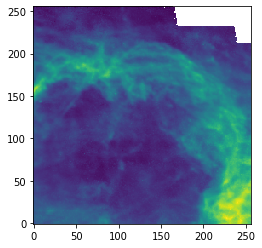

In [11]:
plt.imshow(np.sum(subcube, 0), origin='lower')

## Function for producing Gaussians

Here, I define a function for a gaussian function. I will be plotting some gaussians manually, so I need this function for later

In [12]:
# Some constants for the integrals:
dv = abs(cdelt3)
C = 1.82243e18

In [13]:
# Function for a single Gaussian 
def one_gauss_func(x, amp, cent, sigma):
    '''
    Description: 
        Evaluates a Gaussian function given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        amp - The amplitude of the Gaussian - float
        cent - The location of the of the peak - float 
        sigma - The width of the peak - float
    
    Returns:
        The function evaluated at x - float
    '''
    return amp*np.exp(-((x-cent)/(2*sigma))**2)

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        c = params[i+1]
        s = params[i+2]
        y = y + a * np.exp( -((x - c)/(2*s))**2)
    return y

## Define the limits and the region

In [14]:
subvel = vel[:idx_lim_right-idx_lim_left]
subcube = subcube[idx_lim_left:idx_lim_right,:,:]

I can first just plot a random spectrum, then also plot the average spectrum, which will give us more information

In [15]:
# x_rand = 70; y_rand = 110 #interesting point 
# x_rand = 113; y_rand = 145 #interesting point 
# x_rand = 154; y_rand = 23 #interesting point 

x = 226  y = 147


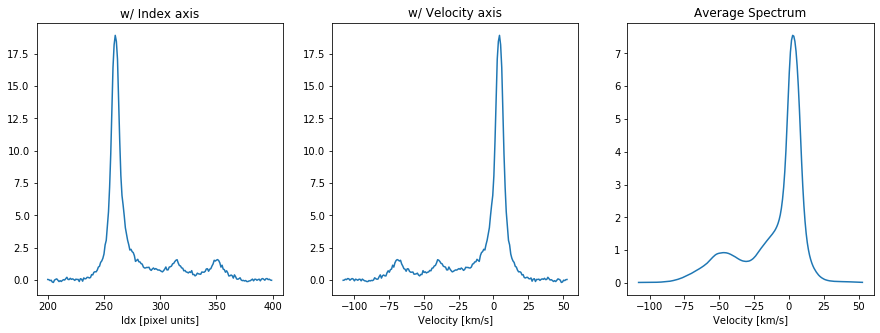

In [16]:
x_rand = random.randint(0,255) ; y_rand = random.randint(0,255)
print('x =',x_rand,' y =',y_rand)

avg = np.nanmean(subcube, (1,2))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("w/ Index axis"); plt.xlabel("Idx [pixel units]")
plt.plot(index_arr[idx_lim_left:idx_lim_right], subcube[:,y_rand, x_rand])

plt.subplot(1,3,2)
plt.title("w/ Velocity axis"); plt.xlabel("Velocity [km/s]")
plt.plot(subvel, subcube[:,y_rand, x_rand])

plt.subplot(1,3,3)
plt.title("Average Spectrum"); plt.xlabel("Velocity [km/s]")
plt.plot(subvel, avg)

plt.show()

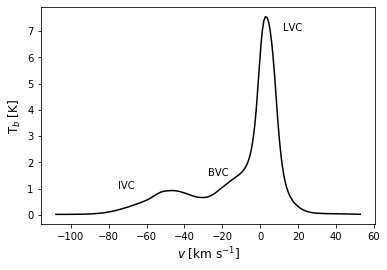

In [17]:
fig=plt.figure()
plt.plot(subvel, np.nanmean(subcube, (1,2)), color='black')
plt.text(-75,1. ,"IVC", fontsize=10)
plt.text(-27.5,1.5, "BVC", fontsize=10)
plt.text(12,7, "LVC", fontsize=10)
#plt.text(-105, 0.35, "HVC", fontsize=10)
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=12)
plt.ylabel("T$_{b}$ [K]", fontsize=12)
fig.savefig("Mean_spectrum_with_labels.png", bbox_inches='tight')

## Noise Map

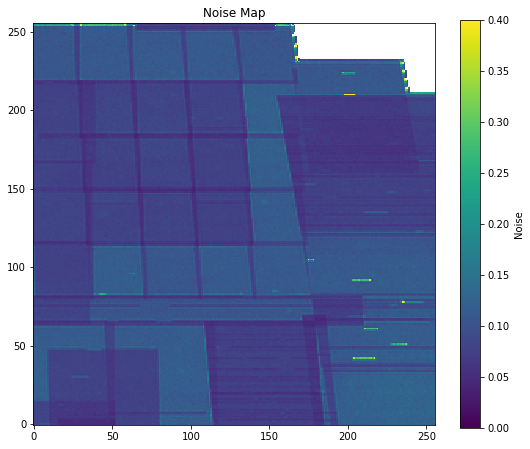

In [18]:
fig=plt.figure(figsize=(9,7.5))
#noise_cube = cube[:24] # Using the first 24 channels of the index axis.
#noise = np.std(noise_cube, 0)

noise = hdu[2].data[:,:][y_corner:y_corner+256, x_corner:x_corner+256]

rms = np.array([noise*(1+channel/20) for channel in subcube]) # channel means T_b
plt.title("Noise Map")
#plt.imshow(rms[37+25], origin='lower', vmin=0, vmax=0.4) ; plt.colorbar(label='Noise')
plt.imshow(np.mean(rms, 0), origin='lower', vmin=0, vmax=0.4) ; plt.colorbar(label='Noise')
#fig.savefig("Noise_map.png", bbox_inches='tight')

## Getting ROHSA to analyze a region

In [19]:
#!git clone https://github.com/antoinemarchal/ROHSA.git ROHSA
#import os
#os.chdir('ROHSA/src')
#!make
#os.chdir('../../')

## Define the ROHSA parameters

In [20]:
# Ranges:
subcube = subcube[:105] #[30:90]
subvel = subvel[:105] #[30:90]
rms = rms[:105] #[30:90]

#subcube[subcube != subcube] = 0
#rms[rms != rms] = 0

(105, 256, 256)


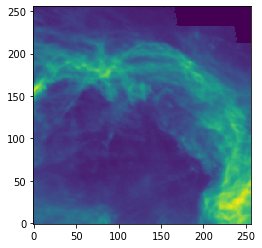

In [21]:
fitsname_LVC = "LVC_cube_boot_100_100.fits"
hdu_LVC = fits.open(fitsname_LVC)
hdr_LVC = hdu_LVC[0].header
LVC_cube = hdu_LVC[0].data[:,:,:]
#core = ROHSA(LVC_cube_boot, hdr=hdr)
print(LVC_cube.shape)
LVC_cube[LVC_cube != LVC_cube] = 0
plt.imshow(np.sum(LVC_cube, 0), origin='lower')

In [22]:
# Ranges:
subcube = subcube[:105] #[30:90]
subvel = subvel[:105] #[30:90]
rms = rms[:105] #[30:90]

subcube[subcube != subcube] = 0
#rms[rms != rms] = 0

path = "/mnt/raid-project/hp/mtaank/repos/Mukesh_SURP/NCPL/"

hdu0 = fits.PrimaryHDU(subcube, header=hdr)
hdulist0 = fits.HDUList([hdu0])
hdulist0.writeto(path + "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_subcube.fits", overwrite=True)

hdu1 = fits.PrimaryHDU(rms, header=hdr)
hdulist1 = fits.HDUList([hdu1])
hdulist1.writeto(path + "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_subcube_rms.fits", overwrite=True)

In [23]:
#fitsname_test = "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_100_500.fits"
#hdu_test = fits.open(fitsname_test)
#hdr_test = hdu_test[0].header
#test = hdu_test[0].data[:,:,:]
#test.shape

In [24]:
#plt.imshow(np.sum(test, 0), origin='lower')

Now to set up the parameters for the Gaussian decomposition.

In [25]:
filename = "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_subcube.fits" #@param
fileout = "!GHIGLS_NCPL_Tb_gauss_run_Noise3D_subcube_11G_norm_var=true_1_100.fits" #@param
filename_parameters = "parameters_NCPL_Noise3D_subcube_11G_norm_var=true_1_100.txt"
filename_noise = 'GHIGLS_NCPL_Tb_INPAINTEDFILTERED_subcube_rms.fits'
#filename_init_spec = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_inits_11G_TEST_3FITS_using_ROHSA_init_TEST.dat"
n_gauss = 11        #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 1      #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 1       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 1      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 100  #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 800         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".true."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 
lb_sig_init = 1.0
ub_sig_init = 10.
lb_sig = 1.0
ub_sig = 12.0
init_spec = '.false.'
norm_var = '.true.'

core = ROHSA(subcube, hdr=hdr)  
#core_rms = ROHSA(rms)
#core.array2dat(init_array_core, filename=filename_init_spec)
###core.cube2dat(filename=filename)
###core_rms.cube2dat(filename=filename_noise)
core.gen_parameters_3D(filename=filename, 
                    fileout=fileout,
                    filename_noise=filename_noise,
                    filename_parameters=filename_parameters,
                    #filename_init_spec=filename_init_spec,
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    noise=noise,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    iprint_init=iprint_init,
                    lb_sig_init=lb_sig_init,
                    ub_sig_init=ub_sig_init,
                    lb_sig = lb_sig,
                    ub_sig = ub_sig,
                    #init_spec=init_spec,
                    save_grid=save_grid,
                    norm_var=norm_var)

Generate parameters_NCPL_Noise3D_subcube_11G_norm_var=true_1_100.txt file


In [26]:
#! ./ROHSA/src/ROHSA-3D parameters_NCPL_Noise3D_11G_no_init_ROHSA-3FITS.txt

## Obtain the Gaussian parameters for the decomposition

In [27]:
#!export PATH=$PATH:/home/amarchal/ROHSA-3FITS/src

In [28]:
#! ROHSA-3FITS parameters_NCPL_Noise3D_TEST_norm_var_LVC_cube_7G_norm_var=false.txt

In [29]:
n_gauss=11
fitsname_gaussian = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_subcube_11G_norm_var=true_100_100.fits"
hdu_gaussian = fits.open(fitsname_gaussian)
hdr_gaussian = hdu_gaussian[0].header
gaussian = hdu_gaussian[0].data[:,:,:]
print(gaussian.shape)

model = core.return_result_cube(gaussian=gaussian)

amplitude = gaussian[0::3]
position = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian[1::3]))
dispersion = gaussian[2::3] * dv

amplitude_pix = gaussian[0::3]
position_pix = gaussian[1::3]
dispersion_pix = gaussian[2::3]

integral = amplitude * dispersion * np.sqrt(2*np.pi) 
NHI_map = integral * C

(33, 256, 256)


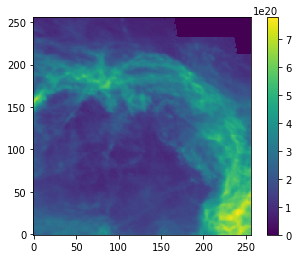

In [30]:
plt.imshow(np.sum(model, 0)*C*dv, origin='lower') ; plt.colorbar()

## Plot a Spectrum

Now, I want to plot a random spectrum / pixel in this region

In [31]:
def plot_spect_1(x_pos, y_pos, vel, model, cube, gaussian, caption=""):
    #fig = plt.figure()
    plt.xlabel("$v$ [km s$^{-1}$]", fontsize=12)
    plt.ylabel("T$_{b}$ [K]", fontsize=12)
    plt.plot(vel, cube, color='darkgoldenrod', label="x="+str(x_pos)+", y="+str(y_pos))#,  label="data")
    plt.plot(vel, model , 'black')#, label="model (pix by pix)")
    
    # To plot all the gaussians under the model and data:
    for i in range(11):
        gauss = core.gauss(np.arange(len(vel)), gaussian[0::3][i][y_pos,x_pos], gaussian[1::3][i][y_pos,x_pos], gaussian[2::3][i][y_pos,x_pos])
        if gaussian[2::3][i][y_pos,x_pos]*dv < 2.25:
            plt.plot(vel, gauss, color='red')#, label="CNM")
        if gaussian[2::3][i][y_pos,x_pos]*dv >= 2.25 and gaussian[2::3][i][y_pos,x_pos]*dv < 5.2:
            plt.plot(vel, gauss, color='green')#, label="UNM")
        if gaussian[2::3][i][y_pos,x_pos]*dv >= 5.2:
            plt.plot(vel, gauss, color='blue')#, label="WNM")
    
    plt.legend(loc="upper right")
    #plt.show()
    #fig.savefig(caption, bbox_inches="tight")

In [32]:
#import matplotlib
#matplotlib.rc('xtick', labelsize=12)
#matplotlib.rc('ytick', labelsize=12)

x =  34
y =  222


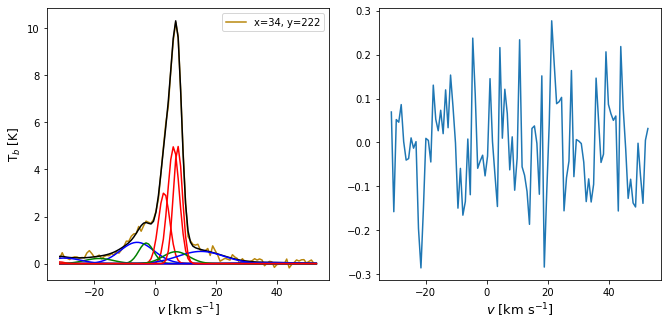

In [33]:
x_pos = random.randint(0,255) #252 
y_pos = random.randint(0,255) #112
print("x = ", x_pos) ; print("y = ", y_pos)
fig=plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plot_spect_1(x_pos, y_pos, subvel[:105], model[:, y_pos, x_pos], subcube[:105, y_pos, x_pos], gaussian, caption="random_spec_main.png")
plt.subplot(1,2,2)
plt.plot(subvel, model[:, y_pos, x_pos]-subcube[:, y_pos, x_pos])
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=13)#; plt.ylabel("T$_{b}$ [K]", fontsize=12)
plt.subplots_adjust(wspace=0.175)
fig.savefig("random_spec_with_residual_1.png", bbox_inches='tight')

In [34]:
def plot_spect(ax, x_pos, y_pos, vel, model, cube, gaussian, caption=""):
    #fig = plt.figure()
    #ax.set_xlabel("$v$ [km s$^{-1}$]", fontsize=13)
    #ax.set_ylabel("T$_{b}$ [K]", fontsize=13)
    ax.step(vel, cube, color='grey')#, label="x="+str(x_pos)+", y="+str(y_pos))#,  label="data")
    ax.plot(vel, model , 'black')#, label="model (pix by pix)")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
        gauss = core.gauss(np.arange(len(vel)), gaussian[0::3][i][y_pos,x_pos], gaussian[1::3][i][y_pos,x_pos], gaussian[2::3][i][y_pos,x_pos]*dv)
        if gaussian[2::3][i][y_pos,x_pos]*dv < 2.25:
            ax.plot(vel, gauss, color='red')#, label="CNM")
        if gaussian[2::3][i][y_pos,x_pos]*dv >= 2.25 and gaussian[2::3][i][y_pos,x_pos]*dv < 5.2:
            ax.plot(vel, gauss, color='forestgreen')#, label="UNM")
        if gaussian[2::3][i][y_pos,x_pos]*dv >= 5.2:
            ax.plot(vel, gauss, color='blue')#, label="WNM")
    
    #ax.legend(loc="upper right")
    #plt.show()
    #fig.savefig(caption, bbox_inches="tight")
    
    

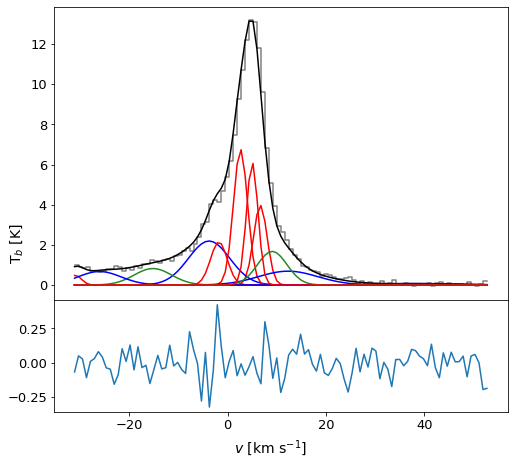

In [35]:
import matplotlib
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
x = 252
y = 112
fig = plt.figure(figsize=(7,6.25))
ax1 = fig.add_axes([0.1, 0.5, 0.9, 0.65],
                   xticklabels=[])
ax2 = fig.add_axes([0.1, 0.25, 0.9, 0.25])

plot_spect(ax1, x, y, subvel[:105], model[:, y, x], subcube[:105, y, x], gaussian, caption="random_spec_main.png")
ax2.plot(subvel, model[:, y, x]-subcube[:, y, x])

fig.text(0.53, 0.16, '$v$ [km s$^{-1}$]', ha='center', fontsize=14)
fig.text(0.01, 0.625, 'T$_{b}$ [K]', va='center', rotation='vertical', fontsize=14)
fig.savefig("random_spec_with_res.png", bbox_inches="tight")

## Find the value of $\chi^{2}$

### Map of Degrees of Freedom

In [36]:
free_params_map = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map = np.zeros((subcube.shape[2],subcube.shape[1]))
free_params_map_LVC = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map_LVC = np.zeros((subcube.shape[2],subcube.shape[1]))
free_params_map_BVC = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map_BVC = np.zeros((subcube.shape[2],subcube.shape[1]))
lim_for_signif_gauss = 1.e-2

for j in range(subcube.shape[2]):
    for i in range(subcube.shape[1]):
        
        integral_spectrum = (amplitude[:,j,i] * dispersion[:,j,i] * np.sqrt(2*np.pi) * C)
        sum_integ_spec = np.sum(integral_spectrum)
        frac_integral = integral_spectrum / sum_integ_spec
        
        num_good_gauss_LVC = 0
        for k in range(n_gauss):
            #LVC
            if position[k][j][i] > -7:
                if frac_integral[k] > lim_for_signif_gauss:
                    num_good_gauss_LVC = num_good_gauss_LVC + 1
                
        signif_gauss_map_LVC[j][i] = num_good_gauss_LVC
        free_params_map_LVC[j][i] = (75) - 3*num_good_gauss_LVC
        
        
        num_good_gauss_BVC = 0
        for k in range(n_gauss):
            #BVC
            if position[k][j][i] <= -7:
                if frac_integral[k] > lim_for_signif_gauss:
                    num_good_gauss_BVC = num_good_gauss_BVC + 1
                
        signif_gauss_map_BVC[j][i] = num_good_gauss_BVC
        free_params_map_BVC[j][i] = (105-75) - 3*num_good_gauss_BVC
        
for j in range(subcube.shape[2]):
    for i in range(subcube.shape[1]):
        
        integral_spectrum = (amplitude[:,j,i] * dispersion[:,j,i] * np.sqrt(2*np.pi) * C)
        sum_integ_spec = np.sum(integral_spectrum)
        frac_integral = integral_spectrum / sum_integ_spec
        
        num_good_gauss = 0
        for k in range(n_gauss):
            
            if frac_integral[k] > lim_for_signif_gauss:
                num_good_gauss = num_good_gauss + 1
                
        signif_gauss_map[j][i] = num_good_gauss
        free_params_map[j][i] = (subcube.shape[0]) - 3*num_good_gauss        

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [37]:
subcube.shape

(105, 256, 256)

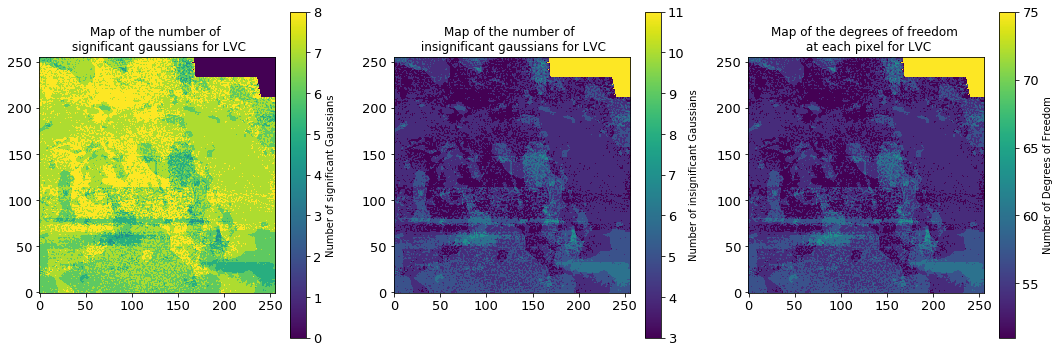

In [38]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1) ; plt.title("Map of the number of \n significant gaussians for LVC")
plt.imshow(signif_gauss_map_LVC, origin='lower') ; plt.colorbar(label="Number of significant Gaussians")
plt.subplot(1,3,2) ; plt.title("Map of the number of \n insignificant gaussians for LVC")
plt.imshow(n_gauss - signif_gauss_map_LVC, origin='lower') ; plt.colorbar(label="Number of insignificant Gaussians")
plt.subplot(1,3,3) ; plt.title("Map of the degrees of freedom \n at each pixel for LVC")
plt.imshow(free_params_map_LVC, origin='lower') ; plt.colorbar(label="Number of Degrees of Freedom")
plt.subplots_adjust(wspace=0.2)

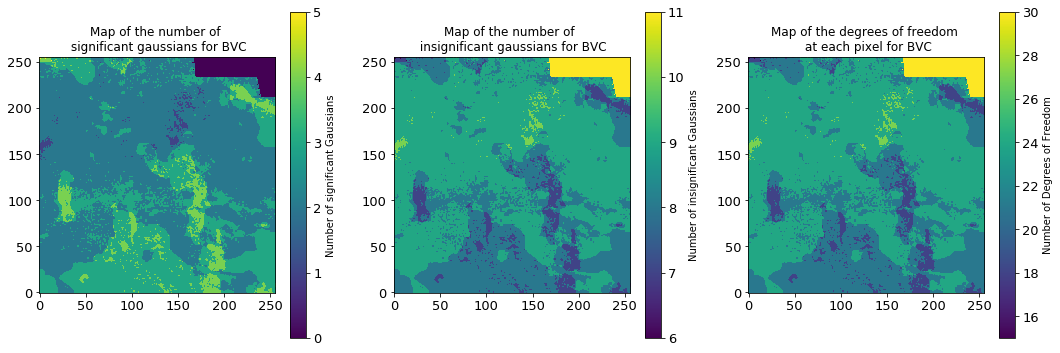

In [39]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1) ; plt.title("Map of the number of \n significant gaussians for BVC")
plt.imshow(signif_gauss_map_BVC, origin='lower') ; plt.colorbar(label="Number of significant Gaussians")
plt.subplot(1,3,2) ; plt.title("Map of the number of \n insignificant gaussians for BVC")
plt.imshow(n_gauss - signif_gauss_map_BVC, origin='lower') ; plt.colorbar(label="Number of insignificant Gaussians")
plt.subplot(1,3,3) ; plt.title("Map of the degrees of freedom \n at each pixel for BVC")
plt.imshow(free_params_map_BVC, origin='lower') ; plt.colorbar(label="Number of Degrees of Freedom")
plt.subplots_adjust(wspace=0.2)

mean # of significant gaussians =  8.969589233398438
mean # of insignificant gaussians =  2.0304107666015625


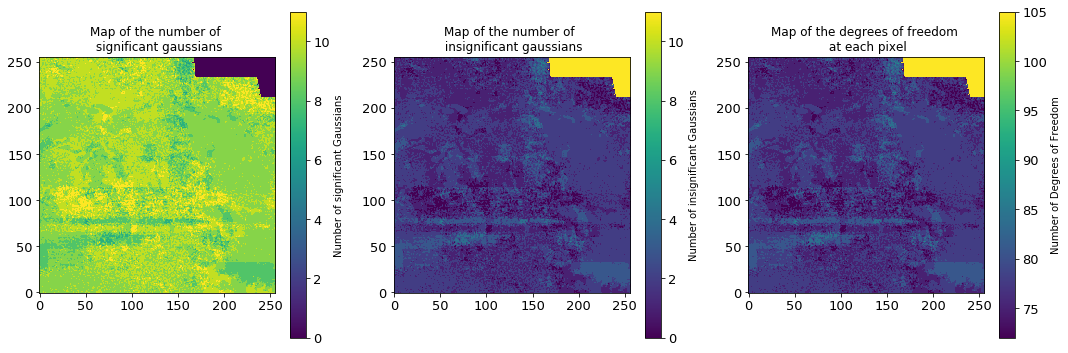

In [40]:
# Can plot a map of the number of free parameters at each pixel
fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1) ; plt.title("Map of the number of \n significant gaussians")
plt.imshow(signif_gauss_map, origin='lower') ; plt.colorbar(label="Number of significant Gaussians")
plt.subplot(1,3,2) ; plt.title("Map of the number of \n insignificant gaussians")
plt.imshow(n_gauss - signif_gauss_map, origin='lower') ; plt.colorbar(label="Number of insignificant Gaussians")
plt.subplot(1,3,3) ; plt.title("Map of the degrees of freedom \n at each pixel")
plt.imshow(free_params_map, origin='lower') ; plt.colorbar(label="Number of Degrees of Freedom")
plt.subplots_adjust(wspace=0.2)

print("mean # of significant gaussians = ", np.mean(signif_gauss_map))
print("mean # of insignificant gaussians = ", np.mean(n_gauss - signif_gauss_map))
#fig.savefig("Map_of_Degrees_of_Freedom_and_Significant_Gauss.png", bbox_inches='tight')

### Map of $\chi^{2}$

In [41]:
diff = (model[:105] - subcube[:105])

chi_sq_map = np.sum((diff/rms[:105])**2, 0)

#chi_sq_map[chi_sq_map != chi_sq_map] = 0
red_chi_sq_map_useful = chi_sq_map / free_params_map
red_chi_sq_map = chi_sq_map / (105-3*11)
#red_chi_sq_map[red_chi_sq_map != red_chi_sq_map] = 0

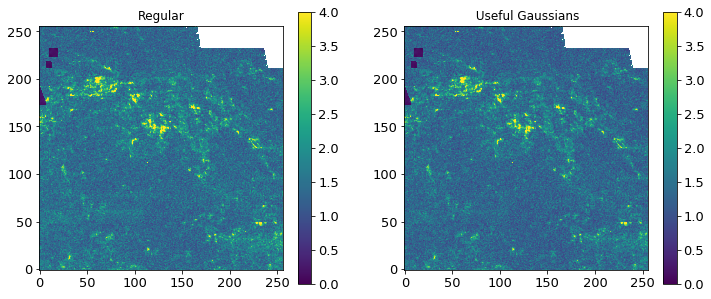

In [42]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("Regular")
plt.imshow(red_chi_sq_map, origin='lower', vmax=4, vmin=0)
plt.colorbar()
plt.subplot(1,2,2); plt.title(" Useful Gaussians")
plt.imshow(red_chi_sq_map_useful, origin='lower', vmax=4, vmin=0)
plt.colorbar()

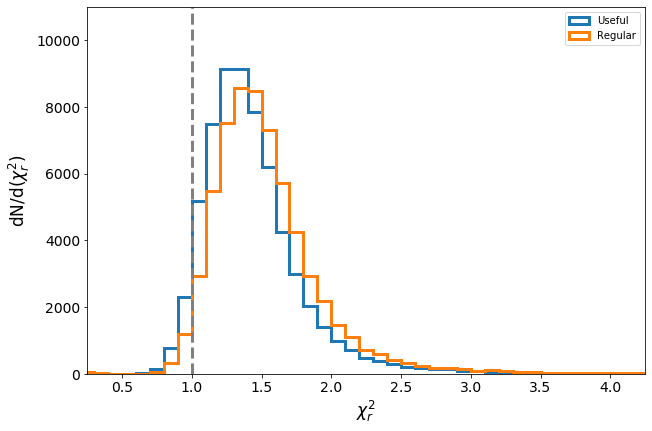

In [43]:
import matplotlib
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

fig = plt.figure(figsize=(10,6.75))
ax = fig.add_subplot(111)
bins = np.linspace(0.1, 6, 60)
ax.hist(red_chi_sq_map_useful.ravel(), bins=bins, log=False, histtype="step",linewidth=3, label=r"Useful", color="tab:blue")
ax.hist(red_chi_sq_map.ravel(), bins=bins, log=False, histtype="step",linewidth=3, label=r"Regular", color="tab:orange")
plt.axvline(x=1.0, ymin=0., color='gray', linestyle='--', linewidth=3)
ax.set_xlabel(r'$\chi^2_r$', fontsize = 17.)
ax.set_ylabel(r'dN/d($\chi^2_r$)', fontsize = 17.)
ax.set_xlim([0.25,4.25])
ax.set_ylim([0, 11000])

plt.legend(loc = 0, numpoints = 1.)
leg = plt.gca().get_legend()
ltext  = leg.get_texts()
plt.setp(ltext, fontsize = 'medium')
plt.savefig('PDF_mod_rchi2_1.png',format='png', bbox_inches='tight')

In [44]:
print(np.nanmean(red_chi_sq_map))
print(np.nanmean(red_chi_sq_map_useful))

1.5321554324441569
1.4315160680158734


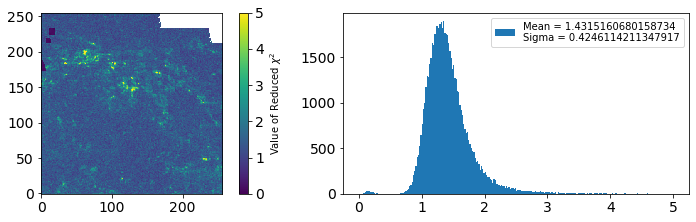

In [45]:
fig = plt.figure(figsize=(20/1.5,5/1.5))
#plt.subplot(2,2,1)
#plt.title("$\chi^{2}$ Map")
#plt.imshow(chi_sq_map, origin='lower', vmin=0, vmax=500.) ; plt.colorbar(label="Value of $\chi^{2}$")
#plt.subplot(2,2,2)
#y_chisq_map, x_chisq_map, _chisq_map = plt.hist(chi_sq_map.ravel(), bins=250, range=[1e-20,300.], label="Mean = "+str(np.nanmean(chi_sq_map))+"\nSigma = "+str(np.sqrt(np.var(chi_sq_map))))
#plt.legend()
plt.subplot(1,2,1)
#plt.title("$\chi^{2}_{r}$ Map")
plt.imshow(red_chi_sq_map_useful, origin='lower', vmin=0, vmax=5) ; plt.colorbar(label="Value of Reduced $\chi^{2}$")
plt.subplot(1,2,2)
y_red_chisq_map, x_red_chisq_map, _red_chisq_map = plt.hist(red_chi_sq_map_useful.ravel(), bins=250, range=[1e-20,5.], label="Mean = "+str(np.nanmean(red_chi_sq_map_useful))+"\nSigma = "+str(np.sqrt(np.nanvar(red_chi_sq_map))))
plt.legend()
plt.subplots_adjust(wspace=0.15)
#fig.savefig("rchi_sq_full_subcube_11G_with_histogram.png", bbox_inches='tight')

This was actually determined to be a problem due to RFI (Radio Frequency Interference) when the data recording was done.

In [46]:
#sub_hdr = hdr
#sub_hdr["CRPIX1"] -= 285
#sub_hdr["CRPIX2"] -= 154

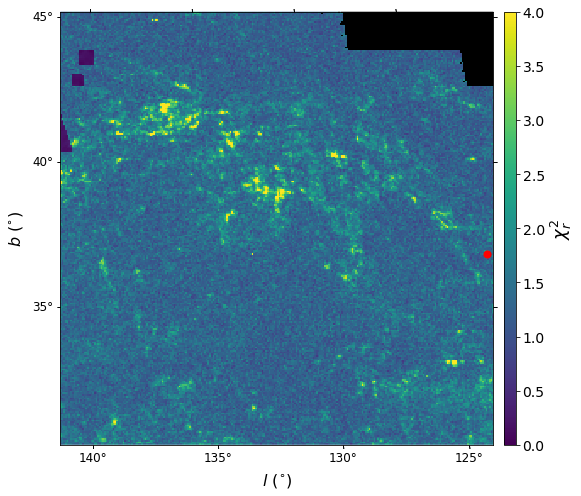

In [47]:
import matplotlib
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

red_chi_sq_map[red_chi_sq_map == 0.] = np.nan
cm_viridis = plt.get_cmap('viridis')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)
import marchalib as ml
w = ml.wcs2D(hdr)
fig = plt.figure(figsize=(10.5/1.33, 10/1.33))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"$l\ (^{\circ})$", fontsize=16.)
ax.set_ylabel(r"$b\ (^{\circ})$", fontsize=16.)
#ax.scatter([252], [112], color='red', s=100)
img = ax.imshow(red_chi_sq_map_useful, vmin=0,vmax=4, **imkw_viridis)
ax.scatter([x], [y], color='red', s=50)
colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$\chi^{2}_{r}$", fontsize=18.)
#ax.plot(36.3, 175.3, 'r', linestyle='None', marker='.', markersize=10)
plt.savefig('rchi_2_map_subcube_11G_with_pos_of_spec.png', format='png', bbox_inches='tight', pad_inches=0.02)

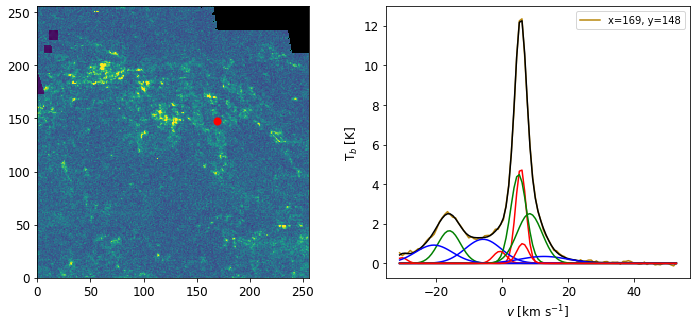

In [48]:
x = random.randint(0,255)#224
y = random.randint(0,255)#77
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(red_chi_sq_map_useful, vmin=0,vmax=4, **imkw_viridis)
plt.scatter([x], [y], color='red', s=50)
plt.subplot(1,2,2)
plot_spect_1(x, y, subvel[:105], model[:, y, x], subcube[:105, y, x], gaussian, caption="random_spec_main.png")

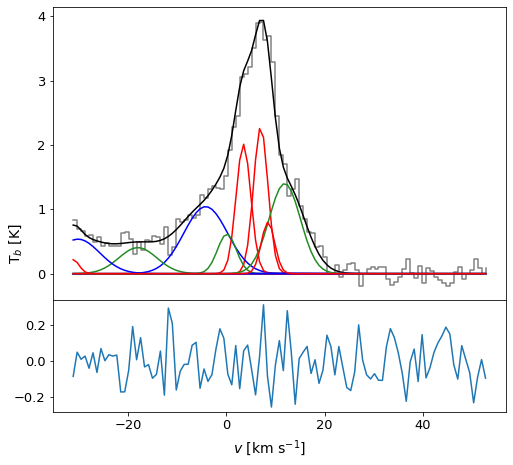

In [49]:
import matplotlib
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
x = 120
y = 112
fig = plt.figure(figsize=(7,6.25))
ax1 = fig.add_axes([0.1, 0.5, 0.9, 0.65],
                   xticklabels=[])
ax2 = fig.add_axes([0.1, 0.25, 0.9, 0.25])

plot_spect(ax1, x, y, subvel[:105], model[:, y, x], subcube[:105, y, x], gaussian, caption="random_spec_main.png")
ax2.plot(subvel, model[:, y, x]-subcube[:, y, x])

fig.text(0.53, 0.16, '$v$ [km s$^{-1}$]', ha='center', fontsize=14)
fig.text(0.01, 0.625, 'T$_{b}$ [K]', va='center', rotation='vertical', fontsize=14)
fig.savefig("random_spec_with_res.png", bbox_inches="tight")

In [50]:
np.nanmean(red_chi_sq_map_useful)

1.4315160680158734

### Map of $\chi^{2}$ Contribution

In [51]:
chi_sq_contrib = (diff / rms[:105])**2
#chi_sq_contrib[chi_sq_contrib != chi_sq_contrib] = 0

channel = 63


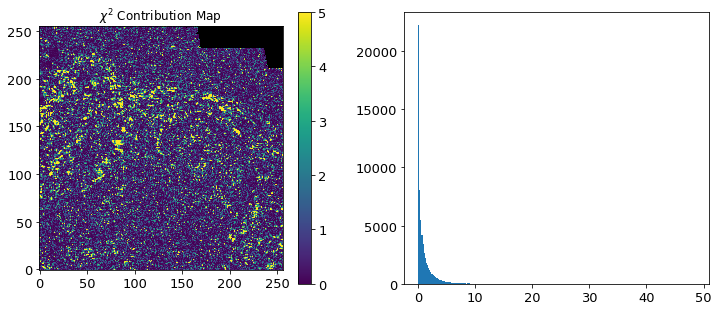

In [52]:
channel = np.random.randint(0,75)
print("channel =", channel)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("$\chi^{2}$ Contribution Map")
plt.imshow(chi_sq_contrib[channel], origin='lower', vmin=0, vmax=5.) ; plt.colorbar()
plt.subplot(1,2,2)
y_chisq_contrib, x_chisq_contrib, _chisq_contrib = plt.hist(chi_sq_contrib[channel].ravel(), bins=250)
plt.show()

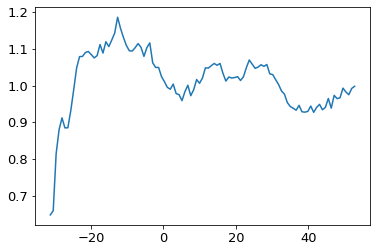

In [53]:
test_chi_sq_contrib = np.nansum((diff / rms)**2, (1,2)) / (256**2)
plt.plot(subvel,test_chi_sq_contrib)

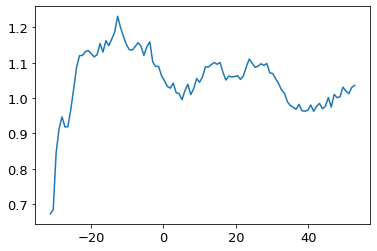

In [54]:
chi_sq_contrib = (diff / rms)**2
plt.plot(subvel, np.nanmean(chi_sq_contrib, (1,2)))

In [55]:
iddx = np.argsort(np.mean(position, axis=(1,2)))
field = np.array([NHI_map[idd] for idd in iddx])
vfield = np.array([position[idd] for idd in iddx])
pixfield = np.array([position_pix[idd] for idd in iddx])
ampfield = np.array([amplitude[idd] for idd in iddx])
sigfield = np.array([dispersion[idd] for idd in iddx])

## Line Broadening

In [56]:
test_instrument_broad = np.zeros(105)
test_instrument_broad[66] = 1.

x_data = np.arange(105)
y_data = test_instrument_broad

#Guesses for the parameters:
amp = 1.
cent = 66.
sigma = 0.1

p_opt, p_cov = curve_fit(one_gauss_func, x_data, y_data, p0 = [amp, cent, sigma])
p_err = np.sqrt(np.diag(p_cov))

amp, cent, sigma = p_opt

gauss = np.array([one_gauss_func(x, amp, cent, sigma) for x in x_data])

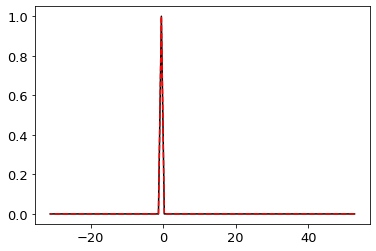

In [57]:
plt.plot(subvel, test_instrument_broad, 'k-')
plt.plot(subvel, gauss, 'r--')

In [58]:
subvel[66]

-0.5057986366813338

[1.] [0.42462845]


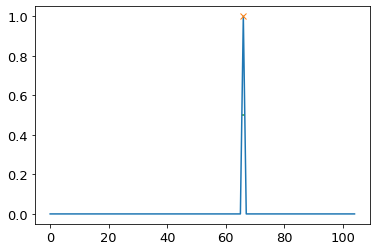

In [59]:
from scipy.signal import chirp, find_peaks, peak_widths
peaks, _ = find_peaks(gauss)
results_half = peak_widths(gauss, peaks, rel_height=0.5)
print(results_half[0], (results_half[0])/2.355)
plt.plot(x_data, gauss)
plt.plot(peaks, gauss[peaks], "x")
plt.hlines(*results_half[1:], color="C2")

In [60]:
print("FWHM =", (results_half[0]*dv)[0], "km/s")
print("sigma =", ((results_half[0]*dv)/2.355)[0], "km/s")

print("FWHM =", results_half[0][0], "pixel units")
print("sigma =", (results_half[0][0])/2.355, "pixel units")

FWHM = 0.807226529926892 km/s
sigma = 0.3427713502874276 km/s
FWHM = 1.0000000000049454 pixel units
sigma = 0.42462845010825706 pixel units


### Absorption Position (DF)

In [61]:
import marchalib as ml
w = ml.wcs2D(hdr)
l = [138.55837265]
b = [40.51217742]
x,y = w.wcs_world2pix(l,b, 0)
x=int(x); y=int(y)
x,y
#sigfield[:,y,x]

(36, 175)

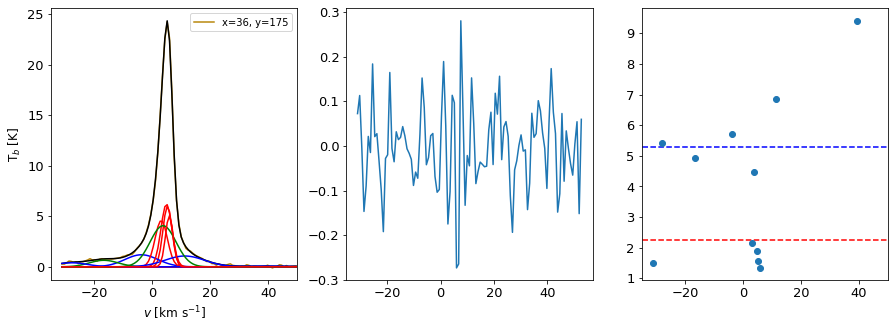

In [62]:
plt.figure(figsize=(15,5))
x_pos = 36#random.randint(0,255)
y_pos = 175#random.randint(0,255)
plt.subplot(1,3,1)
plt.xlim(-35, 50)
plot_spect_1(x_pos, y_pos, subvel, model[:, y_pos, x_pos], subcube[:, y_pos, x_pos], gaussian, caption="random_spec_absorption_peak.png")
plt.subplot(1,3,3)
plt.xlim(-35, 50)
plt.hlines(y=5.3,xmin=-120, xmax=80, color='blue', linestyle='--')
plt.hlines(y=2.25,xmin=-120, xmax=80, color='red', linestyle="--")
plt.plot(position[:,175,36], gaussian[2::3][:,175,36]*dv, linestyle="None", marker='o')
plt.subplot(1,3,2)
plt.plot(subvel, model[:, y_pos, x_pos]-subcube[:, y_pos, x_pos])
#plt.savefig("spectrum_absorption_position_with_sigma-v.png", bbox_inches='tight')

In [63]:
x_pos_abs = 36
y_pos_abs = 175

In [64]:
np.mean(sigfield, (1,2))

array([1.4960443, 5.3664646, 4.6538296, 5.4473624, 2.242373 , 1.8185834,
       1.720216 , 1.7059544, 4.2099566, 7.268218 , 9.292807 ],
      dtype=float32)

In [65]:
LVC_CNM1 = core.gauss(np.arange(len(subvel)), ampfield[4,y_pos_abs,x_pos_abs],pixfield[4,y_pos_abs,x_pos_abs], sigfield[4,y_pos_abs,x_pos_abs])
LVC_CNM2 = core.gauss(np.arange(len(subvel)), ampfield[5,y_pos_abs,x_pos_abs],pixfield[5,y_pos_abs,x_pos_abs], sigfield[5,y_pos_abs,x_pos_abs])
LVC_CNM3 = core.gauss(np.arange(len(subvel)), ampfield[6,y_pos_abs,x_pos_abs],pixfield[6,y_pos_abs,x_pos_abs], sigfield[6,y_pos_abs,x_pos_abs])
LVC_CNM4 = core.gauss(np.arange(len(subvel)), ampfield[7,y_pos_abs,x_pos_abs],pixfield[7,y_pos_abs,x_pos_abs], sigfield[7,y_pos_abs,x_pos_abs])
BVC_CNM1 = core.gauss(np.arange(len(subvel)), ampfield[0,y_pos_abs,x_pos_abs],pixfield[0,y_pos_abs,x_pos_abs], sigfield[0,y_pos_abs,x_pos_abs])

LVC_WNM1 = core.gauss(np.arange(len(subvel)), ampfield[3,y_pos_abs,x_pos_abs],pixfield[3,y_pos_abs,x_pos_abs], sigfield[3,y_pos_abs,x_pos_abs])
LVC_WNM2 = core.gauss(np.arange(len(subvel)), ampfield[9,y_pos_abs,x_pos_abs],pixfield[9,y_pos_abs,x_pos_abs], sigfield[9,y_pos_abs,x_pos_abs])
LVC_WNM3 = core.gauss(np.arange(len(subvel)), ampfield[10,y_pos_abs,x_pos_abs],pixfield[10,y_pos_abs,x_pos_abs], sigfield[10,y_pos_abs,x_pos_abs])
BVC_WNM1 = core.gauss(np.arange(len(subvel)), ampfield[1,y_pos_abs,x_pos_abs],pixfield[1,y_pos_abs,x_pos_abs], sigfield[1,y_pos_abs,x_pos_abs])

LVC_LNM1 = core.gauss(np.arange(len(subvel)), ampfield[8,y_pos_abs,x_pos_abs],pixfield[8,y_pos_abs,x_pos_abs], sigfield[8,y_pos_abs,x_pos_abs])
BVC_LNM1 = core.gauss(np.arange(len(subvel)), ampfield[2,y_pos_abs,x_pos_abs],pixfield[2,y_pos_abs,x_pos_abs], sigfield[2,y_pos_abs,x_pos_abs])

In [66]:
fitsname_LVC = "LVC_cube_boot_100_100.fits"
hdu_LVC = fits.open(fitsname_LVC)
hdr_LVC = hdu_LVC[0].header
LVC_cube_base = hdu_LVC[0].data[:,:,:]
#core = ROHSA(LVC_cube_boot, hdr=hdr)
print(LVC_cube_base.shape)
LVC_cube_base[LVC_cube_base != LVC_cube_base] = 0

(105, 256, 256)


In [67]:
c=np.load("model_abs_pos_LVC_cube.npy")

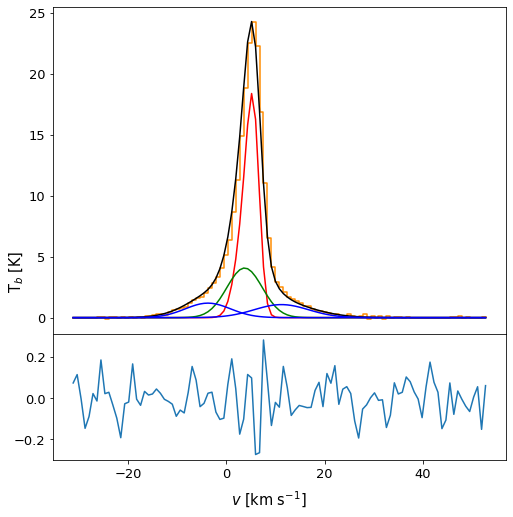

In [68]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_axes([0.1, 0.5, 0.9, 0.65],
                   xticklabels=[])
ax2 = fig.add_axes([0.1, 0.25, 0.9, 0.25])
x_pos_abs = 36
y_pos_abs = 175
ax1.step(subvel, LVC_cube_base[:, y_pos_abs, x_pos_abs], color='darkorange', label='data')
ax1.plot(subvel, c, color='black', label='model')
ax1.plot(subvel, LVC_CNM1+LVC_CNM2+LVC_CNM3+LVC_CNM4, color='red')
ax1.plot(subvel, LVC_LNM1, color='green')
ax1.plot(subvel, LVC_WNM1, color='blue')
ax1.plot(subvel, LVC_WNM2, color='blue')
ax2.plot(subvel, model[:, y_pos_abs, x_pos_abs]-subcube[:, y_pos_abs, x_pos_abs])
fig.text(0.53, 0.16, '$v$ [km s$^{-1}$]', ha='center', fontsize=14.5)
fig.text(0.01, 0.625, 'T$_{b}$ [K]', va='center', rotation='vertical', fontsize=14.5)
fig.savefig("ROHSA_GHIGLS_DF_source_tmp1.png", bbox_inches="tight")

In [69]:
abs_pos_broad = LVC_WNM1+LVC_WNM2+LVC_WNM3+BVC_WNM1+LVC_LNM1+BVC_LNM1+BVC_CNM1
abs_pos_narrow = LVC_CNM1+LVC_CNM2+LVC_CNM3+LVC_CNM4

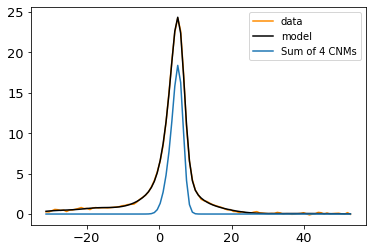

In [70]:
plt.plot(subvel, subcube[:, y_pos_abs, x_pos_abs], color='darkorange', label='data')
plt.plot(subvel, model[:, y_pos_abs, x_pos_abs], color='black', label='model')
plt.plot(subvel, abs_pos_narrow, label="Sum of 4 CNMs")#+ LVC_CNM1+LVC_CNM2+LVC_CNM3+LVC_CNM4)
plt.legend()

In [71]:
x_data = np.arange(105)
y_data_broad = abs_pos_narrow

#Guesses for the parameters:
amp_broad = 20
cent_broad = 60.
sigma_broad = 3.

p_opt_broad, p_cov_broad = curve_fit(one_gauss_func, x_data, y_data_broad, p0 = [amp_broad, cent_broad, sigma_broad])
p_err_broad = np.sqrt(np.diag(p_cov_broad))

amp_broad, cent_broad, sigma_broad = p_opt_broad

gauss_broad = np.array([one_gauss_func(x, amp_broad, cent_broad, sigma_broad) for x in x_data])

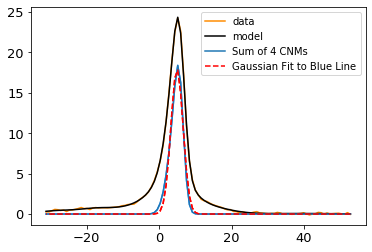

In [72]:
#plt.plot(subvel,subcube[:, y_pos, x_pos], color='darkorange')
#plt.plot(subvel,model[:, y_pos, x_pos], color='black')
plt.plot(subvel,abs_pos_narrow, color='dodgerblue')
plt.plot(subvel, gauss_broad, color='red', linestyle="--")

plt.plot(subvel, subcube[:, y_pos_abs, x_pos_abs], color='darkorange', label='data')
plt.plot(subvel, model[:, y_pos_abs, x_pos_abs], color='black', label='model')
plt.plot(subvel, abs_pos_narrow, label="Sum of 4 CNMs")#+ LVC_CNM1+LVC_CNM2+LVC_CNM3+LVC_CNM4)
plt.plot(subvel, gauss_broad, color='red', linestyle="--", label="Gaussian Fit to Blue Line")
plt.legend()

[3.99227368] [1.69523299]


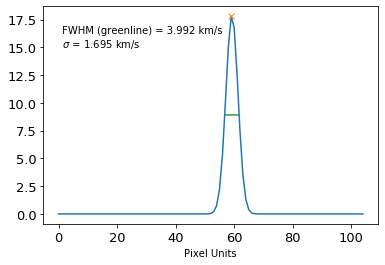

In [73]:
from scipy.signal import chirp, find_peaks, peak_widths

peaks, _ = find_peaks(gauss_broad)
results_half = peak_widths(gauss_broad, peaks, rel_height=0.5)
print(results_half[0]*dv, results_half[0]*dv/2.355)
plt.plot(x_data, gauss_broad)
plt.xlabel("Pixel Units")
plt.text(0, 15, " FWHM (greenline) = "+str(np.round((results_half[0]*dv)[0], 3))+" km/s \n $\sigma$ = "+str(np.round((results_half[0]*dv/2.355)[0], 3))+" km/s")
plt.plot(peaks, gauss_broad[peaks], "x")
plt.hlines(*results_half[1:], color="C2")

## Absorption Position (UM)

In [74]:
import marchalib as ml
w = ml.wcs2D(hdr)
l = [145.67295259]
b = [41.93901850]
x,y = w.wcs_world2pix(l,b, 0)
x=int(x); y=int(y)
x,y

(-54, 199)

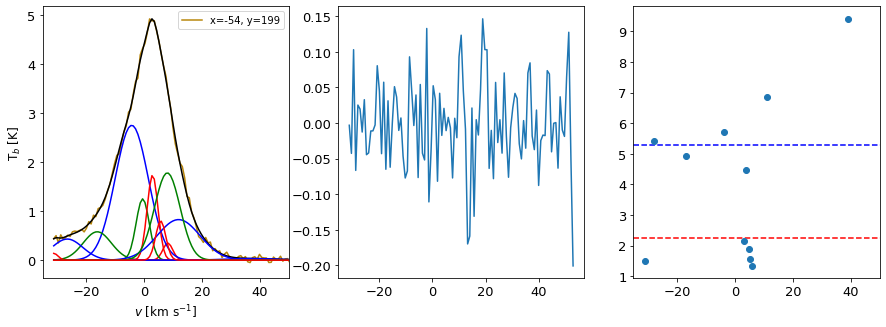

In [75]:
plt.figure(figsize=(15,5))
x_pos = x #random.randint(0,255)
y_pos = y #random.randint(0,255)
plt.subplot(1,3,1)
plt.xlim(-35, 50)
plot_spect_1(x_pos, y_pos, subvel, model[:, y_pos, x_pos], subcube[:, y_pos, x_pos], gaussian, caption="random_spec_absorption_peak.png")
plt.subplot(1,3,3)
plt.xlim(-35, 50)
plt.hlines(y=5.3,xmin=-120, xmax=80, color='blue', linestyle='--')
plt.hlines(y=2.25,xmin=-120, xmax=80, color='red', linestyle="--")
plt.plot(position[:,175,36], gaussian[2::3][:,175,36]*dv, linestyle="None", marker='o')
plt.subplot(1,3,2)
plt.plot(subvel, model[:, y_pos, x_pos]-subcube[:, y_pos, x_pos])
#plt.savefig("spectrum_absorption_position_with_sigma-v.png", bbox_inches='tight')

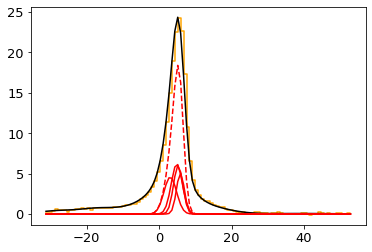

In [76]:
plt.step(subvel, subcube[:,y_pos_abs,x_pos_abs], color='orange')
plt.plot(subvel, model[:,y_pos_abs,x_pos_abs], color='black')

plt.plot(subvel, LVC_CNM1, 'r-')
plt.plot(subvel, LVC_CNM2, 'r-')
plt.plot(subvel, LVC_CNM3, 'r-')
plt.plot(subvel, LVC_CNM4, 'r-')
#plt.plot(subvel, LVC_LNM1)
tot_CNM_abs_pos = LVC_CNM1+LVC_CNM2+LVC_CNM3+LVC_CNM4
tot_LNM_abs_pos = LVC_LNM1
plt.plot(subvel, tot_CNM_abs_pos, color='red', linestyle="--")
#plt.axvline(x=np.array(spec_2_velocity(crval3,cdelt3,crpix3,np.array([cent1])))[0])

In [77]:
#sigma1,  np.array(spec_2_velocity(crval3,cdelt3,crpix3,np.array([cent1])))[0]

In [78]:
x_data = np.arange(105)
y_data_narrow_gauss = tot_LNM_abs_pos
amp = 5.
cent = 60.
sigma = 6.
p_opt1, p_cov1 = curve_fit(one_gauss_func, x_data, y_data_narrow_gauss, p0 = [amp, cent, sigma], absolute_sigma=True)
p_err1 = np.sqrt(np.diag(p_cov1))
amp1, cent1, sigma1 = p_opt1
narrow_gauss = np.array([func(x, amp1, cent1, sigma1) for x in x_data])
print("Center of Narrow Gauss =", np.array(spec_2_velocity(crval3,cdelt3,crpix3,np.array([cent1])))[0], "km/s")

Center of Narrow Gauss = 3.7175569629885103 km/s


In [79]:
x_data = np.arange(105)
y_data1 = tot_CNM_abs_pos
y_data2 = LVC_CNM1+LVC_CNM3+LVC_CNM2

#Guesses for the parameters:
amp = 12.
cent = 60.
sigma = 3.

p_opt1, p_cov1 = curve_fit(one_gauss_func, x_data, y_data1, p0 = [amp, cent, sigma])
p_err1 = np.sqrt(np.diag(p_cov1))

p_opt2, p_cov2 = curve_fit(one_gauss_func, x_data, y_data2, p0 = [amp, cent, sigma])
p_err2 = np.sqrt(np.diag(p_cov2))

amp1, cent1, sigma1 = p_opt1
amp2, cent2, sigma2 = p_opt2

gauss1 = np.array([one_gauss_func(x, amp1, cent1, sigma1) for x in x_data])
gauss2 = np.array([one_gauss_func(x, amp2, cent2, sigma2) for x in x_data])

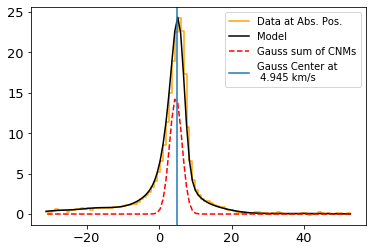

In [80]:
sum_CNM_gauss_center = np.array(spec_2_velocity(crval3,cdelt3,crpix3,np.array([cent1])))
plt.step(subvel, subcube[:,y_pos_abs,x_pos_abs], color='orange', label="Data at Abs. Pos.")
plt.plot(subvel, model[:,y_pos_abs,x_pos_abs], color='black', label="Model")
plt.plot(subvel, gauss2, color='red', linestyle="--", label="Gauss sum of CNMs")
plt.axvline(x=sum_CNM_gauss_center, label="Gauss Center at\n "+str(np.round(np.float(sum_CNM_gauss_center), 3))+" km/s")
plt.legend()

[8.51362489] 1.5218776220806793


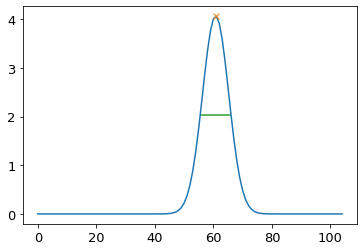

In [81]:
from scipy.signal import chirp, find_peaks, peak_widths

peaks, _ = find_peaks(narrow_gauss)
results_half = peak_widths(narrow_gauss, peaks, rel_height=0.5)
print(results_half[0]*dv, 3.5840218/2.355)
plt.plot(x_data, narrow_gauss)
plt.plot(peaks, narrow_gauss[peaks], "x")
plt.hlines(*results_half[1:], color="C2")

## Absorption NCPL (GHIGLS)

In [90]:
DF_fitsname = "DHIGLS_DF_Tb.fits"
DF_hdu = fits.open(DF_fitsname)
DF_hdr = DF_hdu[0].header
DF_cube = DF_hdu[0].data[:,:,:]
print(DF_cube.shape)
#plt.plot(v_LSR/1000, -DF_cube[:,379,  1179])

filename = "DF_absorption.dat"

#Open the file
infile = open(filename, 'r') 

lines = infile.readlines()[7:]

for line in lines:
    sline = line.split(',')  # separates line into a list of items.  ',' tells it to split the lines at the commas
    print(sline) #each line is now a list

infile.close()  #Always close the file!

v_LSR = []
T_b = []
for i in range(len(lines)):
    x=float(lines[i][:21])
    y=float(lines[i][21:])
    v_LSR.append(x)
    T_b.append(y)
v_LSR = np.array(v_LSR)
T_b = np.array(T_b)

(250, 1680, 1764)
['4.3033974766731e+04    -1.7974025011063e+00\n']
['4.2209702968597e+04    1.2497029304504e+00\n']
['4.1385431170464e+04    6.0188835859299e-01\n']
['4.0561159372330e+04    6.9647639989853e-01\n']
['3.9736887574196e+04    2.9083421826363e-01\n']
['3.8912615776062e+04    8.6906796693802e-01\n']
['3.8088343977928e+04    7.4450165033340e-01\n']
['3.7264072179794e+04    -1.1160979270935e+00\n']
['3.6439800381660e+04    5.2821034193039e-01\n']
['3.5615528583527e+04    8.7695229053497e-01\n']
['3.4791256785393e+04    -9.1187453269958e-01\n']
['3.3966984987259e+04    -3.2591621875763e+00\n']
['3.3142713189125e+04    -2.1265318393707e+00\n']
['3.2318441390991e+04    8.7010407447815e-01\n']
['3.1494169592857e+04    -3.8877117633820e-01\n']
['3.0669897794723e+04    -2.1946673393250e+00\n']
['2.9845625996590e+04    -1.1317868232727e+00\n']
['2.9021354198456e+04    1.4518265724182e+00\n']
['2.8197082400322e+04    3.4434845447540e+00\n']
['2.7372810602188e+04    3.4834239482880e+0

In [91]:
#http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=NVSS+J101132%2B712440&submit=SIMBAD+search
import marchalib as ml
w = ml.wcs2D(hdr)
l = [138.5582091012138]
b = [40.5119926762304]
x,y = w.wcs_world2pix(l,b, 0)
x,y

(array([36.3550227]), array([175.32046268]))

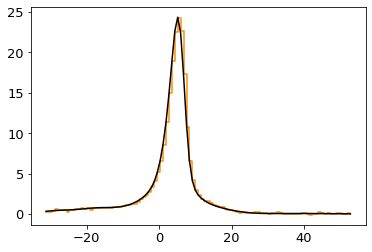

In [92]:
plt.step(subvel, subcube[:,int(y),int(x)], color='darkorange')
plt.plot(subvel, model[:,int(y),int(x)], color='black')

In [93]:
138.5582091012138 +40.5119926762304

179.0702017774442

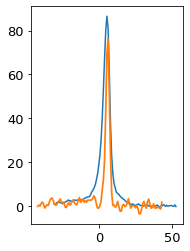

In [94]:
plt.subplot(1,2,1)
plt.plot(subvel, subcube[:,int(y),int(x)]*(25/7), label="GHIGLS abs")
plt.plot((v_LSR/1000)[:105], -T_b[:105], linewidth=1.75, label="DHIGLS abs")

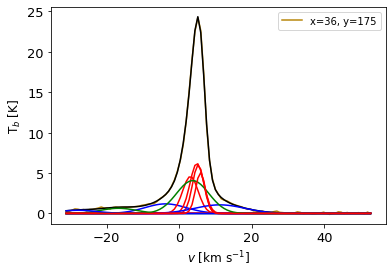

In [95]:
plot_spect_1(x_pos_abs, y_pos_abs, subvel[:105], model[:,y_pos_abs, x_pos_abs], subcube[:105, y_pos_abs, x_pos_abs], gaussian, caption="random_spec_main.png")

In [96]:
x_data = np.arange(105)
y_data = subcube[:105, y_pos_abs, x_pos_abs]#-T_b[:105]
sigma = rms
#Guesses for the parameters:
#amp = [25., 20]
#cent = [60., 63]
#sigma = [5., 10]

p0 = [5, 60, 5, 7, 65, 8, 15, 55, 10]

p_opt, p_cov = curve_fit(func, x_data, y_data, p0 = p0, absolute_sigma="True")
#popt, pcov = curve_fit(func, x_data, mean_spec, p0=init_array)

fit = func(x_data, *p_opt)

gauss1 = np.array([func(x, p_opt[0::3][0], p_opt[1::3][0], p_opt[2::3][0]) for x in x_data])
gauss2 = np.array([func(x, p_opt[0::3][1], p_opt[1::3][1], p_opt[2::3][1]) for x in x_data])
gauss3 = np.array([func(x, p_opt[0::3][2], p_opt[1::3][2], p_opt[2::3][2]) for x in x_data])

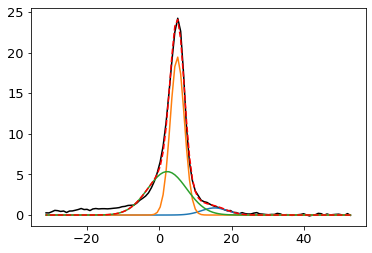

In [97]:
plt.plot(subvel, subcube[:105, y_pos_abs, x_pos_abs], 'k-')
plt.plot(subvel, gauss1)
plt.plot(subvel, gauss2)
plt.plot(subvel, gauss3)
plt.plot(subvel, fit, 'r--')

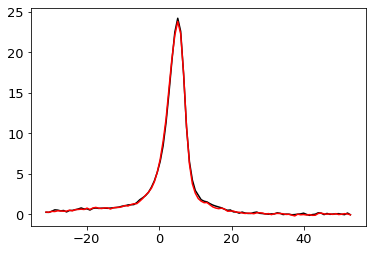

In [98]:
plt.plot(subvel, subcube[:105, y_pos_abs, x_pos_abs], 'k-')
plt.plot(subvel, subcube[:105, y_pos_abs, x_pos_abs+1], 'r-')

In [99]:
p_opt[2::3][1]

1.6952451329645104

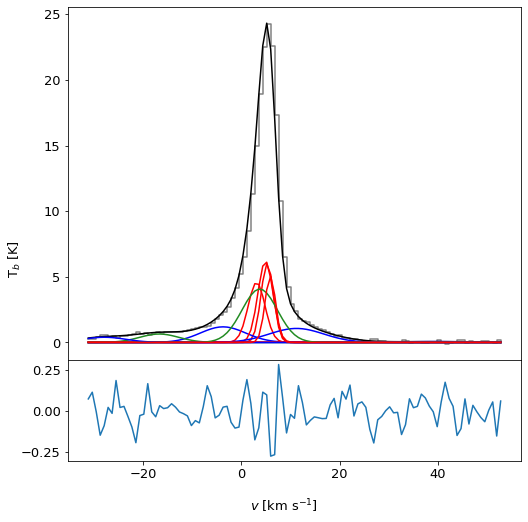

In [100]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_axes([0.1, 0.5, 0.9, 0.7],
                   xticklabels=[])
ax2 = fig.add_axes([0.1, 0.3, 0.9, 0.2])
x_pos_abs = 36
y_pos_abs = 175
plot_spect(ax1, x_pos_abs, y_pos_abs, subvel[:105], model[:,y_pos_abs, x_pos_abs], subcube[:105, y_pos_abs, x_pos_abs], gaussian, caption="random_spec_main.png")
ax2.plot(subvel, model[:, y_pos_abs, x_pos_abs]-subcube[:, y_pos_abs, x_pos_abs])
fig.text(0.53,0.2, '$v$ [km s$^{-1}$]', ha='center', fontsize=13)
fig.text(-0.02, 0.7, 'T$_{b}$ [K]', va='center', rotation='vertical', fontsize=13)
fig.savefig("ROHSA_GHIGLS_DF_source_tmp1.png", bbox_inches="tight")

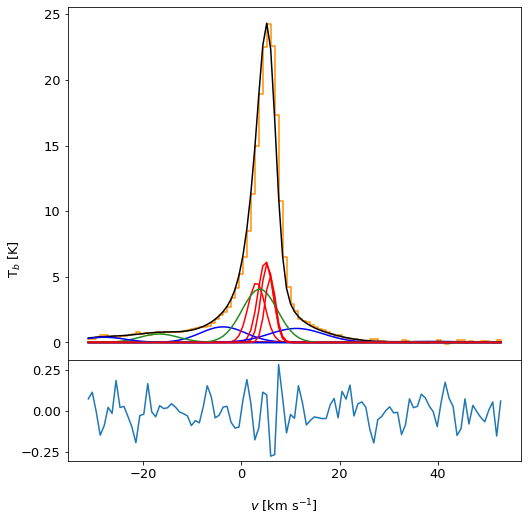

In [101]:
def plot_spect(ax, x_pos, y_pos, vel, model, cube, gaussian, caption=""):
    #fig = plt.figure()
    #ax.set_xlabel("$v$ [km s$^{-1}$]", fontsize=13)
    #ax.set_ylabel("T$_{b}$ [K]", fontsize=13)
    ax.step(vel, cube, color='darkorange')#, label="x="+str(x_pos)+", y="+str(y_pos))#,  label="data")
    ax.plot(vel, model , 'black')#, label="model (pix by pix)")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
        gauss = core.gauss(np.arange(len(vel)), gaussian[0::3][i][y_pos,x_pos], gaussian[1::3][i][y_pos,x_pos], gaussian[2::3][i][y_pos,x_pos]*dv)
        if gaussian[2::3][i][y_pos,x_pos]*dv < 2.25:
            ax.plot(vel, gauss, color='red')#, label="CNM")
        if gaussian[2::3][i][y_pos,x_pos]*dv >= 2.25 and gaussian[2::3][i][y_pos,x_pos]*dv < 5.2:
            ax.plot(vel, gauss, color='forestgreen')#, label="UNM")
        if gaussian[2::3][i][y_pos,x_pos]*dv >= 5.2:
            ax.plot(vel, gauss, color='blue')#, label="WNM")

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_axes([0.1, 0.5, 0.9, 0.7],
                   xticklabels=[])
ax2 = fig.add_axes([0.1, 0.3, 0.9, 0.2])
x_pos_abs = 36
y_pos_abs = 175
plot_spect(ax1, x_pos_abs, y_pos_abs, subvel[:105], model[:,y_pos_abs, x_pos_abs], subcube[:105, y_pos_abs, x_pos_abs], gaussian, caption="random_spec_main.png")
ax2.plot(subvel, model[:, y_pos_abs, x_pos_abs]-subcube[:, y_pos_abs, x_pos_abs])
fig.text(0.53,0.2, '$v$ [km s$^{-1}$]', ha='center', fontsize=13)
fig.text(-0.02, 0.7, 'T$_{b}$ [K]', va='center', rotation='vertical', fontsize=13)
fig.savefig("ROHSA_GHIGLS_DF_source_tmp1.png", bbox_inches="tight")

## Spectrum Data DF Absorption (DHIGLS)

In [102]:
DF_fitsname = "DHIGLS_DF_Tb.fits"
DF_hdu = fits.open(DF_fitsname)
DF_hdr = DF_hdu[0].header
DF_cube = DF_hdu[0].data[:,:,:]
print(DF_cube.shape)
#plt.plot(v_LSR/1000, -DF_cube[:,379,  1179])

(250, 1680, 1764)


In [103]:
filename = "DF_absorption.dat"

#Open the file
infile = open(filename, 'r') 

lines = infile.readlines()[7:]

for line in lines:
    sline = line.split(',')  # separates line into a list of items.  ',' tells it to split the lines at the commas
    print(sline) #each line is now a list

infile.close()  #Always close the file!

['4.3033974766731e+04    -1.7974025011063e+00\n']
['4.2209702968597e+04    1.2497029304504e+00\n']
['4.1385431170464e+04    6.0188835859299e-01\n']
['4.0561159372330e+04    6.9647639989853e-01\n']
['3.9736887574196e+04    2.9083421826363e-01\n']
['3.8912615776062e+04    8.6906796693802e-01\n']
['3.8088343977928e+04    7.4450165033340e-01\n']
['3.7264072179794e+04    -1.1160979270935e+00\n']
['3.6439800381660e+04    5.2821034193039e-01\n']
['3.5615528583527e+04    8.7695229053497e-01\n']
['3.4791256785393e+04    -9.1187453269958e-01\n']
['3.3966984987259e+04    -3.2591621875763e+00\n']
['3.3142713189125e+04    -2.1265318393707e+00\n']
['3.2318441390991e+04    8.7010407447815e-01\n']
['3.1494169592857e+04    -3.8877117633820e-01\n']
['3.0669897794723e+04    -2.1946673393250e+00\n']
['2.9845625996590e+04    -1.1317868232727e+00\n']
['2.9021354198456e+04    1.4518265724182e+00\n']
['2.8197082400322e+04    3.4434845447540e+00\n']
['2.7372810602188e+04    3.4834239482880e+00\n']
['2.65485388

In [104]:
v_LSR = []
T_b = []
for i in range(len(lines)):
    x=float(lines[i][:21])
    y=float(lines[i][21:])
    v_LSR.append(x)
    T_b.append(y)
v_LSR = np.array(v_LSR)
T_b = np.array(T_b)

In [105]:
x_data = np.arange(105)
y_data = -T_b[:105]

#Guesses for the parameters:
amp = 75.
cent = 48.
sigma = 7.

p_opt, p_cov = curve_fit(one_gauss_func, x_data, y_data, p0 = [amp, cent, sigma])
p_err = np.sqrt(np.diag(p_cov))

amp, cent, sigma = p_opt

gauss1 = np.array([one_gauss_func(x, amp, cent, sigma) for x in x_data])

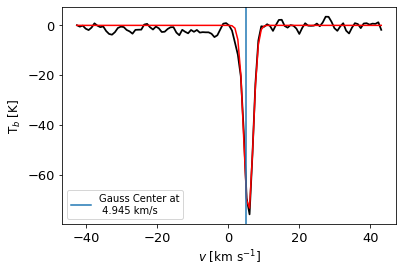

In [106]:
plt.plot((v_LSR/1000)[:105], T_b[:105], 'k-', linewidth=1.75)
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=12)
plt.ylabel("T$_{b}$ [K]", fontsize=12)
plt.plot(v_LSR[:105]/1000, -gauss1, color='red', linestyle='-', linewidth=1.5)
plt.axvline(x=sum_CNM_gauss_center, label="Gauss Center at\n "+str(np.round(np.float(sum_CNM_gauss_center), 3))+" km/s")
plt.legend()
plt.savefig("DF_absorption_fit_update.png", bbox_inches='tight')

FWHM =  [3.20480009]
sigma =  [1.36084929]


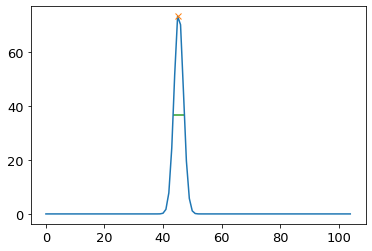

In [107]:
from scipy.signal import chirp, find_peaks, peak_widths
peaks, _ = find_peaks(gauss1)
results_half = peak_widths(gauss1, peaks, rel_height=0.5)
print("FWHM = ",results_half[0]*0.825)
print("sigma = ", results_half[0]*0.825/2.355)
plt.plot(x_data, gauss1)
plt.plot(peaks, gauss1[peaks], "x")
plt.hlines(*results_half[1:], color="C2")

In [108]:
amp, cent, sigma

(75.69596399464778, 45.38925190973895, 1.1244749611376037)

In [109]:
np.min(-gauss1), np.min(T_b[:105])

(-73.46195064745369, -75.99813079834)

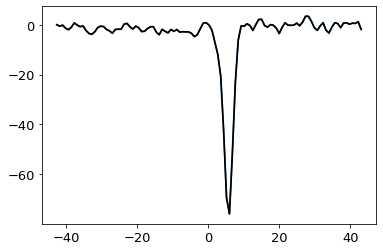

In [110]:
x_abs_dhigls = 379
y_abs_dhigls = 1179

plt.plot((v_LSR/1000)[:105], DF_cube[:105,x_abs_dhigls,  y_abs_dhigls], label="from DF cube")
plt.plot((v_LSR/1000)[:105], T_b[:105], 'k-', linewidth=1.75, label="from file")

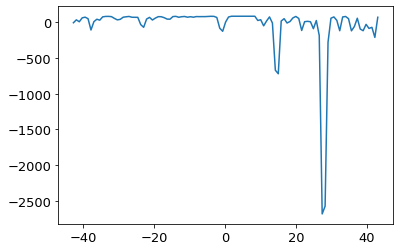

In [111]:
x_data_abs = (v_LSR/1000)[:105]
y_data_abs = 85 * (1 - np.exp(T_b[:105]))
plt.plot(x_data_abs, y_data_abs)

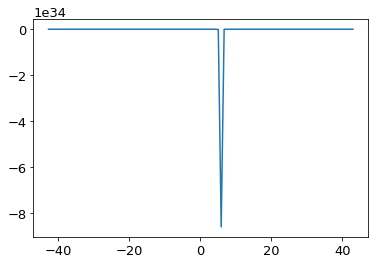

In [112]:
T_s = 85
plt.plot((v_LSR[:105])/1000, T_s*(1-np.exp(-T_b[:105])))

In [113]:
cent

45.38925190973895

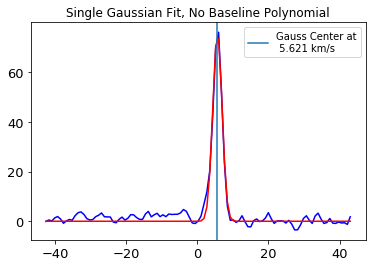

In [114]:
sum_CNM_gauss_center = v_LSR[:105][int(cent)]/1000 - .38925190973895*((v_LSR[:105][0]-v_LSR[:105][1])/1000)
plt.plot(v_LSR[:105]/1000, y_data, 'b-')
plt.plot(v_LSR[:105]/1000, gauss1, 'r-')
plt.axvline(x=sum_CNM_gauss_center, label="Gauss Center at\n "+str(np.round(np.float(sum_CNM_gauss_center), 3))+" km/s")
plt.title("Single Gaussian Fit, No Baseline Polynomial")
plt.legend()

FWHM =  [3.20480009]
sigma =  [1.36084929]


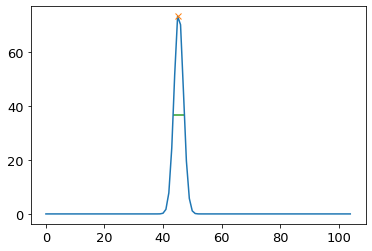

In [115]:
peaks, _ = find_peaks(gauss1)
results_half = peak_widths(gauss1, peaks, rel_height=0.5)
print("FWHM = ",results_half[0]*0.825)
print("sigma = ", results_half[0]*0.825/2.355)
plt.plot(x_data, gauss1)
plt.plot(peaks, gauss1[peaks], "x")
plt.hlines(*results_half[1:], color="C2")

In [116]:
def gauss_and_cnst_func(x, a1, c, s, k):
    return a1*np.exp(-((x-c)**2)/(2*s**2)) + k

In [117]:
x_data = np.arange(105)
y_data = -T_b[:105]

#Guesses for the parameters:
a1 = 75.
c = 48.
s = 7.
k = 0.2

p_opt, p_cov = curve_fit(gauss_and_cnst_func, x_data, y_data, p0 = [a1 ,c, s,k])

a1, c, s, k = p_opt

gauss_and_cnst = np.array([gauss_and_cnst_func(x, a1, c, s, k) for x in x_data])

In [118]:
c

45.38611051958316

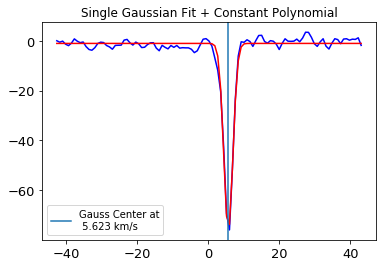

In [119]:
sum_CNM_gauss_center = v_LSR[:105][int(cent)]/1000 - .38611051958316*((v_LSR[:105][0]-v_LSR[:105][1])/1000)
plt.plot(v_LSR[:105]/1000, -y_data, 'b-')
plt.plot(v_LSR[:105]/1000, -gauss_and_cnst, 'r-')
plt.axvline(x=sum_CNM_gauss_center, label="Gauss Center at\n "+str(np.round(np.float(sum_CNM_gauss_center), 3))+" km/s")
plt.title("Single Gaussian Fit + Constant Polynomial")
plt.legend()

In [120]:
a1, c, s, k

(75.06240832051661, 45.38611051958316, 1.5570763742151108, 1.009805783456184)

FWHM =  [3.14009346]
sigma =  [1.33337302]


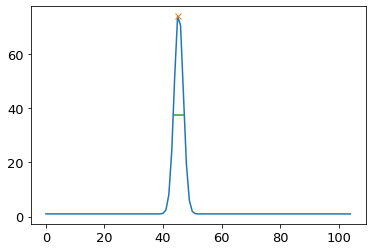

In [121]:
peaks, _ = find_peaks(gauss_and_cnst)
results_half = peak_widths(gauss_and_cnst, peaks, rel_height=0.5)
print("FWHM = ",results_half[0]*0.8242717981330024)
print("sigma = ", results_half[0]*0.8242717981330024/2.355)
plt.plot(x_data, gauss_and_cnst)
plt.plot(peaks, gauss_and_cnst[peaks], "x")
plt.hlines(*results_half[1:], color="C2")

In [122]:
def gauss_and_line_func(x, a1, c, s, m, b):
    return a1*np.exp(-((x-c)**2)/(2*s**2)) + m*x + b

In [123]:
x_data = np.arange(105)
y_data = -T_b[:105]

#Guesses for the parameters:
a1 = 75.
c = 48.
s = 7.
m = 0.1
b = 0

p_opt, p_cov = curve_fit(gauss_and_line_func, x_data, y_data, p0 = [a1 ,c, s, m, b])

a1, c, s, m, b = p_opt

gauss_and_line = np.array([gauss_and_line_func(x, a1, c, s, m, b) for x in x_data])

In [124]:
c

45.384700586621385

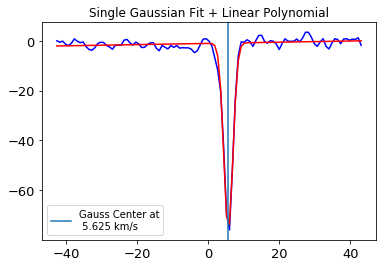

In [125]:
sum_CNM_gauss_center = v_LSR[:105][int(cent)]/1000 - .384700586621385*((v_LSR[:105][0]-v_LSR[:105][1])/1000)
plt.plot(v_LSR[:105]/1000, -y_data, 'b-')
plt.plot(v_LSR[:105]/1000, -gauss_and_line, 'r-')
plt.axvline(x=sum_CNM_gauss_center, label="Gauss Center at\n "+str(np.round(np.float(sum_CNM_gauss_center), 3))+" km/s")
plt.title("Single Gaussian Fit + Linear Polynomial")
plt.legend()

FWHM =  [3.14352604]
sigma =  [1.33483059]


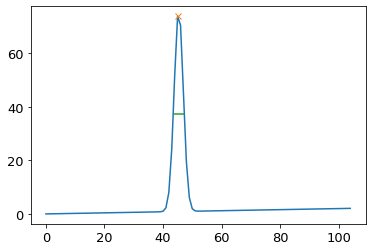

In [126]:
peaks, _ = find_peaks(gauss_and_line)
results_half = peak_widths(gauss_and_line, peaks, rel_height=0.5)
print("FWHM = ",results_half[0]*0.8242717981330024)
print("sigma = ", results_half[0]*0.8242717981330024/2.355)
plt.plot(x_data, gauss_and_line)
plt.plot(peaks, gauss_and_line[peaks], "x")
plt.hlines(*results_half[1:], color="C2")

In [127]:
a1, c, s, m, b

(75.15830108943351,
 45.384700586621385,
 1.5615121300180768,
 0.019929662016900378,
 -0.03805972141495704)

In [128]:
def gauss_and_quadratic_func(x, a1, c, s, a2, h, k):
    return a1*np.exp(-((x-c)**2)/(2*s**2)) + a2*(x-h)**2 + k

In [129]:
x_data = np.arange(105)
y_data = -T_b[:105]

#Guesses for the parameters:
a1 = 75.
c = 48.
s = 7.
a2 = 1.
h = 45.
k = 75.

p_opt, p_cov = curve_fit(gauss_and_quadratic_func, x_data, y_data, p0 = [a1 ,c, s, a2, h, k])

a1, c, s, a2, h, k = p_opt

gauss_and_quad = np.array([gauss_and_quadratic_func(x, a1, c, s, a2, h, k) for x in x_data])

In [130]:
c

45.382436622800924

In [131]:
-a1

-74.80498371046889

In [132]:
s*dv

1.2464765719489515

In [133]:
(c-crpix3)*dv + crval3

785.2343279662393

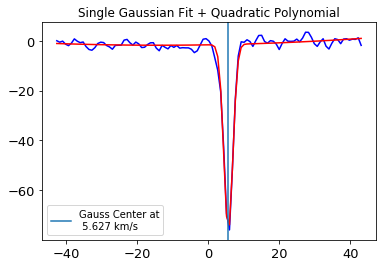

In [134]:
sum_CNM_gauss_center = v_LSR[:105][int(c)]/1000 - .382436622800924/1000*(v_LSR[:105][0]-v_LSR[:105][1])

plt.plot(v_LSR[:105]/1000, -y_data, 'b-')
plt.plot(v_LSR[:105]/1000, -gauss_and_quad, 'r-')
plt.axvline(x=sum_CNM_gauss_center, label="Gauss Center at\n "+str(np.round(np.float(sum_CNM_gauss_center), 3))+" km/s")
plt.title("Single Gaussian Fit + Quadratic Polynomial")
plt.legend()

FWHM =  [ 3.06202298 19.07655766]
sigma =  [1.30022207 8.10044911]


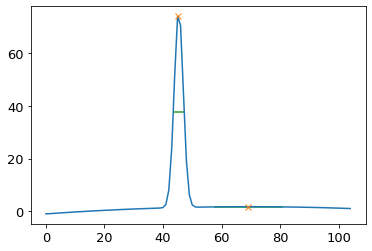

In [135]:
peaks, _ = find_peaks(gauss_and_quad)
results_half = peak_widths(gauss_and_quad, peaks, rel_height=0.5)
print("FWHM = ",results_half[0]*dv)
print("sigma = ", results_half[0]*dv/2.355)
plt.plot(x_data, gauss_and_quad)
plt.plot(peaks, gauss_and_quad[peaks], "x")
plt.hlines(*results_half[1:], color="C2")

In [136]:
a1, c, s, a2, h, k

(74.80498371046889,
 45.382436622800924,
 1.5441471826601205,
 -0.0005731428399991864,
 69.1146868225018,
 1.7368714452895)

In [137]:
v_LSR[70]/1000

-14.665051102638001

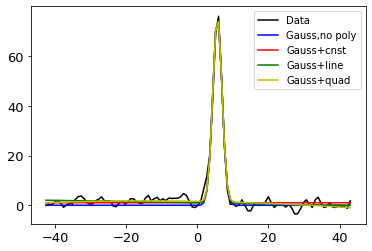

In [138]:
plt.plot(v_LSR[:105]/1000, y_data, 'k-', label="Data")
plt.plot(v_LSR[:105]/1000, gauss1, 'b-', label="Gauss,no poly")
plt.plot(v_LSR[:105]/1000, gauss_and_cnst, 'r-', label="Gauss+cnst")
plt.plot(v_LSR[:105]/1000, gauss_and_line, 'g-', label="Gauss+line")
plt.plot(v_LSR[:105]/1000, gauss_and_quad, 'y-', label="Gauss+quad")
plt.legend()

## DHIGLS Data cube

In [139]:
DF_fitsname = "DHIGLS_DF_Tb.fits"
DF_hdu = fits.open(DF_fitsname)
DF_hdr = DF_hdu[0].header
DF_cube = DF_hdu[0].data[:,:,:]
print(DF_cube.shape)

(250, 1680, 1764)


In [140]:
x_abs_dhigls = 379
y_abs_dhigls = 1179

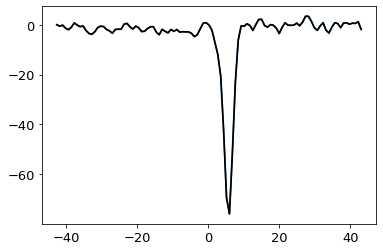

In [141]:
x_abs_dhigls = 379
y_abs_dhigls = 1179

plt.plot((v_LSR/1000)[:105], DF_cube[:105,x_abs_dhigls,  y_abs_dhigls], label="from DF cube")
plt.plot((v_LSR/1000)[:105], T_b[:105], 'k-', linewidth=1.75, label="from file")

## Plot a mosaic of spectra

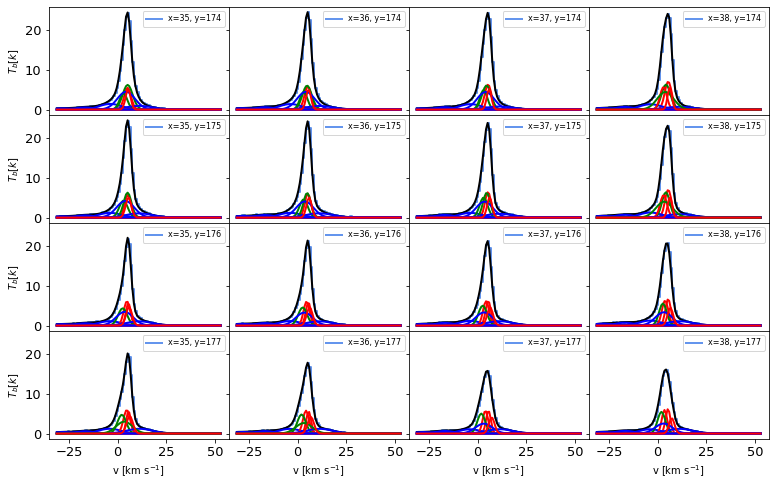

In [142]:
## Mosaic of the Spectra
x_pos = 35#np.random.randint(0,255) ; print("x = ", x_pos)
y_pos = 174#np.random.randint(0,255) ; print("y = ", y_pos)

pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

ny = 4; nx = 4
center_y = y_pos; center_x = x_pos
cb = "magenta"
cw = "crimson"
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
for i in np.arange(ny):
    for j in np.arange(nx):
        axs[i][j].step(subvel, subcube[:,center_y+i,center_x+j], color='cornflowerblue', linewidth=2., label="x="+str(center_x+j)+", y="+str(center_y+i))
        axs[i][j].plot(subvel, model[:,center_y+i,center_x+j], linestyle="-", linewidth=2., color="k")
        for k in range(n_gauss):
            if gaussian[2::3][k][center_y+i,center_x+j] < 2.25:
                gauss_color="red"
            if gaussian[2::3][k][center_y+i,center_x+j] > 2.25 and gaussian[2::3][k][center_y+i,center_x+j] < 5.3:
                gauss_color="green"
            if gaussian[2::3][k][center_y+i,center_x+j] > 5.3:
                gauss_color="blue"
            axs[i][j].plot(subvel, core.gauss(np.arange(len(subvel)), gaussian[0::3][k][center_y+i,center_x+j],
                                              gaussian[1::3][k][center_y+i,center_x+j], gaussian[2::3][k][center_y+i,center_x+j]),
                           linewidth=2., color=gauss_color)
        if j == 0: axs[i][j].set_ylabel(r'$T_{b}[k]$')
        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
        axs[i][j].legend(loc="upper right", fontsize=8)
#fig.savefig("Mosaic_of_Spectra_at_absorption_peak.png", bbox_inches='tight')

# 2D Histogram: Sigma-Mu

In [143]:
iddx = np.argsort(np.mean(position, axis=(1,2)))
field = np.array([NHI_map[idd] for idd in iddx])
vfield = np.array([position[idd] for idd in iddx])
pixfield = np.array([position_pix[idd] for idd in iddx])
ampfield = np.array([amplitude[idd] for idd in iddx])
sigfield = np.array([dispersion[idd] for idd in iddx])

In [144]:
LVC_IVC1_bound_CNM_UNM = -10.
LVC_IVC1_bound_WNM = LVC_IVC1_bound_CNM_UNM
IVC1_IVC2_bound = -32.5
CNM_UNM_LVC_bound = 2.25
CNM_UNM_IVC1_2_bound = CNM_UNM_LVC_bound
UNM_WNM_bound = 5.3
CNM_UNM_bound = CNM_UNM_LVC_bound 

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10



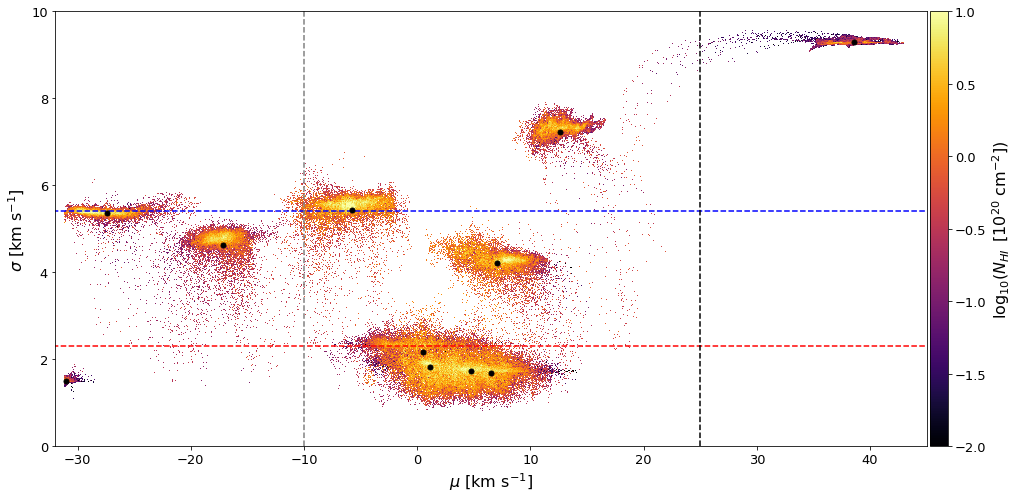

In [147]:
cm_viridis = plt.get_cmap('inferno')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap='inferno')

#foo = init_array
#for i in range(len(foo)):
#    amp = foo[::3]
#    pos = np.array(spec_2_velocity(crval3,cdelt3,crpix3,foo[1::3]))
#    dis = foo[2::3]*dv
    
x_bins = np.linspace(np.min(vfield.ravel()), np.max(vfield.ravel()), 1200)
y_bins = np.linspace(0.1,np.max(sigfield)+1, 1200)
H, xedges, yedges = np.histogram2d(vfield.ravel(), sigfield.ravel(),
                                   weights=np.sqrt(2.*np.pi)*ampfield.ravel()*(sigfield.ravel())*C/1e20,
                                   bins=[x_bins, y_bins])
H = np.ma.masked_invalid(np.atleast_2d(H))
fig = plt.figure(figsize=(16.,8.))

#Weighted Averages of the Clusters:
weighted_vel = [np.sum(vfield[i]*field)/np.sum(field) for i in range(11)]
weighted_sig = [np.sum(sigfield[i]*field)/np.sum(field) for i in range(11)]

#plt.plot(subvel, np.nanmean(subcube, (1,2)), color="black")
#plt.plot(pos, dis, color='darkorange', linestyle='None', marker='.', markersize=10, label="ROHSA_init Optimal Params")
#plt.plot(np.mean(vfield, (1,2)).ravel(), np.mean(sigfield, (1,2)).ravel(), color='black', linestyle='None', marker='.', markersize=10, label="Average Gaussian Params")
plt.plot(np.array(weighted_vel).ravel(), np.array(weighted_sig).ravel(), color='black', linestyle='None', marker='.', markersize=10)#, label="Weighted Average Gaussian Params")
plt.axvline(x=LVC_IVC1_bound_CNM_UNM, ymin=0., color='gray', linestyle='--', linewidth=1.5),# label="LVC-IVC1 Boundary")
plt.axvline(x=IVC1_IVC2_bound, color='darkgray', linestyle='--', linewidth=1.5) #label="IVC1-IVC2 Boundary")
plt.axvline(x=-90, color='black', linestyle='--', linewidth=1.5) #label="IVC1-IVC2 Boundary")
plt.axvline(x=25, color='black', linestyle='--', linewidth=1.5) #label="IVC1-IVC2 Boundary")
plt.hlines(y=5.4, xmin=-120, xmax=80, color='blue', linestyle='--', linewidth=1.5)#, label="UNM-WNM Boundary")
plt.hlines(y=2.3,xmin=-120, xmax=80, color='red', linestyle="--", linewidth=1.5)
#plt.legend(loc="upper left")

ax = fig.add_subplot(111)
ax.set_ylim([0.,10.])
ax.set_xlim([-32, 45])
ax.set_xlabel(r'$\mu$ [km s$^{-1}$]',  fontsize = 16)
ax.set_ylabel(r'$\sigma$ [km s$^{-1}$]',  fontsize = 16)
ax.yaxis.set_major_formatter(ScalarFormatter())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap='inferno', vmin=-2, vmax=1)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label(r'log$_{10}$($N_{HI}\,$ $[10^{20}$ cm$^{-2}$])', fontsize = 16)

#fig.savefig("sigma_v_diagram_subcube_11G_with_weighted_means_with_mu_sig_seps_new_color.png", bbox_inches="tight")

In [ ]:
np.array(weighted_vel).ravel()

In [ ]:
np.array(weighted_sig).ravel()

## Velocity Components

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
import matplotlib
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
import cmasher as cmr
cmap_NH = cmr.pride                  
cmap_NH = plt.get_cmap('cmr.pride')
im1 = axs[0].imshow((1/10**20)*(field[0]+field[1]+field[2]), origin='lower', cmap=cmap_NH, vmin=0, vmax=1.8)
im2 = axs[1].imshow((1/10**20)*(field[3]+field[4]+field[5]+field[6]+field[7]+field[8]+field[9]), origin='lower', cmap=cmap_NH, vmin=1e-20)
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.06)
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.06)
tick_locator1 = ticker.MaxNLocator(nbins=5)
cbar1 = fig.colorbar(im1, ax=axs[0], cax=cax1, pad=0.015, orientation='horizontal')
cbar2 = fig.colorbar(im2, ax=axs[1], cax=cax2, pad=0.015,  orientation='horizontal')
cbar1.locator = tick_locator1
tick_locator2 = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator2
axs[0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
axs[1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
#axs[0].scatter([36], [175], color='white', s=25)
#axs[1].scatter([36], [175], color='white', s=25)
cbar1.set_label(r"N$_{HI}$ [10$^{20}$ cm$^{-2}$]", fontsize=15.)
cbar2.set_label(r"N$_{HI}$ [10$^{20}$ cm$^{-2}$]", fontsize=15.)
fig.subplots_adjust(wspace=-0.385)
fig.savefig("col_dens_BVC_LVC_new_color.png", bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(22.5,6))
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
sum_model = np.sum(model, 0)*C*dv
sum_subcube = np.sum(subcube, 0)*C*dv
im1 = axs[0].imshow((1/10**20)*sum_subcube, origin='lower', cmap="inferno")
im2 = axs[1].imshow((1/10**20)*sum_model, origin='lower', cmap="inferno")
im3 = axs[2].imshow((1/10**18)*(sum_model-sum_subcube), origin='lower', cmap="inferno", vmin=-5, vmax=5)
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.06)
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.06)
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.06)
cbar1 = fig.colorbar(im1, ax=axs[0], cax=cax1, pad=0.015, orientation='horizontal', extend="both")
cbar2 = fig.colorbar(im2, ax=axs[1], cax=cax2, pad=0.015,  orientation='horizontal', extend="both")
cbar3 = fig.colorbar(im3, ax=axs[2], cax=cax3, pad=0.015,  orientation='horizontal', extend="both")
axs[0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
axs[1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
axs[2].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
cbar1.set_label(r"N$_{HI}$ / [10$^{20}$ cm$^{-2}$]", fontsize=15.)
cbar2.set_label(r"N$_{HI}$ / [10$^{20}$ cm$^{-2}$]", fontsize=15.)
cbar3.set_label(r"N$_{HI}$ / [10$^{18}$ cm$^{-2}$]", fontsize=15.)
fig.subplots_adjust(wspace=-0.5)
#fig.savefig("data_vs_model_with_residual.png", bbox_inches='tight')

In [ ]:
LVC_CNM = np.zeros((256,256)) ; BVC_CNM = np.zeros((256,256)) ; IVC_CNM = np.zeros((256,256))
LVC_LNM = np.zeros((256,256)) ; BVC_LNM = np.zeros((256,256)) ; IVC_LNM = np.zeros((256,256))
LVC_WNM = np.zeros((256,256)) ; BVC_WNM = np.zeros((256,256)) ; IVC_WNM = np.zeros((256,256))

for k in range(n_gauss):
    if np.mean(sigfield[k]) <= CNM_UNM_bound:
        if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
            LVC_CNM = LVC_CNM + field[k]
    if np.mean(sigfield[k]) <= CNM_UNM_IVC1_2_bound:
        if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
            BVC_CNM = BVC_CNM + field[k]
        if np.mean(vfield[k]) < IVC1_IVC2_bound:
            IVC_CNM = IVC_CNM + field[k]
    if np.mean(sigfield[k]) > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
        if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
            LVC_LNM = LVC_LNM + field[k]
    if np.mean(sigfield[k]) > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
        if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
            BVC_LNM = BVC_LNM + field[k]
        if np.mean(vfield[k]) < IVC1_IVC2_bound:
            IVC_LN = IVC_LNM + field[k]
    if np.mean(sigfield[k]) > UNM_WNM_bound:
        if np.mean(vfield[k]) >= LVC_IVC1_bound_WNM:
            LVC_WNM = LVC_WNM + field[k]
        if np.mean(vfield[k]) < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
            BVC_WNM = BVC_WNM + field[k]
        if np.mean(vfield[k]) < IVC1_IVC2_bound:
            IVC_WNM = IVC_WNM + field[k]
            
total_LVC = LVC_CNM + LVC_LNM + LVC_WNM
total_BVC = BVC_CNM + BVC_LNM + BVC_WNM
total_IVC = IVC_CNM + IVC_LNM + IVC_WNM

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,3,1) ; plt.title("CNM Mass Fraction", fontsize=15); plt.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
plt.imshow(LVC_CNM/total_LVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("LNM Mass Fraction", fontsize=15); plt.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
plt.imshow(LVC_LNM/total_LVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("WNM Mass Fraction", fontsize=15); plt.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
plt.imshow(LVC_WNM/total_LVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplots_adjust(wspace=0.05)
#fig.savefig("Mass_Fraction_Maps_LVC.png", bbox_inches='tight')

In [ ]:
import matplotlib
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)

fig = plt.figure(figsize=(10.5,8))
ax = fig.add_subplot(111)
bins = np.linspace(0, 2.5, 100)
ax.hist((LVC_CNM/total_LVC).ravel(), bins=bins, log=False, histtype="step", color='red', linewidth=3, label=r"CNM")
ax.hist((LVC_LNM/total_LVC).ravel(), bins=bins, log=False, histtype="step", color='green', linewidth=3, label=r"LNM")
ax.hist((LVC_WNM/total_LVC).ravel(), bins=bins, log=False, histtype="step", color='blue', linewidth=3, label=r"WNM")
ax.set_xlabel(r'$f_{\rm \phi}$', fontsize = 18.)
ax.set_ylabel(r'dN/d($f_{\rm \phi}$)', fontsize = 18.)
ax.set_xlim([0,1])
#ax.set_ylim([0,1e4])
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
plt.legend(loc = 0, numpoints = 1., fontsize=14)
leg = plt.gca().get_legend()
ltext  = leg.get_texts()
plt.setp(ltext, fontsize = 'medium')
plt.savefig('PDF_mod_mass_frac2.png',format='png', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,3,1) ; plt.title("CNM Mass Fraction", fontsize=15); plt.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
plt.imshow(BVC_CNM/total_BVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("LNM Mass Fraction", fontsize=15); plt.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
plt.imshow(BVC_LNM/total_BVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("WNM Mass Fraction", fontsize=15); plt.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
plt.imshow(BVC_WNM/total_BVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplots_adjust(wspace=0.05)
#fig.savefig("Mass_Fraction_Maps_BVC.png", bbox_inches='tight')

In [ ]:
f=plt.figure(figsize=(24,6))
#LVC_WNM[LVC_WNM == 0.] = np.nan
#LVC_LNM[LVC_LNM == 0.] = np.nan
#LVC_CNM[LVC_CNM == 0.] = np.nan
plt.subplot(1,3,3) ; plt.title("Column Density of CNM", fontsize=15); plt.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
plt.imshow(LVC_WNM,  **imkw_viridis) ; plt.colorbar(pad=0.03)
plt.subplot(1,3,2) ; plt.title("Column Density of LNM", fontsize=15); plt.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
plt.imshow(LVC_LNM,  **imkw_viridis) ; plt.colorbar(pad=0.03)
plt.subplot(1,3,1) ; plt.title("Column Density of WNM", fontsize=15); plt.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
plt.imshow(LVC_CNM,  **imkw_viridis) ; plt.colorbar(pad=0.03)
#f.savefig("Phase_Maps_LVC.png", bbox_inches='tight')

In [ ]:
cm_viridis = plt.get_cmap('inferno')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)

In [ ]:
#Plot mosaic field   
def cm2inch(*tupl):
        inch = 2.54
        if isinstance(tupl[0], tuple):
            return tuple(i/inch for i in tupl[0])
        else:
            return tuple(i/inch for i in tupl)

lh = 2; lw = 6
fig1, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(30/2,15/2))
fig1.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.325, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im = axs[i][j].imshow(field[k]/10**18, origin="lower", cmap="inferno")
        color = "white"
        if np.mean(sigfield[k]) <= CNM_UNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/CNM  "+str(np.round(np.mean(sigfield[k]), 2)), color='white', size=13.)#, weight="bold")
        if np.mean(sigfield[k]) <= CNM_UNM_IVC1_2_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/CNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13.)#, weight="bold")
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/CNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13.)#, weight="bold")
        if np.mean(sigfield[k]) > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/LNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13.)#, weight="bold")
        if np.mean(sigfield[k]) > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/LNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13.)#, weight="bold")
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/LNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13.)#, weight="bold")
        if np.mean(sigfield[k]) > UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC/WNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13.)#, weight="bold")
            if np.mean(vfield[k]) < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/WNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13.)#, weight="bold")
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/WNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13.)#, weight="bold")       
                       
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=13.)
        if i == lh-1 : cbar.set_label(r"N$_{HI}$ [10$^{18}$ cm$^{-2}$]", fontsize=16.)
        k += 1
        if k ==n_gauss:
            break

im=axs[1][5].imshow(0*field[0]/10**18, origin="lower", cmap="binary") ; axs[1][5].axis("off")
fig1.savefig("col_dens_mosaic_11G_NO_bold_letters.png", bbox_inches='tight')

In [ ]:
#Plot mosaic field mean
lh = 2; lw = 6
fig1, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(30/2,15/2))
fig1.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.325, wspace=0.1)
k=0
for i in np.arange(lh):
    for j in np.arange(lw):
        elev_min=np.nanmin(vfield[k])
        elev_max=np.nanmax(vfield[k])
        mid_val=0
        im1 = axs[i][j].imshow(vfield[k], origin="lower", cmap="coolwarm")
        color = "black"
        if np.mean(sigfield[k]) <= CNM_UNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC", color=color, size=14.)
        if np.mean(sigfield[k]) <= CNM_UNM_IVC1_2_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC", color=color, size=14.)
        if np.mean(sigfield[k]) > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC", color=color, size=14.)
        if np.mean(sigfield[k]) > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC", color=color, size=14.)
        if np.mean(sigfield[k]) > UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC", color=color, size=14.)
            if np.mean(vfield[k]) < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC", color=color, size=14.)       
         
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%d', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=18.)
        k += 1
        if k ==n_gauss:
            break
axs[1][5].imshow(0*field[0]/10**18, origin="lower", cmap="binary") ; axs[1][5].axis("off") 
plt.savefig('mean_velocity_mosaic_11G_without_phase_label.png', format='png', bbox_inches='tight', pad_inches=0.02)

In [ ]:
#Plot mosaic field sigma   
lh = 2; lw = 6
fig1, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(30/2,15/2))
fig1.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.325, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im1 = axs[i][j].imshow(sigfield[k], origin="lower", cmap="cubehelix")
        color = "black"
        #if k == 0:
        #    color = "white"
        if np.mean(sigfield[k]) <= CNM_UNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC", color=color, size=14.)
        if np.mean(sigfield[k]) <= CNM_UNM_IVC1_2_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC", color=color, size=14.)
        if np.mean(sigfield[k]) > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC", color=color, size=14.)
        if np.mean(sigfield[k]) > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC", color=color, size=14.)
        if np.mean(sigfield[k]) > UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC", color=color, size=14.)
            if np.mean(vfield[k]) < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC", color=color, size=14.)       
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%.1f', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=18.)
        k += 1
        if k ==n_gauss:
            break
axs[1][5].imshow(0*field[0]/10**18, origin="lower", cmap="binary") ; axs[1][5].axis("off")
plt.savefig('mean_velocity_dispersion_11G_without_phase_label.png', format='png', bbox_inches='tight', pad_inches=0.02)

NH Maps

In [ ]:
import matplotlib
import matplotlib.gridspec as gridspec
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
fig = plt.figure(constrained_layout=True, figsize=(20,15))
spec = gridspec.GridSpec(ncols=10, nrows=6, figure=fig)
anno_opts = dict(xy=(0.01953,0.01953), xycoords='axes fraction')#, va='center', ha='center')
fig.subplots_adjust(wspace=0.05, hspace=-0.2)

ax_1_1 = fig.add_subplot(spec[0:2, 1:3]); ax_1_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_1 = ax_1_1.imshow((1/10**18)*field[0], origin='lower', cmap='inferno')
ax_1_1.annotate('BVC/CNM 1.50', **anno_opts, color='white', fontsize=13)
divider_1_1 = make_axes_locatable(ax_1_1)
cax_1_1 = divider_1_1.append_axes('bottom', size='5%', pad=0.06)
cbar_1_1 = fig.colorbar(im_1_1, ax=ax_1_1, cax=cax_1_1, orientation='horizontal', extend="both")
ax_1_2 = fig.add_subplot(spec[0:2, 3:5]); ax_1_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_2 = ax_1_2.imshow((1/10**18)*field[1], origin='lower', cmap='inferno')
ax_1_2.annotate('BVC/WNM 5.37', **anno_opts, color='white', fontsize=13)
divider_1_2 = make_axes_locatable(ax_1_2)
cax_1_2 = divider_1_2.append_axes('bottom', size='5%', pad=0.06)
cbar_1_2 = fig.colorbar(im_1_2, ax=ax_1_2, cax=cax_1_2, orientation='horizontal', extend="both")
ax_1_3 = fig.add_subplot(spec[0:2, 5:7]); ax_1_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_3 = ax_1_3.imshow((1/10**18)*field[2], origin='lower', cmap='inferno')
ax_1_3.annotate('BVC/LNM 4.65', **anno_opts, color='white', fontsize=13)
divider_1_3 = make_axes_locatable(ax_1_3)
cax_1_3 = divider_1_3.append_axes('bottom', size='5%', pad=0.06)
cbar_1_3 = fig.colorbar(im_1_3, ax=ax_1_3, cax=cax_1_3, orientation='horizontal', extend="both")
ax_1_4 = fig.add_subplot(spec[0:2, 7:9]); ax_1_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_4 = ax_1_4.imshow((1/10**18)*field[3], origin='lower', cmap='inferno')
ax_1_4.annotate('LVC/WNM 5.45', **anno_opts, color='white', fontsize=13)
divider_1_4 = make_axes_locatable(ax_1_4)
cax_1_4 = divider_1_4.append_axes('bottom', size='5%', pad=0.06)
cbar_1_4 = fig.colorbar(im_1_4, ax=ax_1_4, cax=cax_1_4, orientation='horizontal', extend="both")

ax_2_1 = fig.add_subplot(spec[2:4, 1:3]); ax_2_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_1 = ax_2_1.imshow((1/10**18)*field[4], origin='lower', cmap='inferno')
ax_2_1.annotate('LVC/CNM 2.24', **anno_opts, color='white', fontsize=13)
divider_2_1 = make_axes_locatable(ax_2_1)
cax_2_1 = divider_2_1.append_axes('bottom', size='5%', pad=0.06)
cbar_2_1 = fig.colorbar(im_2_1, ax=ax_2_1, cax=cax_2_1, orientation='horizontal', extend="both")
ax_2_2 = fig.add_subplot(spec[2:4, 3:5]); ax_2_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_2 = ax_2_2.imshow((1/10**18)*field[5], origin='lower', cmap='inferno')
ax_2_2.annotate('LVC/CNM 1.82', **anno_opts, color='white', fontsize=13)
divider_2_2 = make_axes_locatable(ax_2_2)
cax_2_2 = divider_2_2.append_axes('bottom', size='5%', pad=0.06)
cbar_2_2 = fig.colorbar(im_2_2, ax=ax_2_2, cax=cax_2_2, orientation='horizontal', extend="both")
ax_2_3 = fig.add_subplot(spec[2:4, 5:7]); ax_2_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_3 = ax_2_3.imshow((1/10**18)*field[6], origin='lower', cmap='inferno')
ax_2_3.annotate('LVC/CNM 1.72', **anno_opts, color='white', fontsize=13)
divider_2_3 = make_axes_locatable(ax_2_3)
cax_2_3 = divider_2_3.append_axes('bottom', size='5%', pad=0.06)
cbar_2_3 = fig.colorbar(im_2_3, ax=ax_2_3, cax=cax_2_3, orientation='horizontal', extend="both")
ax_2_4 = fig.add_subplot(spec[2:4, 7:9]); ax_2_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_4 = ax_2_4.imshow((1/10**18)*field[7], origin='lower', cmap='inferno')
ax_2_4.annotate('LVC/CNM 1.71', **anno_opts, color='white', fontsize=13)
divider_2_4 = make_axes_locatable(ax_2_4)
cax_2_4 = divider_2_4.append_axes('bottom', size='5%', pad=0.06)
cbar_2_4 = fig.colorbar(im_2_4, ax=ax_2_4, cax=cax_2_4, orientation='horizontal', extend="both")

ax_3_1 = fig.add_subplot(spec[4:6, 2:4]); ax_3_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_3_1 = ax_3_1.imshow((1/10**18)*field[8], origin='lower', cmap='inferno')
ax_3_1.annotate('LVC/LNM 4.21', **anno_opts, color='white', fontsize=13)
divider_3_1 = make_axes_locatable(ax_3_1)
cax_3_1 = divider_3_1.append_axes('bottom', size='5%', pad=0.06)
cbar_3_1 = fig.colorbar(im_3_1, ax=ax_3_1, cax=cax_3_1, orientation='horizontal', extend="both")
tick_locator_3_1 = ticker.MaxNLocator(nbins=5)
cbar_3_1.locator = tick_locator_3_1
cbar_3_1.update_ticks()
cbar_3_1.ax.tick_params(labelsize=13.)
cbar_3_1.set_label(r"N$_{HI}$ [10$^{18}$ cm$^{-2}$]", fontsize=15.)
ax_3_2 = fig.add_subplot(spec[4:6, 4:6]); ax_3_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_3_2 = ax_3_2.imshow((1/10**18)*field[9], origin='lower', cmap='inferno')
ax_3_2.annotate('LVC/WNM 7.27', **anno_opts, color='white', fontsize=13)
divider_3_2 = make_axes_locatable(ax_3_2)
cax_3_2 = divider_3_2.append_axes('bottom', size='5%', pad=0.06)
cbar_3_2 = fig.colorbar(im_3_2, ax=ax_3_2, cax=cax_3_2, orientation='horizontal', extend="both")
tick_locator_3_2 = ticker.MaxNLocator(nbins=5)
cbar_3_2.locator = tick_locator_3_2
cbar_3_2.update_ticks()
cbar_3_2.ax.tick_params(labelsize=13.)
cbar_3_2.set_label(r"N$_{HI}$ [10$^{18}$ cm$^{-2}$]", fontsize=15.)
ax_3_3 = fig.add_subplot(spec[4:6, 6:8]); ax_3_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_3_3 = ax_3_3.imshow((1/10**18)*field[10], origin='lower', cmap='inferno')
ax_3_3.annotate('LVC/WNM 9.29', **anno_opts, color='white', fontsize=13)
divider_3_3 = make_axes_locatable(ax_3_3)
cax_3_3 = divider_3_3.append_axes('bottom', size='5%', pad=0.06)
cbar_3_3 = fig.colorbar(im_3_3, ax=ax_3_3, cax=cax_3_3, orientation='horizontal', extend="both")
tick_locator_3_3 = ticker.MaxNLocator(nbins=5)
cbar_3_3.locator = tick_locator_3_3
cbar_3_3.update_ticks()
cbar_3_3.ax.tick_params(labelsize=13.)
cbar_3_3.set_label(r"N$_{HI}$ [10$^{18}$ cm$^{-2}$]", fontsize=15.)

fig.savefig("NHI_maps_11G.png", bbox_inches='tight')

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(28,8))
spec = gridspec.GridSpec(ncols=14, nrows=4, figure=fig)
anno_opts = dict(xy=(0.01953,0.01953), xycoords='axes fraction')#, va='center', ha='center')

ax_1_1 = fig.add_subplot(spec[0:2, 1:3]); ax_1_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_1 = ax_1_1.imshow((1/10**18)*field[0], origin='lower', cmap=cmap_NH)
ax_1_1.annotate('BVC/CNM 1.50', **anno_opts, color='white', fontsize=13)
divider_1_1 = make_axes_locatable(ax_1_1)
cax_1_1 = divider_1_1.append_axes('bottom', size='5%', pad=0.06)
cbar_1_1 = fig.colorbar(im_1_1, ax=ax_1_1, cax=cax_1_1, orientation='horizontal', extend="both")
tick_locator_1_1 = ticker.MaxNLocator(nbins=5)
cbar_1_1.locator = tick_locator_1_1
cbar_1_1.update_ticks()
cbar_1_1.ax.tick_params(labelsize=13.)

ax_1_2 = fig.add_subplot(spec[0:2, 3:5]); ax_1_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_2 = ax_1_2.imshow((1/10**18)*field[1], origin='lower', cmap=cmap_NH)
ax_1_2.annotate('BVC/WNM 5.37', **anno_opts, color='white', fontsize=13)
divider_1_2 = make_axes_locatable(ax_1_2)
cax_1_2 = divider_1_2.append_axes('bottom', size='5%', pad=0.06)
cbar_1_2 = fig.colorbar(im_1_2, ax=ax_1_2, cax=cax_1_2, orientation='horizontal', extend="both")
tick_locator_1_2 = ticker.MaxNLocator(nbins=5)
cbar_1_2.locator = tick_locator_1_2
cbar_1_2.update_ticks()
cbar_1_2.ax.tick_params(labelsize=13.)

ax_1_3 = fig.add_subplot(spec[0:2, 5:7]); ax_1_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_3 = ax_1_3.imshow((1/10**18)*field[2], origin='lower', cmap=cmap_NH)
ax_1_3.annotate('BVC/LNM 4.65', **anno_opts, color='white', fontsize=13)
divider_1_3 = make_axes_locatable(ax_1_3)
cax_1_3 = divider_1_3.append_axes('bottom', size='5%', pad=0.06)
cbar_1_3 = fig.colorbar(im_1_3, ax=ax_1_3, cax=cax_1_3, orientation='horizontal', extend="both")
tick_locator_1_3 = ticker.MaxNLocator(nbins=5)
cbar_1_3.locator = tick_locator_1_3
cbar_1_3.update_ticks()
cbar_1_3.ax.tick_params(labelsize=13.)

ax_1_4 = fig.add_subplot(spec[0:2, 7:9]); ax_1_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_4 = ax_1_4.imshow((1/10**18)*field[3], origin='lower', cmap=cmap_NH)
ax_1_4.annotate('LVC/WNM 5.45', **anno_opts, color='white', fontsize=13)
divider_1_4 = make_axes_locatable(ax_1_4)
cax_1_4 = divider_1_4.append_axes('bottom', size='5%', pad=0.06)
cbar_1_4 = fig.colorbar(im_1_4, ax=ax_1_4, cax=cax_1_4, orientation='horizontal', extend="both")
tick_locator_1_4 = ticker.MaxNLocator(nbins=5)
cbar_1_4.locator = tick_locator_1_4
cbar_1_4.update_ticks()
cbar_1_4.ax.tick_params(labelsize=13.)

ax_1_5 = fig.add_subplot(spec[0:2, 9:11]); ax_1_5.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_5 = ax_1_5.imshow((1/10**18)*field[4], origin='lower', cmap=cmap_NH)
ax_1_5.annotate('LVC/CNM 2.24', **anno_opts, color='white', fontsize=13)
divider_1_5 = make_axes_locatable(ax_1_5)
cax_1_5 = divider_1_5.append_axes('bottom', size='5%', pad=0.06)
cbar_1_5 = fig.colorbar(im_1_5, ax=ax_1_5, cax=cax_1_5, orientation='horizontal', extend="both")
tick_locator_1_5 = ticker.MaxNLocator(nbins=5)
cbar_1_5.locator = tick_locator_1_5
cbar_1_5.update_ticks()
cbar_1_5.ax.tick_params(labelsize=13.)

ax_1_6 = fig.add_subplot(spec[0:2, 11:13]); ax_1_6.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_6 = ax_1_6.imshow((1/10**18)*field[5], origin='lower', cmap=cmap_NH)
ax_1_6.annotate('LVC/CNM 1.82', **anno_opts, color='white', fontsize=13)
divider_1_6 = make_axes_locatable(ax_1_6)
cax_1_6 = divider_1_6.append_axes('bottom', size='5%', pad=0.06)
cbar_1_6 = fig.colorbar(im_1_6, ax=ax_1_6, cax=cax_1_6, orientation='horizontal', extend="both")
tick_locator_1_6 = ticker.MaxNLocator(nbins=5)
cbar_1_6.locator = tick_locator_1_6
cbar_1_6.update_ticks()
cbar_1_6.ax.tick_params(labelsize=13.)

ax_2_1 = fig.add_subplot(spec[2:4, 2:4]); ax_2_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_1 = ax_2_1.imshow((1/10**18)*field[6], origin='lower', cmap=cmap_NH)
ax_2_1.annotate('LVC/CNM 1.72', **anno_opts, color='white', fontsize=13)
divider_2_1 = make_axes_locatable(ax_2_1)
cax_2_1 = divider_2_1.append_axes('bottom', size='5%', pad=0.06)
cbar_2_1 = fig.colorbar(im_2_1, ax=ax_2_1, cax=cax_2_1, orientation='horizontal', extend="both")
tick_locator_2_1 = ticker.MaxNLocator(nbins=5)
cbar_2_1.locator = tick_locator_2_1
cbar_2_1.update_ticks()
cbar_2_1.ax.tick_params(labelsize=13.)
cbar_2_1.set_label(r"N$_{HI}$ [10$^{18}$ cm$^{-2}$]", fontsize=15.)

ax_2_2 = fig.add_subplot(spec[2:4, 4:6]); ax_2_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_2 = ax_2_2.imshow((1/10**18)*field[7], origin='lower', cmap=cmap_NH)
ax_2_2.annotate('LVC/CNM 1.71', **anno_opts, color='white', fontsize=13)
divider_2_2 = make_axes_locatable(ax_2_2)
cax_2_2 = divider_2_2.append_axes('bottom', size='5%', pad=0.06)
cbar_2_2 = fig.colorbar(im_2_2, ax=ax_2_2, cax=cax_2_2, orientation='horizontal', extend="both")
tick_locator_2_2 = ticker.MaxNLocator(nbins=5)
cbar_2_2.locator = tick_locator_2_2
cbar_2_2.update_ticks()
cbar_2_2.ax.tick_params(labelsize=13.)
cbar_2_2.set_label(r"N$_{HI}$ [10$^{18}$ cm$^{-2}$]", fontsize=15.)

ax_2_3 = fig.add_subplot(spec[2:4, 6:8]); ax_2_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_3 = ax_2_3.imshow((1/10**18)*field[8], origin='lower', cmap=cmap_NH)
ax_2_3.annotate('LVC/LNM 4.21', **anno_opts, color='white', fontsize=13)
divider_2_3 = make_axes_locatable(ax_2_3)
cax_2_3 = divider_2_3.append_axes('bottom', size='5%', pad=0.06)
cbar_2_3 = fig.colorbar(im_2_3, ax=ax_2_3, cax=cax_2_3, orientation='horizontal', extend="both")
tick_locator_2_3 = ticker.MaxNLocator(nbins=5)
cbar_2_3.locator = tick_locator_2_3
cbar_2_3.update_ticks()
cbar_2_3.ax.tick_params(labelsize=13.)
cbar_2_3.set_label(r"N$_{HI}$ [10$^{18}$ cm$^{-2}$]", fontsize=15.)

ax_2_4 = fig.add_subplot(spec[2:4, 8:10]); ax_2_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_4 = ax_2_4.imshow((1/10**18)*field[9], origin='lower', cmap=cmap_NH)
ax_2_4.annotate('LVC/WNM 7.27', **anno_opts, color='white', fontsize=13)
divider_2_4 = make_axes_locatable(ax_2_4)
cax_2_4 = divider_2_4.append_axes('bottom', size='5%', pad=0.06)
cbar_2_4 = fig.colorbar(im_2_4, ax=ax_2_4, cax=cax_2_4, orientation='horizontal', extend="both")
tick_locator_2_4 = ticker.MaxNLocator(nbins=5)
cbar_2_4.locator = tick_locator_2_4
cbar_2_4.update_ticks()
cbar_2_4.ax.tick_params(labelsize=13.)
cbar_2_4.set_label(r"N$_{HI}$ [10$^{18}$ cm$^{-2}$]", fontsize=15.)

ax_2_5 = fig.add_subplot(spec[2:4, 10:12]); ax_2_5.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_5 = ax_2_5.imshow((1/10**18)*field[10], origin='lower', cmap=cmap_NH)
ax_2_5.annotate('LVC/WNM 9.29', **anno_opts, color='white', fontsize=13)
divider_2_5 = make_axes_locatable(ax_2_5)
cax_2_5 = divider_2_5.append_axes('bottom', size='5%', pad=0.06)
cbar_2_5 = fig.colorbar(im_2_5, ax=ax_2_5, cax=cax_2_5, orientation='horizontal', extend="both")
tick_locator_2_5 = ticker.MaxNLocator(nbins=5)
cbar_2_5.locator = tick_locator_2_5
cbar_2_5.update_ticks()
cbar_2_5.ax.tick_params(labelsize=13.)
cbar_2_5.set_label(r"N$_{HI}$ [10$^{18}$ cm$^{-2}$]", fontsize=15.)

fig.subplots_adjust(hspace=0.35, wspace=-0.65)
fig.savefig("NH_mosaic_update_layout_new_color.png", bbox_inches='tight')

Velocity Maps

In [ ]:
import matplotlib
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
fig = plt.figure(constrained_layout=True, figsize=(20,15))
spec = gridspec.GridSpec(ncols=10, nrows=6, figure=fig)
anno_opts = dict(xy=(0.01953,0.01953), xycoords='axes fraction')#, va='center', ha='center')
fig.subplots_adjust(wspace=0.05, hspace=-0.2)

ax_1_1 = fig.add_subplot(spec[0:2, 1:3]); ax_1_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_1 = ax_1_1.imshow(vfield[0], origin='lower', cmap='coolwarm')
ax_1_1.annotate('BVC/CNM', **anno_opts, color='black', fontsize=13)
divider_1_1 = make_axes_locatable(ax_1_1)
cax_1_1 = divider_1_1.append_axes('bottom', size='5%', pad=0.06)
cbar_1_1 = fig.colorbar(im_1_1, ax=ax_1_1, cax=cax_1_1, orientation='horizontal', extend="both")
ax_1_2 = fig.add_subplot(spec[0:2, 3:5]); ax_1_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_2 = ax_1_2.imshow(vfield[1], origin='lower', cmap='coolwarm')
ax_1_2.annotate('BVC/WNM', **anno_opts, color='black', fontsize=13)
divider_1_2 = make_axes_locatable(ax_1_2)
cax_1_2 = divider_1_2.append_axes('bottom', size='5%', pad=0.06)
cbar_1_2 = fig.colorbar(im_1_2, ax=ax_1_2, cax=cax_1_2, orientation='horizontal', extend="both")
ax_1_3 = fig.add_subplot(spec[0:2, 5:7]); ax_1_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_3 = ax_1_3.imshow(vfield[2], origin='lower', cmap='coolwarm')
ax_1_3.annotate('BVC/LNM', **anno_opts, color='black', fontsize=13)
divider_1_3 = make_axes_locatable(ax_1_3)
cax_1_3 = divider_1_3.append_axes('bottom', size='5%', pad=0.06)
cbar_1_3 = fig.colorbar(im_1_3, ax=ax_1_3, cax=cax_1_3, orientation='horizontal', extend="both")
ax_1_4 = fig.add_subplot(spec[0:2, 7:9]); ax_1_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_4 = ax_1_4.imshow(vfield[3], origin='lower', cmap='coolwarm')
ax_1_4.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_1_4 = make_axes_locatable(ax_1_4)
cax_1_4 = divider_1_4.append_axes('bottom', size='5%', pad=0.06)
cbar_1_4 = fig.colorbar(im_1_4, ax=ax_1_4, cax=cax_1_4, orientation='horizontal', extend="both")

ax_2_1 = fig.add_subplot(spec[2:4, 1:3]); ax_2_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_1 = ax_2_1.imshow(vfield[4], origin='lower', cmap='coolwarm')
ax_2_1.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_1 = make_axes_locatable(ax_2_1)
cax_2_1 = divider_2_1.append_axes('bottom', size='5%', pad=0.06)
cbar_2_1 = fig.colorbar(im_2_1, ax=ax_2_1, cax=cax_2_1, orientation='horizontal', extend="both")
ax_2_2 = fig.add_subplot(spec[2:4, 3:5]); ax_2_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_2 = ax_2_2.imshow(vfield[5], origin='lower', cmap='coolwarm')
ax_2_2.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_2 = make_axes_locatable(ax_2_2)
cax_2_2 = divider_2_2.append_axes('bottom', size='5%', pad=0.06)
cbar_2_2 = fig.colorbar(im_2_2, ax=ax_2_2, cax=cax_2_2, orientation='horizontal', extend="both")
ax_2_3 = fig.add_subplot(spec[2:4, 5:7]); ax_2_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_3 = ax_2_3.imshow(vfield[6], origin='lower', cmap='coolwarm')
ax_2_3.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_3 = make_axes_locatable(ax_2_3)
cax_2_3 = divider_2_3.append_axes('bottom', size='5%', pad=0.06)
cbar_2_3 = fig.colorbar(im_2_3, ax=ax_2_3, cax=cax_2_3, orientation='horizontal', extend="both")
ax_2_4 = fig.add_subplot(spec[2:4, 7:9]); ax_2_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_4 = ax_2_4.imshow(vfield[7], origin='lower', cmap='coolwarm')
ax_2_4.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_4 = make_axes_locatable(ax_2_4)
cax_2_4 = divider_2_4.append_axes('bottom', size='5%', pad=0.06)
cbar_2_4 = fig.colorbar(im_2_4, ax=ax_2_4, cax=cax_2_4, orientation='horizontal', extend="both")

ax_3_1 = fig.add_subplot(spec[4:6, 2:4]); ax_3_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_3_1 = ax_3_1.imshow(vfield[8], origin='lower', cmap='coolwarm')
ax_3_1.annotate('LVC/LNM', **anno_opts, color='black', fontsize=13)
divider_3_1 = make_axes_locatable(ax_3_1)
cax_3_1 = divider_3_1.append_axes('bottom', size='5%', pad=0.06)
cbar_3_1 = fig.colorbar(im_3_1, ax=ax_3_1, cax=cax_3_1, orientation='horizontal', extend="both")
tick_locator_3_1 = ticker.MaxNLocator(nbins=5)
cbar_3_1.locator = tick_locator_3_1
cbar_3_1.update_ticks()
cbar_3_1.ax.tick_params(labelsize=13.)
cbar_3_1.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=15.)
ax_3_2 = fig.add_subplot(spec[4:6, 4:6]); ax_3_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_3_2 = ax_3_2.imshow(vfield[9], origin='lower', cmap='coolwarm')
ax_3_2.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_3_2 = make_axes_locatable(ax_3_2)
cax_3_2 = divider_3_2.append_axes('bottom', size='5%', pad=0.06)
cbar_3_2 = fig.colorbar(im_3_2, ax=ax_3_2, cax=cax_3_2, orientation='horizontal', extend="both")
tick_locator_3_2 = ticker.MaxNLocator(nbins=5)
cbar_3_2.locator = tick_locator_3_2
cbar_3_2.update_ticks()
cbar_3_2.ax.tick_params(labelsize=13.)
cbar_3_2.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=15.)
ax_3_3 = fig.add_subplot(spec[4:6, 6:8]); ax_3_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_3_3 = ax_3_3.imshow(vfield[10], origin='lower', cmap='coolwarm')
ax_3_3.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_3_3 = make_axes_locatable(ax_3_3)
cax_3_3 = divider_3_3.append_axes('bottom', size='5%', pad=0.06)
cbar_3_3 = fig.colorbar(im_3_3, ax=ax_3_3, cax=cax_3_3, orientation='horizontal', extend="both")
tick_locator_3_3 = ticker.MaxNLocator(nbins=5)
cbar_3_3.locator = tick_locator_3_3
cbar_3_3.update_ticks()
cbar_3_3.ax.tick_params(labelsize=13.)
cbar_3_3.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=15.)

fig.savefig("Vel_maps_11G.png", bbox_inches='tight')

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(28,8))
spec = gridspec.GridSpec(ncols=14, nrows=4, figure=fig)
anno_opts = dict(xy=(0.01953,0.01953), xycoords='axes fraction')#, va='center', ha='center')

ax_1_1 = fig.add_subplot(spec[0:2, 1:3]); ax_1_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_1 = ax_1_1.imshow(vfield[0], origin='lower', cmap='coolwarm')
ax_1_1.annotate('BVC/CNM', **anno_opts, color='black', fontsize=13)
divider_1_1 = make_axes_locatable(ax_1_1)
cax_1_1 = divider_1_1.append_axes('bottom', size='5%', pad=0.06)
cbar_1_1 = fig.colorbar(im_1_1, ax=ax_1_1, cax=cax_1_1, orientation='horizontal', extend="both", format='%d')
tick_locator_1_1 = ticker.MaxNLocator(nbins=5)
cbar_1_1.locator = tick_locator_1_1
cbar_1_1.update_ticks()
cbar_1_1.ax.tick_params(labelsize=13.)

ax_1_2 = fig.add_subplot(spec[0:2, 3:5]); ax_1_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_2 = ax_1_2.imshow(vfield[1], origin='lower', cmap='coolwarm')
ax_1_2.annotate('BVC/WNM', **anno_opts, color='black', fontsize=13)
divider_1_2 = make_axes_locatable(ax_1_2)
cax_1_2 = divider_1_2.append_axes('bottom', size='5%', pad=0.06)
cbar_1_2 = fig.colorbar(im_1_2, ax=ax_1_2, cax=cax_1_2, orientation='horizontal', extend="both", format='%d')
tick_locator_1_2 = ticker.MaxNLocator(nbins=5)
cbar_1_2.locator = tick_locator_1_2
cbar_1_2.update_ticks()
cbar_1_2.ax.tick_params(labelsize=13.)

ax_1_3 = fig.add_subplot(spec[0:2, 5:7]); ax_1_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_3 = ax_1_3.imshow(vfield[2], origin='lower', cmap='coolwarm')
ax_1_3.annotate('BVC/LNM', **anno_opts, color='black', fontsize=13)
divider_1_3 = make_axes_locatable(ax_1_3)
cax_1_3 = divider_1_3.append_axes('bottom', size='5%', pad=0.06)
cbar_1_3 = fig.colorbar(im_1_3, ax=ax_1_3, cax=cax_1_3, orientation='horizontal', extend="both", format='%d')
tick_locator_1_3 = ticker.MaxNLocator(nbins=5)
cbar_1_3.locator = tick_locator_1_3
cbar_1_3.update_ticks()
cbar_1_3.ax.tick_params(labelsize=13.)

ax_1_4 = fig.add_subplot(spec[0:2, 7:9]); ax_1_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_4 = ax_1_4.imshow(vfield[3], origin='lower', cmap='coolwarm')
ax_1_4.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_1_4 = make_axes_locatable(ax_1_4)
cax_1_4 = divider_1_4.append_axes('bottom', size='5%', pad=0.06)
cbar_1_4 = fig.colorbar(im_1_4, ax=ax_1_4, cax=cax_1_4, orientation='horizontal', extend="both", format='%d')
tick_locator_1_4 = ticker.MaxNLocator(nbins=5)
cbar_1_4.locator = tick_locator_1_4
cbar_1_4.update_ticks()
cbar_1_4.ax.tick_params(labelsize=13.)

ax_1_5 = fig.add_subplot(spec[0:2, 9:11]); ax_1_5.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_5 = ax_1_5.imshow(vfield[4], origin='lower', cmap='coolwarm')
ax_1_5.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_1_5 = make_axes_locatable(ax_1_5)
cax_1_5 = divider_1_5.append_axes('bottom', size='5%', pad=0.06)
cbar_1_5 = fig.colorbar(im_1_5, ax=ax_1_5, cax=cax_1_5, orientation='horizontal', extend="both", format='%d')
tick_locator_1_5 = ticker.MaxNLocator(nbins=5)
cbar_1_5.locator = tick_locator_1_5
cbar_1_5.update_ticks()
cbar_1_5.ax.tick_params(labelsize=13.)

ax_1_6 = fig.add_subplot(spec[0:2, 11:13]); ax_1_6.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_6 = ax_1_6.imshow(vfield[5], origin='lower', cmap='coolwarm')
ax_1_6.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_1_6 = make_axes_locatable(ax_1_6)
cax_1_6 = divider_1_6.append_axes('bottom', size='5%', pad=0.06)
cbar_1_6 = fig.colorbar(im_1_6, ax=ax_1_6, cax=cax_1_6, orientation='horizontal', extend="both", format='%d')
tick_locator_1_6 = ticker.MaxNLocator(nbins=5)
cbar_1_6.locator = tick_locator_1_6
cbar_1_6.update_ticks()
cbar_1_6.ax.tick_params(labelsize=13.)

ax_2_1 = fig.add_subplot(spec[2:4, 2:4]); ax_2_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_1 = ax_2_1.imshow(vfield[6], origin='lower', cmap='coolwarm')
ax_2_1.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_1 = make_axes_locatable(ax_2_1)
cax_2_1 = divider_2_1.append_axes('bottom', size='5%', pad=0.06)
cbar_2_1 = fig.colorbar(im_2_1, ax=ax_2_1, cax=cax_2_1, orientation='horizontal', extend="both", format='%d')
tick_locator_2_1 = ticker.MaxNLocator(nbins=5)
cbar_2_1.locator = tick_locator_2_1
cbar_2_1.update_ticks()
cbar_2_1.ax.tick_params(labelsize=13.)
cbar_2_1.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=15.)

ax_2_2 = fig.add_subplot(spec[2:4, 4:6]); ax_2_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_2 = ax_2_2.imshow(vfield[7], origin='lower', cmap='coolwarm')
ax_2_2.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_2 = make_axes_locatable(ax_2_2)
cax_2_2 = divider_2_2.append_axes('bottom', size='5%', pad=0.06)
cbar_2_2 = fig.colorbar(im_2_2, ax=ax_2_2, cax=cax_2_2, orientation='horizontal', extend="both", format='%d')
tick_locator_2_2 = ticker.MaxNLocator(nbins=5)
cbar_2_2.locator = tick_locator_2_2
cbar_2_2.update_ticks()
cbar_2_2.ax.tick_params(labelsize=13.)
cbar_2_2.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=15.)

ax_2_3 = fig.add_subplot(spec[2:4, 6:8]); ax_2_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_3 = ax_2_3.imshow(vfield[8], origin='lower', cmap='coolwarm')
ax_2_3.annotate('LVC/LNM', **anno_opts, color='black', fontsize=13)
divider_2_3 = make_axes_locatable(ax_2_3)
cax_2_3 = divider_2_3.append_axes('bottom', size='5%', pad=0.06)
cbar_2_3 = fig.colorbar(im_2_3, ax=ax_2_3, cax=cax_2_3, orientation='horizontal', extend="both", format='%d')
tick_locator_2_3 = ticker.MaxNLocator(nbins=5)
cbar_2_3.locator = tick_locator_2_3
cbar_2_3.update_ticks()
cbar_2_3.ax.tick_params(labelsize=13.)
cbar_2_3.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=15.)

ax_2_4 = fig.add_subplot(spec[2:4, 8:10]); ax_2_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_4 = ax_2_4.imshow(vfield[9], origin='lower', cmap='coolwarm')
ax_2_4.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_2_4 = make_axes_locatable(ax_2_4)
cax_2_4 = divider_2_4.append_axes('bottom', size='5%', pad=0.06)
cbar_2_4 = fig.colorbar(im_2_4, ax=ax_2_4, cax=cax_2_4, orientation='horizontal', extend="both", format='%d')
tick_locator_2_4 = ticker.MaxNLocator(nbins=5)
cbar_2_4.locator = tick_locator_2_4
cbar_2_4.update_ticks()
cbar_2_4.ax.tick_params(labelsize=13.)
cbar_2_4.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=15.)

ax_2_5 = fig.add_subplot(spec[2:4, 10:12]); ax_2_5.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_5 = ax_2_5.imshow(vfield[10], origin='lower', cmap='coolwarm')
ax_2_5.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_2_5 = make_axes_locatable(ax_2_5)
cax_2_5 = divider_2_5.append_axes('bottom', size='5%', pad=0.06)
cbar_2_5 = fig.colorbar(im_2_5, ax=ax_2_5, cax=cax_2_5, orientation='horizontal', extend="both", format='%d')
tick_locator_2_5 = ticker.MaxNLocator(nbins=5)
cbar_2_5.locator = tick_locator_2_5
cbar_2_5.update_ticks()
cbar_2_5.ax.tick_params(labelsize=13.)
cbar_2_5.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=15.)

fig.subplots_adjust(hspace=0.35, wspace=-0.65)
fig.savefig("Vel_mosaic_update_layout.png", bbox_inches='tight')

Sigma Maps

In [ ]:
import matplotlib
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
fig = plt.figure(constrained_layout=True, figsize=(20,15))
spec = gridspec.GridSpec(ncols=10, nrows=6, figure=fig)
anno_opts = dict(xy=(0.01953,0.01953), xycoords='axes fraction')#, va='center', ha='center')
fig.subplots_adjust(wspace=0.05, hspace=-0.2)

ax_1_1 = fig.add_subplot(spec[0:2, 1:3]); ax_1_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_1 = ax_1_1.imshow(sigfield[0], origin='lower', cmap='cubehelix')
ax_1_1.annotate('BVC/CNM', **anno_opts, color='black', fontsize=13)
divider_1_1 = make_axes_locatable(ax_1_1)
cax_1_1 = divider_1_1.append_axes('bottom', size='5%', pad=0.06)
cbar_1_1 = fig.colorbar(im_1_1, ax=ax_1_1, cax=cax_1_1, orientation='horizontal', extend="both")
ax_1_2 = fig.add_subplot(spec[0:2, 3:5]); ax_1_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_2 = ax_1_2.imshow(sigfield[1], origin='lower', cmap='cubehelix')
ax_1_2.annotate('BVC/WNM', **anno_opts, color='black', fontsize=13)
divider_1_2 = make_axes_locatable(ax_1_2)
cax_1_2 = divider_1_2.append_axes('bottom', size='5%', pad=0.06)
cbar_1_2 = fig.colorbar(im_1_2, ax=ax_1_2, cax=cax_1_2, orientation='horizontal', extend="both")
ax_1_3 = fig.add_subplot(spec[0:2, 5:7]); ax_1_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_3 = ax_1_3.imshow(sigfield[2], origin='lower', cmap='cubehelix')
ax_1_3.annotate('BVC/LNM', **anno_opts, color='black', fontsize=13)
divider_1_3 = make_axes_locatable(ax_1_3)
cax_1_3 = divider_1_3.append_axes('bottom', size='5%', pad=0.06)
cbar_1_3 = fig.colorbar(im_1_3, ax=ax_1_3, cax=cax_1_3, orientation='horizontal', extend="both")
ax_1_4 = fig.add_subplot(spec[0:2, 7:9]); ax_1_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_4 = ax_1_4.imshow(sigfield[3], origin='lower', cmap='cubehelix')
ax_1_4.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_1_4 = make_axes_locatable(ax_1_4)
cax_1_4 = divider_1_4.append_axes('bottom', size='5%', pad=0.06)
cbar_1_4 = fig.colorbar(im_1_4, ax=ax_1_4, cax=cax_1_4, orientation='horizontal', extend="both")

ax_2_1 = fig.add_subplot(spec[2:4, 1:3]); ax_2_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_1 = ax_2_1.imshow(sigfield[4], origin='lower', cmap='cubehelix')
ax_2_1.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_1 = make_axes_locatable(ax_2_1)
cax_2_1 = divider_2_1.append_axes('bottom', size='5%', pad=0.06)
cbar_2_1 = fig.colorbar(im_2_1, ax=ax_2_1, cax=cax_2_1, orientation='horizontal', extend="both")
ax_2_2 = fig.add_subplot(spec[2:4, 3:5]); ax_2_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_2 = ax_2_2.imshow(sigfield[5], origin='lower', cmap='cubehelix')
ax_2_2.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_2 = make_axes_locatable(ax_2_2)
cax_2_2 = divider_2_2.append_axes('bottom', size='5%', pad=0.06)
cbar_2_2 = fig.colorbar(im_2_2, ax=ax_2_2, cax=cax_2_2, orientation='horizontal', extend="both")
ax_2_3 = fig.add_subplot(spec[2:4, 5:7]); ax_2_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_3 = ax_2_3.imshow(sigfield[6], origin='lower', cmap='cubehelix')
ax_2_3.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_3 = make_axes_locatable(ax_2_3)
cax_2_3 = divider_2_3.append_axes('bottom', size='5%', pad=0.06)
cbar_2_3 = fig.colorbar(im_2_3, ax=ax_2_3, cax=cax_2_3, orientation='horizontal', extend="both")
ax_2_4 = fig.add_subplot(spec[2:4, 7:9]); ax_2_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_4 = ax_2_4.imshow(sigfield[7], origin='lower', cmap='cubehelix')
ax_2_4.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_4 = make_axes_locatable(ax_2_4)
cax_2_4 = divider_2_4.append_axes('bottom', size='5%', pad=0.06)
cbar_2_4 = fig.colorbar(im_2_4, ax=ax_2_4, cax=cax_2_4, orientation='horizontal', extend="both")

ax_3_1 = fig.add_subplot(spec[4:6, 2:4]); ax_3_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_3_1 = ax_3_1.imshow(sigfield[8], origin='lower', cmap='cubehelix')
ax_3_1.annotate('LVC/LNM', **anno_opts, color='black', fontsize=13)
divider_3_1 = make_axes_locatable(ax_3_1)
cax_3_1 = divider_3_1.append_axes('bottom', size='5%', pad=0.06)
cbar_3_1 = fig.colorbar(im_3_1, ax=ax_3_1, cax=cax_3_1, orientation='horizontal', extend="both")
tick_locator_3_1 = ticker.MaxNLocator(nbins=5)
cbar_3_1.locator = tick_locator_3_1
cbar_3_1.update_ticks()
cbar_3_1.ax.tick_params(labelsize=13.)
cbar_3_1.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=15.)
ax_3_2 = fig.add_subplot(spec[4:6, 4:6]); ax_3_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_3_2 = ax_3_2.imshow(sigfield[9], origin='lower', cmap='cubehelix')
ax_3_2.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_3_2 = make_axes_locatable(ax_3_2)
cax_3_2 = divider_3_2.append_axes('bottom', size='5%', pad=0.06)
cbar_3_2 = fig.colorbar(im_3_2, ax=ax_3_2, cax=cax_3_2, orientation='horizontal', extend="both")
tick_locator_3_2 = ticker.MaxNLocator(nbins=5)
cbar_3_2.locator = tick_locator_3_2
cbar_3_2.update_ticks()
cbar_3_2.ax.tick_params(labelsize=13.)
cbar_3_2.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=15.)
ax_3_3 = fig.add_subplot(spec[4:6, 6:8]); ax_3_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_3_3 = ax_3_3.imshow(sigfield[10], origin='lower', cmap='cubehelix')
ax_3_3.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_3_3 = make_axes_locatable(ax_3_3)
cax_3_3 = divider_3_3.append_axes('bottom', size='5%', pad=0.06)
cbar_3_3 = fig.colorbar(im_3_3, ax=ax_3_3, cax=cax_3_3, orientation='horizontal', extend="both")
tick_locator_3_3 = ticker.MaxNLocator(nbins=5)
cbar_3_3.locator = tick_locator_3_3
cbar_3_3.update_ticks()
cbar_3_3.ax.tick_params(labelsize=13.)
cbar_3_3.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=15.)

fig.savefig("Sig_maps_11G.png", bbox_inches='tight')

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(28,8))
spec = gridspec.GridSpec(ncols=14, nrows=4, figure=fig)
anno_opts = dict(xy=(0.01953,0.01953), xycoords='axes fraction')#, va='center', ha='center')

ax_1_1 = fig.add_subplot(spec[0:2, 1:3]); ax_1_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_1 = ax_1_1.imshow(sigfield[0], origin='lower', cmap='cubehelix')
ax_1_1.annotate('BVC/CNM', **anno_opts, color='black', fontsize=13)
divider_1_1 = make_axes_locatable(ax_1_1)
cax_1_1 = divider_1_1.append_axes('bottom', size='5%', pad=0.06)
cbar_1_1 = fig.colorbar(im_1_1, ax=ax_1_1, cax=cax_1_1, orientation='horizontal', extend="both", format='%.1f')
tick_locator_1_1 = ticker.MaxNLocator(nbins=5)
cbar_1_1.locator = tick_locator_1_1
cbar_1_1.update_ticks()
cbar_1_1.ax.tick_params(labelsize=13.)

ax_1_2 = fig.add_subplot(spec[0:2, 3:5]); ax_1_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_2 = ax_1_2.imshow(sigfield[1], origin='lower', cmap='cubehelix')
ax_1_2.annotate('BVC/WNM', **anno_opts, color='black', fontsize=13)
divider_1_2 = make_axes_locatable(ax_1_2)
cax_1_2 = divider_1_2.append_axes('bottom', size='5%', pad=0.06)
cbar_1_2 = fig.colorbar(im_1_2, ax=ax_1_2, cax=cax_1_2, orientation='horizontal', extend="both", format='%.1f')
tick_locator_1_2 = ticker.MaxNLocator(nbins=5)
cbar_1_2.locator = tick_locator_1_2
cbar_1_2.update_ticks()
cbar_1_2.ax.tick_params(labelsize=13.)

ax_1_3 = fig.add_subplot(spec[0:2, 5:7]); ax_1_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_3 = ax_1_3.imshow(sigfield[2], origin='lower', cmap='cubehelix')
ax_1_3.annotate('BVC/LNM', **anno_opts, color='black', fontsize=13)
divider_1_3 = make_axes_locatable(ax_1_3)
cax_1_3 = divider_1_3.append_axes('bottom', size='5%', pad=0.06)
cbar_1_3 = fig.colorbar(im_1_3, ax=ax_1_3, cax=cax_1_3, orientation='horizontal', extend="both", format='%.1f')
tick_locator_1_3 = ticker.MaxNLocator(nbins=5)
cbar_1_3.locator = tick_locator_1_3
cbar_1_3.update_ticks()
cbar_1_3.ax.tick_params(labelsize=13.)

ax_1_4 = fig.add_subplot(spec[0:2, 7:9]); ax_1_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_4 = ax_1_4.imshow(sigfield[3], origin='lower', cmap='cubehelix')
ax_1_4.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_1_4 = make_axes_locatable(ax_1_4)
cax_1_4 = divider_1_4.append_axes('bottom', size='5%', pad=0.06)
cbar_1_4 = fig.colorbar(im_1_4, ax=ax_1_4, cax=cax_1_4, orientation='horizontal', extend="both", format='%.1f')
tick_locator_1_4 = ticker.MaxNLocator(nbins=5)
cbar_1_4.locator = tick_locator_1_4
cbar_1_4.update_ticks()
cbar_1_4.ax.tick_params(labelsize=13.)

ax_1_5 = fig.add_subplot(spec[0:2, 9:11]); ax_1_5.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_5 = ax_1_5.imshow(sigfield[4], origin='lower', cmap='cubehelix')
ax_1_5.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_1_5 = make_axes_locatable(ax_1_5)
cax_1_5 = divider_1_5.append_axes('bottom', size='5%', pad=0.06)
cbar_1_5 = fig.colorbar(im_1_5, ax=ax_1_5, cax=cax_1_5, orientation='horizontal', extend="both", format='%.1f')
tick_locator_1_5 = ticker.MaxNLocator(nbins=5)
cbar_1_5.locator = tick_locator_1_5
cbar_1_5.update_ticks()
cbar_1_5.ax.tick_params(labelsize=13.)

ax_1_6 = fig.add_subplot(spec[0:2, 11:13]); ax_1_6.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_1_6 = ax_1_6.imshow(sigfield[5], origin='lower', cmap='cubehelix')
ax_1_6.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_1_6 = make_axes_locatable(ax_1_6)
cax_1_6 = divider_1_6.append_axes('bottom', size='5%', pad=0.06)
cbar_1_6 = fig.colorbar(im_1_6, ax=ax_1_6, cax=cax_1_6, orientation='horizontal', extend="both", format='%.1f')
tick_locator_1_6 = ticker.MaxNLocator(nbins=5)
cbar_1_6.locator = tick_locator_1_6
cbar_1_6.update_ticks()
cbar_1_6.ax.tick_params(labelsize=13.)

ax_2_1 = fig.add_subplot(spec[2:4, 2:4]); ax_2_1.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_1 = ax_2_1.imshow(sigfield[6], origin='lower', cmap='cubehelix')
ax_2_1.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_1 = make_axes_locatable(ax_2_1)
cax_2_1 = divider_2_1.append_axes('bottom', size='5%', pad=0.06)
cbar_2_1 = fig.colorbar(im_2_1, ax=ax_2_1, cax=cax_2_1, orientation='horizontal', extend="both", format='%.1f')
tick_locator_2_1 = ticker.MaxNLocator(nbins=5)
cbar_2_1.locator = tick_locator_2_1
cbar_2_1.update_ticks()
cbar_2_1.ax.tick_params(labelsize=13.)
cbar_2_1.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=15.)

ax_2_2 = fig.add_subplot(spec[2:4, 4:6]); ax_2_2.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_2 = ax_2_2.imshow(sigfield[7], origin='lower', cmap='cubehelix')
ax_2_2.annotate('LVC/CNM', **anno_opts, color='black', fontsize=13)
divider_2_2 = make_axes_locatable(ax_2_2)
cax_2_2 = divider_2_2.append_axes('bottom', size='5%', pad=0.06)
cbar_2_2 = fig.colorbar(im_2_2, ax=ax_2_2, cax=cax_2_2, orientation='horizontal', extend="both", format='%.1f')
tick_locator_2_2 = ticker.MaxNLocator(nbins=5)
cbar_2_2.locator = tick_locator_2_2
cbar_2_2.update_ticks()
cbar_2_2.ax.tick_params(labelsize=13.)
cbar_2_2.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=15.)

ax_2_3 = fig.add_subplot(spec[2:4, 6:8]); ax_2_3.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_3 = ax_2_3.imshow(sigfield[8], origin='lower', cmap='cubehelix')
ax_2_3.annotate('LVC/LNM', **anno_opts, color='black', fontsize=13)
divider_2_3 = make_axes_locatable(ax_2_3)
cax_2_3 = divider_2_3.append_axes('bottom', size='5%', pad=0.06)
cbar_2_3 = fig.colorbar(im_2_3, ax=ax_2_3, cax=cax_2_3, orientation='horizontal', extend="both", format='%.1f')
tick_locator_2_3 = ticker.MaxNLocator(nbins=5)
cbar_2_3.locator = tick_locator_2_3
cbar_2_3.update_ticks()
cbar_2_3.ax.tick_params(labelsize=13.)
cbar_2_3.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=15.)

ax_2_4 = fig.add_subplot(spec[2:4, 8:10]); ax_2_4.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_4 = ax_2_4.imshow(sigfield[9], origin='lower', cmap='cubehelix')
ax_2_4.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_2_4 = make_axes_locatable(ax_2_4)
cax_2_4 = divider_2_4.append_axes('bottom', size='5%', pad=0.06)
cbar_2_4 = fig.colorbar(im_2_4, ax=ax_2_4, cax=cax_2_4, orientation='horizontal', extend="both", format='%.1f')
tick_locator_2_4 = ticker.MaxNLocator(nbins=5)
cbar_2_4.locator = tick_locator_2_4
cbar_2_4.update_ticks()
cbar_2_4.ax.tick_params(labelsize=13.)
cbar_2_4.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=15.)

ax_2_5 = fig.add_subplot(spec[2:4, 10:12]); ax_2_5.tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im_2_5 = ax_2_5.imshow(sigfield[10], origin='lower', cmap='cubehelix')
ax_2_5.annotate('LVC/WNM', **anno_opts, color='black', fontsize=13)
divider_2_5 = make_axes_locatable(ax_2_5)
cax_2_5 = divider_2_5.append_axes('bottom', size='5%', pad=0.06)
cbar_2_5 = fig.colorbar(im_2_5, ax=ax_2_5, cax=cax_2_5, orientation='horizontal', extend="both", format='%.1f')
tick_locator_2_5 = ticker.MaxNLocator(nbins=5)
cbar_2_5.locator = tick_locator_2_5
cbar_2_5.update_ticks()
cbar_2_5.ax.tick_params(labelsize=13.)
cbar_2_5.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=15.)

fig.subplots_adjust(hspace=0.35, wspace=-0.65)
fig.savefig("Sig_mosaic_update_layout.png", bbox_inches='tight')

## Fit the Mean Spectrum

In [ ]:
mean_spec = np.mean(subcube, (1,2))
init_array = np.mean(gaussian, (1,2)) #random_guess
idx_arr = index_arr[:105]

sigma = np.mean(rms, (1,2))

popt, pcov = curve_fit(func, idx_arr, mean_spec, p0=init_array, sigma=sigma, absolute_sigma=True, bounds=(0,np.mean(gaussian, (1,2))))
fit = func(idx_arr, *popt)

In [ ]:
fig=plt.figure(figsize=(18,5))
plt.subplot(1,3,2) ; plt.title("Scipy Model")
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=13); plt.ylabel("T$_{b}$ [K]", fontsize=13)
plt.plot(subvel, mean_spec, color='orange')
plt.plot(subvel, fit , 'black', label="Scipy Model")
# To plot all the popts under the model and data:
for i in range(n_gauss):
    gauss = core.gauss(np.arange(len(subvel)), popt[0::3][i], popt[1::3][i], popt[2::3][i])
    if popt[2::3][i]*dv < 2.25:
        plt.plot(subvel, gauss, color='red')#, label="CNM")
    if popt[2::3][i]*dv >=2.25 and popt[2::3][i]*dv < 5.3:
        plt.plot(subvel, gauss, color='green')#, label="UNM")
    if popt[2::3][i]*dv >= 5.3:
        plt.plot(subvel, gauss, color='blue')#, label="WNM")
plt.legend()
    
plt.subplot(1,3,1) ; plt.title("Mean Spectrum Fit with initalizations")
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=13) ; plt.ylabel("T$_{b}$ [K]", fontsize=13)
#for i in range(n_gauss):
#    gauss = core.gauss(np.arange(len(subvel)), init_array[0::3][i], init_array[1::3][i], init_array[2::3][i])
#    if init_array[2::3][i]*dv < 2.0:
#        plt.plot(subvel, gauss, color='red')#, label="CNM")
#    if init_array[2::3][i]*dv >=2.0 and popt[2::3][i]*dv < 4.5:
#        plt.plot(subvel, gauss, color='green')#, label="UNM")
#    if init_array[2::3][i]*dv >= 4.5:
#        plt.plot(subvel, gauss, color='blue')#, label="WNM")
plt.plot(subvel, mean_spec, label='mean spec')
plt.legend()

plt.subplot(1,3,3) ; plt.title("Difference (Scipy Model - Mean Spectrum)")
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=13) ; plt.ylabel("T$_{b}$ [K]", fontsize=13)
plt.plot(subvel, fit - mean_spec)

plt.subplots_adjust(wspace=0.25) ; plt.show()
#fig.savefig("fit_the_mean_spec_with_scipy_using_10G_SMART.png", bbox_inches='tight')

In [ ]:
from ROHSApy import fit_spec
vmin = [0]
vmax = [105] #length of velocity axis

core_init = fit_spec(Tb=mean_spec)
init_array_core = core_init.init_spectrum(np.full((3*n_gauss), 1.), n_gauss,mean_spec,lb_sig_init,ub_sig_init, \
                                     iprint_init, amp_fact_init, sig_init, maxiter_init, 1, vmin, vmax)
fit_core = core_init.model_spectrum(init_array_core, mean_spec, n_gauss)

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.step(subvel, mean_spec, color='orange', label="Mean Spectrum")
plt.plot(subvel, fit_core, 'k-', label="Model Core")
# To plot all the popts under the model and data:
for i in range(n_gauss):
    gauss = core.gauss(np.arange(len(subvel)), init_array_core[0::3][i], init_array_core[1::3][i], init_array_core[2::3][i])
    if init_array_core[2::3][i]*dv < 2.25:
        plt.plot(subvel, gauss, color='red')#, label="CNM")
    if init_array_core[2::3][i]*dv >=2.25 and init_array_core[2::3][i]*dv < 5.3:
        plt.plot(subvel, gauss, color='green')#, label="UNM")
    if init_array_core[2::3][i]*dv >= 5.3:
        plt.plot(subvel, gauss, color='blue')#, label="WNM")
plt.legend()
plt.subplot(1,3,2)
plt.plot(subvel, fit_core - mean_spec)
plt.subplot(1,3,3)
plt.step(subvel, mean_spec, color='orange', label="Mean Spectrum")
plt.plot(np.array(spec_2_velocity(crval3,cdelt3,crpix3,init_array_core[1::3])), init_array_core[2::3], linestyle='None', marker='.', markersize=10, label="Optimized Fit from Guesses")

In [ ]:
noise = np.nanstd(mean_spec[:15])

In [ ]:
noise = np.nanstd(mean_spec[:15])
print(np.sum(((fit_core-mean_spec) / noise)**2) / (105-3*11))

### Random Initial Guesses with the f_g spec method

In [ ]:
def random_float(low, high):
    return random.random()*(high-low) + low

random_guess = np.zeros(3*n_gauss)
for i in range(len(random_guess)//3):
    random_guess[0::3][i] = random_float(0,4)
    random_guess[1::3][i] = random_float(0,105)
    random_guess[2::3][i] = random_float(1,12)

In [ ]:
from scipy import optimize
init_guess = np.mean(gaussian, (1,2))
bounds = core_init.init_bounds_spectrum(n_gauss, lb_amp=0, ub_amp=np.max(mean_spec),lb_mu=0, \
                                        ub_mu=len(mean_spec), lb_sig=lb_sig_init, ub_sig=ub_sig_init)
# Replace random_guess with init_guess in follwoing line:
result = optimize.fmin_l_bfgs_b(core_init.f_g_spectrum, init_guess, args=(n_gauss, mean_spec, 1), 
                                bounds=bounds, approx_grad=False, disp=iprint, maxiter=maxiter)

fit_result = core_init.model_spectrum(result[0], mean_spec, n_gauss)

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
#plt.plot(subvel, mean_spec, 'b-', label="mean spec")
plt.plot(subvel, fit_result, 'k-', label="result")
for i in range(n_gauss):
    gauss = core.gauss(np.arange(len(subvel)), result[0][0::3][i], result[0][1::3][i], result[0][2::3][i])
    if result[0][2::3][i]*dv < 2.25:
        plt.plot(subvel, gauss, color='red')#, label="CNM")
    if result[0][2::3][i]*dv >=2.25 and result[0][2::3][i]*dv < 5.3:
        plt.plot(subvel, gauss, color='green')#, label="UNM")
    if result[0][2::3][i]*dv >= 5.3:
        plt.plot(subvel, gauss, color='blue')#, label="WNM")
plt.legend()
plt.subplot(1,3,2)
plt.plot(subvel, fit_result-mean_spec)
plt.subplot(1,3,3)
pos_rnd = np.array(spec_2_velocity(crval3,cdelt3,crpix3,random_guess[1::3]))
pos_res = np.array(spec_2_velocity(crval3,cdelt3,crpix3,result[0][1::3]))
plt.axvline(x=LVC_IVC1_bound_CNM_UNM, ymin=0., color='darkviolet', linestyle='--')
plt.hlines(y=UNM_WNM_bound,xmin=-35, xmax=45, color='blue', linestyle='--')#, label="UNM-WNM Boundary")
plt.hlines(y=CNM_UNM_bound,xmin=-35, xmax=45, color='red', linestyle="--")
plt.plot(pos_rnd, random_guess[2::3], 'r', linestyle='None', marker='.', markersize=10, label="Random Guesses")
plt.plot(pos_res, result[0][2::3], 'b', linestyle='None', marker='.', markersize=10, label="Optimized Fit from Guesses")
plt.legend(loc="best")
print(np.std(fit_result - mean_spec))

In [ ]:
#print(result[0])
#plt.plot(result[0][1::3], result[0][2::3],linestyle='None', marker='.', markersize=10,label='result')
#plt.plot(init_array[1::3], init_array[2::3],linestyle='None', marker='.', markersize=10,label='SciPy')
#plt.legend()

### Make a figure to summarize all plots

In [ ]:
fig=plt.figure(figsize=(22.5,5))
plt.subplot(1,4,1) ; plt.title("Mean Spectrum", fontsize=13) ; plt.xlabel(r"$v$ [km s^{-1}]") ; plt.ylabel("T_{b} [K]")
plt.plot(subvel, mean_spec, color='darkorange'); plt.ylim(0, 8)
plt.subplot(1,4,2) ; plt.title("Fit with ROHSA init", fontsize=13) ; plt.xlabel(r"$v$ [km s^{-1}]") ; plt.ylabel("T_{b} [K]")
plt.plot(subvel, fit_core, 'k-') ;plt.xlabel("$v$ [km s$^{-1}$]", fontsize=13) ; plt.ylabel("T$_{b}$ [K]", fontsize=13)
for i in range(n_gauss):
    gauss = core.gauss(np.arange(len(subvel)), init_array_core[0::3][i], init_array_core[1::3][i], init_array_core[2::3][i])
    if init_array_core[2::3][i]*dv < 2.0:
        plt.plot(subvel, gauss, color='red')#, label="CNM")
    if init_array_core[2::3][i]*dv >=2.0 and init_array_core[2::3][i]*dv < 4.5:
        plt.plot(subvel, gauss, color='green')#, label="UNM")
    if init_array_core[2::3][i]*dv >= 4.5:
        plt.plot(subvel, gauss, color='blue')#, label="WNM")
plt.subplot(1,4,3) ; plt.title("Fit with SciPy", fontsize=13) ; plt.xlabel(r"$v$ [km s^{-1}]") ; plt.ylabel("T_{b} [K]")
plt.plot(subvel, fit, 'k-') ;plt.xlabel("$v$ [km s$^{-1}$]", fontsize=13) ; plt.ylabel("T$_{b}$ [K]", fontsize=13)
for i in range(n_gauss):
    gauss = core.gauss(np.arange(len(subvel)), popt[0::3][i], popt[1::3][i], popt[2::3][i])
    if popt[2::3][i]*dv < 2.0:
        plt.plot(subvel, gauss, color='red')#, label="CNM")
    if popt[2::3][i]*dv >=2.0 and popt[2::3][i]*dv < 4.5:
        plt.plot(subvel, gauss, color='green')#, label="UNM")
    if popt[2::3][i]*dv >= 4.5:
        plt.plot(subvel, gauss, color='blue')#, label="WNM")
plt.subplot(1,4,4) ; plt.title("Fit with f_g_Spectrum", fontsize=13) ; plt.xlabel(r"$v$ [km s^{-1}]") ; plt.ylabel("T_{b} [K]")
plt.plot(subvel, fit_result, 'k-') ;plt.xlabel("$v$ [km s$^{-1}$]", fontsize=13) ; plt.ylabel("T$_{b}$ [K]", fontsize=13)
for i in range(n_gauss):
    gauss = core.gauss(np.arange(len(subvel)), result[0][0::3][i], result[0][1::3][i], result[0][2::3][i])
    if result[0][2::3][i]*dv < 2.0:
        plt.plot(subvel, gauss, color='red')#, label="CNM")
    if result[0][2::3][i]*dv >=2.0 and result[0][2::3][i]*dv < 4.5:
        plt.plot(subvel, gauss, color='green')#, label="UNM")
    if result[0][2::3][i]*dv >= 4.5:
        plt.plot(subvel, gauss, color='blue')#, label="WNM")
        
#fig.savefig("Optimizations_of_mean_spec_with_10G_SMART.png", bbox_inches='tight')

In [ ]:
fig=plt.figure(figsize=(15,5))
plt.subplot(1,3,1) ; plt.title("Residual between Mean Spec and ROHSA init")
plt.plot(subvel, fit_core - mean_spec, 'c-', ) ;plt.ylim(-0.02, 0.02)
plt.subplot(1,3,2) ; plt.title("Residual between Mean Spec and SciPy")
plt.plot(subvel, fit - mean_spec, 'y-', ) ;plt.ylim(-0.02, 0.02)
plt.subplot(1,3,3) ; plt.title("Residual between Mean Spec and f_g spectrum")
plt.plot(subvel, fit_result - mean_spec, 'm-', ) ;plt.ylim(-0.02, 0.02)
#fig.savefig("Residual_spectra_for_optimizations_10G_SMART.png", bbox_inches='tight')

In [ ]:
# For the ROHSA core inits
print("For the ROHSA core init fit, the Std of the diff is",np.std((fit_core - mean_spec)))
# For SciPy fit
print("For SciPy fit, the Std of the diff is",np.std((fit - mean_spec)))
# For the result[0]
print("For the result fit, the Std of the diff is",np.std((fit_result - mean_spec)))

In [ ]:
fig=plt.figure(figsize=(15,8))
no_init_10G = np.mean(gaussian, (1,2))
for i in range(len(no_init_10G)):
    amp_no_init = no_init_10G[0::3]
    pos_no_init = np.array(spec_2_velocity(crval3,cdelt3,crpix3,no_init_10G[1::3]))
    dis_no_init = no_init_10G[2::3]*dv
scipy_10G = popt
for i in range(len(scipy_10G)):
    amp_scipy = scipy_10G[0::3]
    pos_scipy = np.array(spec_2_velocity(crval3,cdelt3,crpix3,scipy_10G[1::3]))
    dis_scipy = scipy_10G[2::3]*dv
init_array_core = init_array_core
for i in range(len(init_array_core)):
    amp_core = init_array_core[0::3]
    pos_core = np.array(spec_2_velocity(crval3,cdelt3,crpix3,init_array_core[1::3]))
    dis_core = init_array_core[2::3]*dv
for i in range(len(init_array_core)):
    amp_result = result[0][0::3]
    pos_result = np.array(spec_2_velocity(crval3,cdelt3,crpix3,result[0][1::3]))
    dis_result = result[0][2::3]*dv

plt.xlim(-35,40) ; plt.ylim(0, 10)
plt.axvline(x=LVC_IVC1_bound_CNM_UNM, ymin=0., color='darkviolet', linestyle='--')
plt.hlines(y=UNM_WNM_bound,xmin=-35, xmax=45, color='blue', linestyle='--')#, label="UNM-WNM Boundary")
plt.hlines(y=CNM_UNM_bound,xmin=-35, xmax=45, color='red', linestyle="--")
plt.plot(pos_no_init, dis_no_init, 'k', linestyle='None', marker='.', markersize=10, label="10G SMART Gaussian Parameters")
plt.plot(pos_scipy, dis_scipy, 'y', linestyle='None', marker='.', markersize=10, label="10G Fit with Scipy")
plt.plot(pos_core, dis_core, 'c', linestyle='None', marker='.', markersize=10, label="10G Fit with ROHSA inits")
plt.plot(pos_result, dis_result, 'm', linestyle='None', marker='.', markersize=10, label="10G Fit with f_g_spectrum")
plt.legend(loc='best')
fig.savefig("sigma-v_diagram_of_mean_spectrum_fit_with_init_params_10G.png", bbox_inches='tight')

## Maps 

In [ ]:
#!pip install mplcursors

In [ ]:
NH_CNM = np.zeros((subcube.shape[1], subcube.shape[1])) ; NH_CNM_idx = []
NH_LNM = np.zeros((subcube.shape[1], subcube.shape[1])) ; NH_LNM_idx = []
NH_WNM = np.zeros((subcube.shape[1], subcube.shape[1])) ; NH_WNM_idx = []

for i in range(n_gauss-3):
    if np.mean(sigfield, (1,2))[i+3] < 2.25:
        NH_CNM = NH_CNM + field[i+3]
        NH_CNM_idx.append(i+3)
    if np.mean(sigfield, (1,2))[i+3] >= 2.25 and np.mean(sigfield, (1,2))[i+3] < 5.1:
        NH_LNM = NH_LNM + field[i+3]
        NH_LNM_idx.append(i+3)
    if np.mean(sigfield, (1,2))[i+3] >= 5.1:
        NH_WNM = NH_WNM + field[i+3]
        NH_WNM_idx.append(i+3)

In [ ]:
NH_CNM_idx, NH_LNM_idx, NH_WNM_idx

In [ ]:
def linear(inputArray, scale_min=None, scale_max=None):
    """Performs linear scaling of the input np array.

    @type inputArray: np array
    @param inputArray: image data array
    @type scale_min: float
    @param scale_min: minimum data value
    @type scale_max: float
    @param scale_max: maximum data value
    @rtype: np array
    @return: image data array

    """
    print("img_scale : linear")
    imageData=np.array(inputArray, copy=True)

    if scale_min == None:
        scale_min = imageData.min()
    if scale_max == None:
        scale_max = imageData.max()

    imageData = imageData.clip(min=scale_min, max=scale_max)
    imageData = (imageData -scale_min) / (scale_max - scale_min)
    indices = np.where(imageData < 0)
    imageData[indices] = 0.0
    indices = np.where(imageData > 1)
    imageData[indices] = 1.0

    return imageData

img1 = np.zeros((subcube.shape[1], subcube.shape[2], 3), dtype=float)
img1[:,:,0] = linear(NH_CNM, scale_min=0, scale_max=np.max(NH_CNM))
img1[:,:,1] = linear(NH_LNM, scale_min=0, scale_max=np.max(NH_LNM))
img1[:,:,2] = linear(NH_WNM, scale_min=0, scale_max=np.max(NH_WNM))

img2 = np.zeros((subcube.shape[1], subcube.shape[2], 3), dtype=float)
img2[:,:,0] = ((NH_CNM)/np.max(NH_CNM))*1.5
img2[:,:,1] = ((NH_LNM)/np.max(NH_LNM))*1
img2[:,:,2] = ((NH_WNM)/np.max(NH_WNM))*1.5

fig=plt.figure(figsize=(15,6))
plt.subplot(1,2,2);plt.imshow(img2, origin='lower')

In [ ]:
import marchalib as ml
import matplotlib
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
w = ml.wcs2D(hdr)
fig = plt.figure(figsize=(7.75, 7.5))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"$l\ (^{\circ})$", fontsize=16.)
ax.set_ylabel(r"$b\ (^{\circ})$", fontsize=16.)
ax.scatter([36], [175], color='white', s=25)
img = ax.imshow(img2, vmin=0,vmax=4.0e20, **imkw_viridis)
#colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
#cbar = fig.colorbar(img, cax=colorbar_ax)
#cbar.ax.tick_params(labelsize=14.)
#cbar.set_label(r"$\chi^{2}_{r}$", fontsize=18.)

plt.savefig('RGB_map_with_white_dot.png', format='png', bbox_inches='tight', pad_inches=0.02)

In [ ]:
STOP!!!!!!

In [ ]:
fitsname_gaussian = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_100_100_LVC_cube_boot_7G_norm_var=true.fits"
hdu_gaussian = fits.open(fitsname_gaussian)
hdr_gaussian = hdu_gaussian[0].header
gaussian = hdu_gaussian[0].data[:,:,:]
print(gaussian.shape)
model = core.return_result_cube(gaussian=gaussian)
print(model.shape)
n_gauss=7
amplitude = gaussian[0::3]
position = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian[1::3]))
dispersion = gaussian[2::3] * dv
amplitude_pix = gaussian[0::3]
position_pix = gaussian[1::3]
dispersion_pix = gaussian[2::3]
integral = amplitude * dispersion * np.sqrt(2*np.pi) 
NHI_map = integral * C
iddx = np.argsort(np.mean(position, axis=(1,2)))
field = np.array([NHI_map[idd] for idd in iddx])
vfield = np.array([position[idd] for idd in iddx])
pixfield = np.array([position_pix[idd] for idd in iddx])
ampfield = np.array([amplitude[idd] for idd in iddx])
sigfield = np.array([dispersion[idd] for idd in iddx])

## Making Cubes of the Phases (LVC, IVC1, IVC2 and CNM, UNM, WNM)

In [ ]:
def phase_cubes_pix_by_pix(LVC_IVC1_bound_CNM_UNM, LVC_IVC1_bound_WNM, IVC1_IVC2_bound, CNM_UNM_LVC_bound,\
                           CNM_UNM_IVC1_2_bound, UNM_WNM_bound, subcube, n_gauss, position, dispersion, \
                           amplitude_pix, position_pix, dispersion_pix):
    '''
    Description: 
        Creates data cubes for each of the desired phases being studied based on position and dispersion of
        Gaussians. This functions sorts through the whole data cube pixel by pixel and sorts the Gaussians
        based on the boundaries seen in the 2D Histogram.
    
    Parameters:
        LVC_IVC1_bound_CNM_UNM - boundary between the LVC and IVC1 (CNM and UNM range) - float
        LVC_IVC1_bound_WNM - boundary between the LVC and IVC (WNM range) - float
        IVC1_IVC2_bound - boundary between the IVC1 and IVC2 - float
        CNM_UNM_LVC_bound - boundary between the CNM and UNM (LVC range) - float
        CNM_UNM_IVC1_2_bound - boundary between the CNM and UNM (IVC1 and IVC2 range) - float
        UNM_WNM_bound - boundary between the UNM and WNM - float
        subcube - cut-down data cube containing the data being placed into cubes - 3D array
        n_gauss - Number of Gaussian functions being used in the decomposition to be sorted - int
        position - data cube containing the positions (in velocity units) of each Gaussian at every pixel - 3D array
        dispersion - data cube containing the dispersions (in velocity units) of each Gaussian at every pixel - 3D array
        amplitude_pix - data cube containing the amplitudes of each Gaussian at each pixel - 3D array
        position_pix - data cube containing the positions (in pixel units) of each Gaussian at every pixel - 3D array
        dispersion_pix - data cube containing the dispersions (in pixel units) of each Gaussian at every pixel - 3D array

    Returns:
        model_LVC_CNM - Data cube of the LVC_CNM phase model - 3D array
        model_LVC_UNM - Data cube of the LVC_UNM phase model - 3D array
        model_LVC_WNM - Data cube of the LVC_WNM phase model - 3D array
        model_IVC1_CNM - Data cube of the IVC1_CNM phase model - 3D array
        model_IVC1_UNM - Data cube of the IVC1_UNM phase model - 3D array
        model_IVC1_WNM - Data cube of the IVC1_WNM phase model - 3D array
        model_IVC2_CNM - Data cube of the IVC2_CNM phase model - 3D array
        model_IVC2_UNM - Data cube of the IVC2_UNM phase model - 3D array
        model_IVC2_WNM - Data cube of the IVC2_WNM phase model - 3D array
    '''    
    model_LVC_CNM = np.zeros(subcube.shape)
    model_LVC_UNM = np.zeros(subcube.shape)
    model_LVC_WNM = np.zeros(subcube.shape)

    model_IVC1_CNM = np.zeros(subcube.shape)
    model_IVC1_UNM = np.zeros(subcube.shape)
    model_IVC1_WNM = np.zeros(subcube.shape)
    
    model_IVC2_CNM = np.zeros(subcube.shape)
    model_IVC2_UNM = np.zeros(subcube.shape)
    model_IVC2_WNM = np.zeros(subcube.shape)

    for i in range(subcube.shape[1]):
        for j in range(subcube.shape[2]):
            for n in range(n_gauss):
              
                # LVC CNM
                if position[n][i][j] > LVC_IVC1_bound_CNM_UNM:
                    if dispersion[n][i][j] < CNM_UNM_bound:
                        spectrum_LVC_CNM = core.gauss(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                      position_pix[n][i][j], dispersion_pix[n][i][j])
                        model_LVC_CNM[:, i, j] += spectrum_LVC_CNM
                  
                # LVC UNM
                if position[n][i][j] > LVC_IVC1_bound_CNM_UNM:
                    if dispersion[n][i][j] >= CNM_UNM_bound and dispersion[n][i][j] < UNM_WNM_bound:
                        spectrum_LVC_UNM = core.gauss(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                      position_pix[n][i][j], dispersion_pix[n][i][j])
                        model_LVC_UNM[:, i, j] += spectrum_LVC_UNM
                
                # LVC WNM
                if position[n][i][j] > LVC_IVC1_bound_WNM:
                    if dispersion[n][i][j] >= UNM_WNM_bound:
                        spectrum_LVC_WNM = core.gauss(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                      position_pix[n][i][j], dispersion_pix[n][i][j])
                        model_LVC_WNM[:, i, j] += spectrum_LVC_WNM

                # IVC1 CNM
                if position[n][i][j] < LVC_IVC1_bound_CNM_UNM and  position[n][i][j] >= IVC1_IVC2_bound:
                    if dispersion[n][i][j] < CNM_UNM_IVC1_2_bound:
                        spectrum_IVC1_CNM = core.gauss(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                      position_pix[n][i][j], dispersion_pix[n][i][j])
                        model_IVC1_CNM[:, i, j] += spectrum_IVC1_CNM
                  
                # IVC1 UNM
                if position[n][i][j] < LVC_IVC1_bound_CNM_UNM and  position[n][i][j] >= IVC1_IVC2_bound:
                    if dispersion[n][i][j] >= CNM_UNM_IVC1_2_bound and dispersion[n][i][j] < UNM_WNM_bound:
                        spectrum_IVC1_UNM = core.gauss(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                      position_pix[n][i][j], dispersion_pix[n][i][j])
                        model_IVC1_UNM[:, i, j] += spectrum_IVC1_UNM
                
                # IVC1 WNM
                if position[n][i][j] < LVC_IVC1_bound_WNM and  position[n][i][j] >= IVC1_IVC2_bound:
                    if dispersion[n][i][j] >= UNM_WNM_bound:
                        spectrum_IVC1_WNM = core.gauss(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                      position_pix[n][i][j], dispersion_pix[n][i][j])
                        model_IVC1_WNM[:, i, j] += spectrum_IVC1_WNM

                # IVC2 CNM
                if position[n][i][j] < IVC1_IVC2_bound:
                    if dispersion[n][i][j] < CNM_UNM_IVC1_2_bound:
                        spectrum_IVC2_CNM = core.gauss(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                      position_pix[n][i][j], dispersion_pix[n][i][j])
                        model_IVC2_CNM[:, i, j] += spectrum_IVC2_CNM
                  
                # IVC2 UNM
                if position[n][i][j] < IVC1_IVC2_bound:
                    if dispersion[n][i][j] >= CNM_UNM_IVC1_2_bound and dispersion[n][i][j] < UNM_WNM_bound:
                        spectrum_IVC2_UNM = core.gauss(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                      position_pix[n][i][j], dispersion_pix[n][i][j])
                        model_IVC2_UNM[:, i, j] += spectrum_IVC2_UNM
                
                # IVC2 WNM
                if position[n][i][j] < IVC1_IVC2_bound:
                    if dispersion[n][i][j] >= UNM_WNM_bound:
                        spectrum_IVC2_WNM = core.gauss(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                      position_pix[n][i][j], dispersion_pix[n][i][j])
                        model_IVC2_WNM[:, i, j] += spectrum_IVC2_WNM
    
    return model_LVC_CNM, model_LVC_UNM, model_LVC_WNM, model_IVC1_CNM, model_IVC1_UNM, model_IVC1_WNM, \
           model_IVC2_CNM, model_IVC2_UNM, model_IVC2_WNM

In [ ]:
model_LVC_CNM_pix,model_LVC_UNM_pix,model_LVC_WNM_pix,model_IVC1_CNM_pix,model_IVC1_UNM_pix,model_IVC1_WNM_pix,\
model_IVC2_CNM_pix,model_IVC2_UNM_pix,model_IVC2_WNM_pix = \
phase_cubes_pix_by_pix(LVC_IVC1_bound_CNM_UNM, LVC_IVC1_bound_WNM, IVC1_IVC2_bound, CNM_UNM_LVC_bound,\
CNM_UNM_IVC1_2_bound, UNM_WNM_bound, subcube, n_gauss, position, dispersion, amplitude_pix, position_pix, \
dispersion_pix)

Now can find these cubes and maps by the method of looking at each components instead of individual pixels.

In [ ]:
def phase_maps_comp_by_comp(LVC_IVC1_bound_CNM_UNM, LVC_IVC1_bound_WNM, IVC1_IVC2_bound, CNM_UNM_LVC_bound,\
                           CNM_UNM_IVC1_2_bound, UNM_WNM_bound, subcube, n_gauss, position, dispersion, \
                           amplitude_pix, position_pix, dispersion_pix):
    '''
    Description: 
        Creates maps for each of the desired phases being studied based on position and dispersion of
        Gaussians. This functions sorts through the whole data cube based on the average amplitude, position and 
        dispersion of each Gaussian component, the sorts it to the appropriate array and list.
    
    Parameters:
        LVC_IVC1_bound_CNM_UNM - boundary between the LVC and IVC1 (CNM and UNM range) - float
        LVC_IVC1_bound_WNM - boundary between the LVC and IVC (WNM range) - float
        IVC1_IVC2_bound - boundary between the IVC1 and IVC2 - float
        CNM_UNM_LVC_bound - boundary between the CNM and UNM (LVC range) - float
        CNM_UNM_IVC1_2_bound - boundary between the CNM and UNM (IVC1 and IVC2 range) - float
        UNM_WNM_bound - boundary between the UNM and WNM - float
        subcube - cut-down data cube containing the data being placed into cubes - 3D array
        n_gauss - Number of Gaussian functions being used in the decomposition to be sorted - int
        position - data cube containing the positions (in velocity units) of each Gaussian at every pixel - 3D array
        dispersion - data cube containing the dispersions (in velocity units) of each Gaussian at every pixel - 3D array
        amplitude_pix - data cube containing the amplitudes of each Gaussian at each pixel - 3D array
        position_pix - data cube containing the positions (in pixel units) of each Gaussian at every pixel - 3D array
        dispersion_pix - data cube containing the dispersions (in pixel units) of each Gaussian at every pixel - 3D array

    Returns:
        LVC_CNM_list - list of the Gaussian components that contribute to the LVC_CNM phase - 1D list 
        LVC_UNM_list - list of the Gaussian components that contribute to the LVC_UNM phase - 1D list 
        LVC_WNM_list - list of the Gaussian components that contribute to the LVC_WNM phase - 1D list 
        IVC1_CNM_list - list of the Gaussian components that contribute to the IVC1_CNM phase - 1D list 
        IVC1_UNM_list - list of the Gaussian components that contribute to the IVC1_UNM phase - 1D list 
        IVC1_WNM_list - list of the Gaussian components that contribute to the IVC1_WNM phase - 1D list 
        IVC2_CNM_list - list of the Gaussian components that contribute to the IVC2_CNM phase - 1D list 
        IVC2_UNM_list - list of the Gaussian components that contribute to the IVC2_UNM phase - 1D list 
        IVC2_WNM_list - list of the Gaussian components that contribute to the IVC2_WNM phase - 1D list 
        LVC_CNM_map - map of the LVC_CNM phase - 2D array 
        LVC_UNM_map - map of the LVC_UNM phase - 2D array
        LVC_WNM_map - map of the LVC_WNM phase - 2D array
        IVC1_CNM_map - map of the IVC1_CNM phase - 2D array 
        IVC1_UNM_map - map of the IVC1_UNM phase - 2D array
        IVC1_WNM_map - map of the IVC1_WNM phase - 2D array
        IVC2_CNM_map - map of the IVC2_CNM phase - 2D array
        IVC2_UNM_map - map of the IVC2_UNM phase - 2D array
        IVC2_WNM_map - map of the IVC2_WNM phase - 2D array
    '''
    iddx = np.argsort(np.mean(position, axis=(1,2))) # Sorts the Gaussians starting from low velocity to high
    mean_position = [np.mean(position, (1,2))[idd] for idd in iddx]
    mean_dispersion = [np.mean(dispersion, (1,2))[idd] for idd in iddx]
    NHI_map_field = [NHI_map[idd] for idd in iddx]

    LVC_CNM_map = np.zeros((subcube.shape[2], subcube.shape[1])) ; LVC_CNM_list = []
    LVC_UNM_map = np.zeros((subcube.shape[2], subcube.shape[1])) ; LVC_UNM_list = []
    LVC_WNM_map = np.zeros((subcube.shape[2], subcube.shape[1])) ; LVC_WNM_list = []

    IVC1_CNM_map = np.zeros((subcube.shape[2], subcube.shape[1])) ; IVC1_CNM_list = []
    IVC1_UNM_map = np.zeros((subcube.shape[2], subcube.shape[1])) ; IVC1_UNM_list = []
    IVC1_WNM_map = np.zeros((subcube.shape[2], subcube.shape[1])) ; IVC1_WNM_list = []
    
    IVC2_CNM_map = np.zeros((subcube.shape[2], subcube.shape[1])) ; IVC2_CNM_list = []
    IVC2_UNM_map = np.zeros((subcube.shape[2], subcube.shape[1])) ; IVC2_UNM_list = []
    IVC2_WNM_map = np.zeros((subcube.shape[2], subcube.shape[1])) ; IVC2_WNM_list = []

    for i in range(n_gauss):
        
        # LVC: CNM, UNM
        if mean_position[i] >= LVC_IVC1_bound_CNM_UNM:
            if mean_dispersion[i] < CNM_UNM_bound:
                LVC_CNM_map = LVC_CNM_map + NHI_map_field[i]
                LVC_CNM_list.append(i)
            if mean_dispersion[i] >= CNM_UNM_bound and mean_dispersion[i] < UNM_WNM_bound:
                LVC_UNM_map = LVC_UNM_map + NHI_map_field[i]
                LVC_UNM_list.append(i)
        # LVC: WNM
        if mean_position[i] >= LVC_IVC1_bound_WNM:
            if mean_dispersion[i] >= UNM_WNM_bound:
                LVC_WNM_map = LVC_WNM_map + NHI_map_field[i]
                LVC_WNM_list.append(i)    
        
        # IVC1: CNM, UNM
        if mean_position[i] < LVC_IVC1_bound_CNM_UNM and mean_position[i] >= IVC1_IVC2_bound:
            if mean_dispersion[i] < CNM_UNM_IVC1_2_bound:
                IVC1_CNM_map = IVC1_CNM_map + NHI_map_field[i]
                IVC1_CNM_list.append(i)
            if mean_dispersion[i] >= CNM_UNM_IVC1_2_bound and mean_dispersion[i] < UNM_WNM_bound:
                IVC1_UNMgau_map = IVC1_UNM_map + NHI_map_field[i]
                IVC1_UNM_list.append(i)
        # IVC1: WNM
        if mean_position[i] < LVC_IVC1_bound_WNM and mean_position[i] >= IVC1_IVC2_bound:
            if mean_dispersion[i] >= UNM_WNM_bound:
                IVC1_WNM_map = IVC1_WNM_map + NHI_map_field[i]
                IVC1_WNM_list.append(i) 
                
        # IVC2
        if mean_position[i] < IVC1_IVC2_bound:
            # CNM
            if mean_dispersion[i] < CNM_UNM_IVC1_2_bound:
                IVC2_CNM_map = IVC2_CNM_map + NHI_map_field[i]
                IVC2_CNM_list.append(i)
            # UNM
            if mean_dispersion[i] >= CNM_UNM_IVC1_2_bound and mean_dispersion[i] < UNM_WNM_bound:
                IVC2_UNM_map = IVC2_UNM_map + NHI_map_field[i]
                IVC2_UNM_list.append(i)
            # WNM
            if mean_dispersion[i] >= UNM_WNM_bound:
                IVC2_WNM_map = IVC2_WNM_map + NHI_map_field[i]
                IVC2_WNM_list.append(i)
                
    return LVC_CNM_list, LVC_UNM_list, LVC_WNM_list, IVC1_CNM_list, IVC1_UNM_list, IVC1_WNM_list, \
           IVC2_CNM_list, IVC2_UNM_list, IVC2_WNM_list, LVC_CNM_map, LVC_UNM_map, LVC_WNM_map, \
           IVC1_CNM_map, IVC1_UNM_map, IVC1_WNM_map, IVC2_CNM_map, IVC2_UNM_map, IVC2_WNM_map

In [ ]:
def phase_cubes_comp_by_comp(subcube, n_gauss, position,dispersion, amplitude_pix, position_pix,\
                             dispersion_pix, LVC_CNM_list, LVC_UNM_list, LVC_WNM_list, IVC1_CNM_list, \
                             IVC1_UNM_list, IVC1_WNM_list, IVC2_CNM_list, IVC2_UNM_list, IVC2_WNM_list):
    '''
    Description: 
        Creates data cubes for each of the desired phases being studied based on position and dispersion of
        Gaussians. This functions sorts through the whole data cube based on the average amplitude, position and 
        dispersion of each Gaussian component, the sorts it to the appropriate array and list.
    
    Parameters:
        subcube - cut-down data cube containing the data being placed into cubes - 3D array
        n_gauss - Number of Gaussian functions being used in the decomposition to be sorted - int
        position - data cube containing the positions (in velocity units) of each Gaussian at every pixel - 3D array
        dispersion - data cube containing the dispersions (in velocity units) of each Gaussian at every pixel - 3D array
        amplitude_pix - data cube containing the amplitudes of each Gaussian at each pixel - 3D array
        position_pix - data cube containing the positions (in pixel units) of each Gaussian at every pixel - 3D array
        dispersion_pix - data cube containing the dispersions (in pixel units) of each Gaussian at every pixel - 3D array
        LVC_CNM_list - list of the Gaussian components that contribute to the LVC_CNM phase - 1D list 
        LVC_UNM_list - list of the Gaussian components that contribute to the LVC_UNM phase - 1D list 
        LVC_WNM_list - list of the Gaussian components that contribute to the LVC_WNM phase - 1D list 
        IVC1_CNM_list - list of the Gaussian components that contribute to the IVC1_CNM phase - 1D list 
        IVC1_UNM_list - list of the Gaussian components that contribute to the IVC1_UNM phase - 1D list 
        IVC1_WNM_list - list of the Gaussian components that contribute to the IVC1_WNM phase - 1D list 
        IVC2_CNM_list - list of the Gaussian components that contribute to the IVC2_CNM phase - 1D list 
        IVC2_UNM_list - list of the Gaussian components that contribute to the IVC2_UNM phase - 1D list 
        IVC2_WNM_list - list of the Gaussian components that contribute to the IVC2_WNM phase - 1D list

    Returns: 
        model_LVC_CNM - data cube for the LVC_CNM phase - 3D array
        model_LVC_UNM - data cube for the LVC_UNM phase - 3D array
        model_LVC_WNM - data cube for the LVC_WNM phase - 3D array
        model_IVC1_CNM - data cube for the IVC1_CNM phase - 3D array
        model_IVC1_UNM - data cube for the IVC1_UNM phase - 3D array
        model_IVC1_WNM - data cube for the IVC1_WNM phase - 3D array
        model_IVC2_CNM - data cube for the IVC2_CNM phase - 3D array
        model_IVC2_UNM - data cube for the IVC2_UNM phase - 3D array
        model_IVC2_WNM - data cube for the IVC2_WNM phase - 3D array
    '''
    model_LVC_CNM = np.zeros(subcube.shape)
    model_LVC_UNM = np.zeros(subcube.shape)
    model_LVC_WNM = np.zeros(subcube.shape)

    model_IVC1_CNM = np.zeros(subcube.shape)
    model_IVC1_UNM = np.zeros(subcube.shape)
    model_IVC1_WNM = np.zeros(subcube.shape)
    
    model_IVC2_CNM = np.zeros(subcube.shape)
    model_IVC2_UNM = np.zeros(subcube.shape)
    model_IVC2_WNM = np.zeros(subcube.shape)

    model_LVC_CNM = core.return_result_cube(ampfield=np.array(ampfield)[LVC_CNM_list],\
                                            pixfield=np.array(pixfield)[LVC_CNM_list], \
                                            sigfield=np.array(sigfield/dv)[LVC_CNM_list])
    model_LVC_UNM = core.return_result_cube(ampfield=np.array(ampfield)[LVC_UNM_list],\
                                            pixfield=np.array(pixfield)[LVC_UNM_list], \
                                            sigfield=np.array(sigfield/dv)[LVC_UNM_list])
    model_LVC_WNM = core.return_result_cube(ampfield=np.array(ampfield)[LVC_WNM_list],\
                                            pixfield=np.array(pixfield)[LVC_WNM_list], \
                                            sigfield=np.array(sigfield/dv)[LVC_WNM_list])
    
    model_IVC1_CNM = core.return_result_cube(ampfield=np.array(ampfield)[IVC1_CNM_list],\
                                            pixfield=np.array(pixfield)[IVC1_CNM_list], \
                                            sigfield=np.array(sigfield/dv)[IVC1_CNM_list])
    model_IVC1_UNM = core.return_result_cube(ampfield=np.array(ampfield)[IVC1_UNM_list],\
                                            pixfield=np.array(pixfield)[IVC1_UNM_list], \
                                            sigfield=np.array(sigfield/dv)[IVC1_UNM_list])
    model_IVC1_WNM = core.return_result_cube(ampfield=np.array(ampfield)[IVC1_WNM_list],\
                                            pixfield=np.array(pixfield)[IVC1_WNM_list], \
                                            sigfield=np.array(sigfield/dv)[IVC1_WNM_list])
    
    model_IVC2_CNM = core.return_result_cube(ampfield=np.array(ampfield)[IVC2_CNM_list],\
                                            pixfield=np.array(pixfield)[IVC2_CNM_list], \
                                            sigfield=np.array(sigfield/dv)[IVC2_CNM_list])
    model_IVC2_UNM = core.return_result_cube(ampfield=np.array(ampfield)[IVC2_UNM_list],\
                                            pixfield=np.array(pixfield)[IVC2_UNM_list], \
                                            sigfield=np.array(sigfield/dv)[IVC2_UNM_list])
    model_IVC2_WNM = core.return_result_cube(ampfield=np.array(ampfield)[IVC2_WNM_list],\
                                            pixfield=np.array(pixfield)[IVC2_WNM_list], \
                                            sigfield=np.array(sigfield/dv)[IVC2_WNM_list]) 

    return model_LVC_CNM, model_LVC_UNM, model_LVC_WNM, model_IVC1_CNM, model_IVC1_UNM, model_IVC1_WNM, \
           model_IVC2_CNM, model_IVC2_UNM, model_IVC2_WNM

In [ ]:
LVC_CNM_list, LVC_UNM_list, LVC_WNM_list, IVC1_CNM_list, IVC1_UNM_list, IVC1_WNM_list, IVC2_CNM_list, \
IVC2_UNM_list, IVC2_WNM_list, LVC_CNM_map, LVC_UNM_map, LVC_WNM_map, IVC1_CNM_map, IVC1_UNM_map, \
IVC1_WNM_map, IVC2_CNM_map, IVC2_UNM_map, IVC2_WNM_map = \
phase_maps_comp_by_comp(LVC_IVC1_bound_CNM_UNM, LVC_IVC1_bound_WNM, IVC1_IVC2_bound, CNM_UNM_LVC_bound,\
CNM_UNM_IVC1_2_bound, UNM_WNM_bound, subcube, n_gauss, position, dispersion, amplitude_pix, position_pix, \
dispersion_pix)

In [ ]:
print(LVC_WNM_list)
del LVC_WNM_list[-1]
print(LVC_WNM_list)
del LVC_WNM_list[0]
print(LVC_WNM_list)

In [ ]:
model_LVC_CNM_comp, model_LVC_UNM_comp, model_LVC_WNM_comp, model_IVC1_CNM_comp, model_IVC1_UNM_comp,\
model_IVC1_WNM_comp, model_IVC2_CNM_comp, model_IVC2_UNM_comp, model_IVC2_WNM_comp = phase_cubes_comp_by_comp(\
subcube, n_gauss, position,dispersion, amplitude_pix, position_pix,dispersion_pix, LVC_CNM_list, LVC_UNM_list, \
LVC_WNM_list, IVC1_CNM_list, IVC1_UNM_list, IVC1_WNM_list, IVC2_CNM_list, IVC2_UNM_list,IVC2_WNM_list)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(np.sum(model_LVC_CNM_comp, 0), origin='lower')
plt.subplot(1,3,2); plt.imshow(np.sum(model_LVC_UNM_comp, 0), origin='lower')
plt.subplot(1,3,3); plt.imshow(np.sum(model_LVC_WNM_comp, 0), origin='lower')

In [ ]:
broad_cube = model_LVC_WNM_comp

In [ ]:
# Inject Noise into a cube:-  LVC cube
broad_cube_boot = np.zeros(broad_cube.shape)
random_noise = np.zeros(broad_cube.shape)

rms2d = hdu[2].data[:,:][y_corner:y_corner+256, x_corner:x_corner+256]

for i in range(broad_cube.shape[1]):
    for j in range(broad_cube.shape[2]):
        random_noise[:,i,j] = np.random.randn(broad_cube.shape[0])*rms2d[i,j]*(1+broad_cube[:,i,j]/20)

broad_cube_boot = broad_cube + random_noise

In [ ]:
Col_Dens_map_LVC_WNM = (1/10**20)*np.sum(broad_cube_boot, 0)*C*dv
Vel_Cent_map_LVC_WNM = np.tensordot(subvel, broad_cube_boot, (0,0)) / np.sum(broad_cube_boot,0)
Disp_map2_LVC_WNM = np.tensordot(subvel**2,broad_cube_boot, (0,0)) / np.sum(broad_cube_boot, 0) - Vel_Cent_map_LVC_WNM**2
Disp_map_LVC_WNM = np.sqrt(abs(Disp_map2_LVC_WNM))

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(Col_Dens_map_LVC_WNM, origin='lower', cmap='inferno'); plt.colorbar()
plt.subplot(1,3,2); plt.imshow(Vel_Cent_map_LVC_WNM, origin='lower', cmap='coolwarm'); plt.colorbar()
plt.subplot(1,3,3); plt.imshow(Disp_map_LVC_WNM, origin='lower', cmap='cubehelix'); plt.colorbar()

In [ ]:
import matplotlib
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

red_chi_sq_map[red_chi_sq_map == 0.] = np.nan
cm_viridis = plt.get_cmap('coolwarm')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)
import marchalib as ml
w = ml.wcs2D(hdr)
fig = plt.figure(figsize=(10.5/1.33, 10/1.33))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"$l\ (^{\circ})$", fontsize=16.)
ax.set_ylabel(r"$b\ (^{\circ})$", fontsize=16.)
ax.scatter([36], [175], color='black', s=25)
img = ax.imshow(Vel_Cent_map_LVC_WNM, vmin=-15, vmax=15,**imkw_viridis)
colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"v [km s$^{-1}$]", fontsize=16.)
#ax.plot(36.3, 175.3, 'r', linestyle='None', marker='.', markersize=10)
plt.savefig('CV_map_WNMs_with_black_dot.png', format='png', bbox_inches='tight', pad_inches=0.02)

In [ ]:
# Ranges:
broad_cube_boot = broad_cube_boot[:105] #[30:90]
subvel = subvel[:105] #[30:90]
rms = rms[:105] #[30:90]
broad_cube_boot[broad_cube_boot != broad_cube_boot] = 0
#rms[rms != rms] = 0
path = "/mnt/raid-project/hp/mtaank/repos/Mukesh_SURP/NCPL/"
hdu0 = fits.PrimaryHDU(broad_cube_boot, header=hdr)
hdulist0 = fits.HDUList([hdu0])
hdulist0.writeto(path + "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_broad_cube.fits", overwrite=True)
hdu1 = fits.PrimaryHDU(rms, header=hdr)
hdulist1 = fits.HDUList([hdu1])
hdulist1.writeto(path + "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_broad_cube_rms.fits", overwrite=True)

In [ ]:
filename = "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_broad_cube.fits" #@param
fileout = "!GHIGLS_NCPL_Tb_gauss_run_Noise3D_broad_cube_2G.fits" #@param
filename_parameters = "parameters_NCPL_Noise3D_broad_cube_2G.txt"
filename_noise = 'GHIGLS_NCPL_Tb_INPAINTEDFILTERED_broad_cube_rms.fits'
#filename_init_spec = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_inits_11G_TEST_3FITS_using_ROHSA_init_TEST.dat"
n_gauss = 2        #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 100  #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 800         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".true."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 
lb_sig_init = 1.0
ub_sig_init = 10.
lb_sig = 1.0
ub_sig = 12.0
init_spec = '.false.'
norm_var = '.true.'
core = ROHSA(broad_cube_boot, hdr=hdr)  
#core_rms = ROHSA(rms)
#core.array2dat(init_array_core, filename=filename_init_spec)
###core.cube2dat(filename=filename)
###core_rms.cube2dat(filename=filename_noise)
core.gen_parameters_3D(filename=filename, 
                    fileout=fileout,
                    filename_noise=filename_noise,
                    filename_parameters=filename_parameters,
                    #filename_init_spec=filename_init_spec,
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    noise=noise,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    iprint_init=iprint_init,
                    lb_sig_init=lb_sig_init,
                    ub_sig_init=ub_sig_init,
                    lb_sig = lb_sig,
                    ub_sig = ub_sig,
                    #init_spec=init_spec,
                    save_grid=save_grid,
                    norm_var=norm_var)

In [ ]:
n_gauss=4
fitsname_broad = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_broad_cube_"+str(n_gauss)+"G.fits"
hdu_broad = fits.open(fitsname_broad)
hdr_broad = hdu_broad[0].header
gaussian_broad = hdu_broad[0].data[:,:,:]
print(gaussian_broad.shape)
model_broad = core.return_result_cube(gaussian=gaussian_broad)
amplitude_broad = gaussian_broad[0::3]
position_broad = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_broad[1::3]))
dispersion_broad = gaussian_broad[2::3] * dv
amplitude_pix_broad = gaussian_broad[0::3]
position_pix_broad = gaussian_broad[1::3]
dispersion_pix_broad = gaussian_broad[2::3]
integral_broad = amplitude_broad * dispersion_broad * np.sqrt(2*np.pi) 
NHI_map_broad = integral_broad * C
iddx_broad = np.argsort(np.mean(position_broad, axis=(1,2)))
field_broad = np.array([NHI_map_broad[idd] for idd in iddx_broad])
vfield_broad = np.array([position_broad[idd] for idd in iddx_broad])
pixfield_broad = np.array([position_pix_broad[idd] for idd in iddx_broad])
ampfield_broad = np.array([amplitude_broad[idd] for idd in iddx_broad])
sigfield_broad = np.array([dispersion_broad[idd] for idd in iddx_broad])

In [ ]:
cm_viridis = plt.get_cmap('viridis')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)

x_bins = np.linspace(np.min(vfield_broad.ravel()), np.max(vfield_broad.ravel()), 1200)
y_bins = np.linspace(0.1,np.max(sigfield_broad)+1, 1200)
H, xedges, yedges = np.histogram2d(vfield_broad.ravel(), sigfield_broad.ravel(),
                                   weights=np.sqrt(2.*np.pi)*ampfield_broad.ravel()*(sigfield_broad.ravel())*C/1e19,
                                   bins=[x_bins, y_bins])
H = np.ma.masked_invalid(np.atleast_2d(H))
fig = plt.figure(figsize=(16.,8.))
#Weighted Averages of the Clusters:
weighted_vel = [np.sum(vfield_broad[i]*field_broad)/np.sum(field_broad) for i in range(n_gauss)]
weighted_sig = [np.sum(sigfield_broad[i]*field_broad)/np.sum(field_broad) for i in range(n_gauss)]

#plt.plot(subvel, np.nanmean(subcube, (1,2)), color="black")
#plt.plot(pos, dis, color='darkorange', linestyle='None', marker='.', markersize=10, label="ROHSA_init Optimal Params")
#plt.plot(np.mean(vfield, (1,2)).ravel(), np.mean(sigfield, (1,2)).ravel(), color='black', linestyle='None', marker='.', markersize=10, label="Average Gaussian Params")
#plt.plot(np.array(weighted_vel).ravel(), np.array(weighted_sig).ravel(), color='black', linestyle='None', marker='.', markersize=10)#, label="Weighted Average Gaussian Params")
plt.axvline(x=LVC_IVC1_bound_CNM_UNM, ymin=0., color='gray', linestyle='--'),# label="LVC-IVC1 Boundary")
plt.axvline(x=IVC1_IVC2_bound, color='darkgray', linestyle='--') #label="IVC1-IVC2 Boundary")
plt.axvline(x=-90, color='black', linestyle='--') #label="IVC1-IVC2 Boundary")
plt.axvline(x=25, color='black', linestyle='--') #label="IVC1-IVC2 Boundary")
plt.hlines(y=5.3, xmin=-120, xmax=80, color='blue', linestyle='--')#, label="UNM-WNM Boundary")
plt.hlines(y=2.25,xmin=-120, xmax=80, color='red', linestyle="--")
#plt.legend(loc="upper left")
ax = fig.add_subplot(111)
ax.set_ylim([0.,10.])
ax.set_xlim([-35, 45])
ax.set_xlabel(r'$\mu$ [km s$^{-1}$]',  fontsize = 16)
ax.set_ylabel(r'$\sigma$ [km s$^{-1}$]',  fontsize = 16)
ax.yaxis.set_major_formatter(ScalarFormatter())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap="viridis", vmin=-2, vmax=2)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label(r'log$_{10}$($N_{HI}$ / $[10^{19}$ cm$^{-2}$])', fontsize = 16)

#fig.savefig("sigma_v_diagram_subcube_11G_with_weighted_means.png", bbox_inches="tight")

## Check that the cubes and sorting make sense

To make sure the cubes are correctly sorted and the data is right, I can compare these cubes to the model that ROHSA gives, as well as the data from the cube. I am comparing the sums of the phase cubes to the model cube and then to the data cube. These will most likely not be the same, but should be very close.

In [ ]:
model_comp = model_LVC_CNM_comp+model_LVC_UNM_comp+model_LVC_WNM_comp+model_IVC1_CNM_comp+model_IVC1_UNM_comp+model_IVC1_WNM_comp+model_IVC2_CNM_comp+\
             model_IVC2_UNM_comp+model_IVC2_WNM_comp

model_pix = model_LVC_CNM_pix + model_LVC_UNM_pix + model_LVC_WNM_pix + model_IVC1_CNM_pix +\
            model_IVC1_UNM_pix + model_IVC1_WNM_pix + model_IVC2_CNM_pix + model_IVC2_UNM_pix + model_IVC2_WNM_pix

print("Original Data:", np.nansum(subcube)*C*dv / 256**2) 
print("Model from ROHSA:", np.sum(model)*C*dv / 256**2)
print("Model from sorting by pixel:", np.sum(model_pix)*C*dv / 256**2)
print("Model from sorting by component:", np.sum(model_comp)*C*dv / 256**2)

## Making Maps of the Phase Cubes

Now that I have each of the data cubes, I can plot a column density map of the cubes at each section of the LVC and IVC.

### Full Subcube Maps

Seeing these maps is good as it gives a point of reference when looking at the maps of the phases.

In [ ]:
Col_Dens_map = np.sum(subcube, 0)*C*dv
Vel_Cent_map = np.tensordot(subvel, subcube, (0,0)) / np.sum(subcube,0)
Disp_map2 = np.tensordot(subvel**2,subcube, (0,0)) / np.sum(subcube, 0) - Vel_Cent_map**2
Disp_map = np.sqrt(abs(Disp_map2))

In [ ]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.title("Column Density - Data")
plt.imshow(Col_Dens_map, origin="lower") ; plt.colorbar()
plt.subplot(1,3,2)
plt.title("Centroid Velocoty - Data")
plt.imshow(Vel_Cent_map, origin="lower") ; plt.colorbar()
plt.subplot(1,3,3)
plt.title("Dispersion - Data")
plt.imshow(Disp_map, origin="lower") ; plt.colorbar()
plt.subplots_adjust(wspace=0.3)
#fig.savefig("Calculated_Moments_of_the_data_including_ColDens_CentVel_Disp.png", bbox_inches='tight')

### LVC Maps

List of Gaussians used in the LVC phase (in order of average velocity)

In [ ]:
print("List of Gaussians used in LVC_CNM:", LVC_CNM_list)
print("List of Gaussians used in LVC_UNM:", LVC_UNM_list)
print("List of Gaussians used in LVC_WNM:", LVC_WNM_list)

In [ ]:
Col_Dens_map_LVC_CNM_pix = (1/10**20)*np.sum(model_LVC_CNM_pix, 0)*C*dv
Vel_Cent_map_LVC_CNM_pix = np.tensordot(subvel, model_LVC_CNM_pix, (0,0)) / np.sum(model_LVC_CNM_pix,0)
Disp_map2_LVC_CNM_pix = np.tensordot(subvel**2,model_LVC_CNM_pix, (0,0)) / np.sum(model_LVC_CNM_pix, 0) - Vel_Cent_map_LVC_CNM_pix**2
Disp_map_LVC_CNM_pix = np.sqrt(abs(Disp_map2_LVC_CNM_pix))
Col_Dens_map_LVC_UNM_pix = (1/10**20)*np.sum(model_LVC_UNM_pix, 0)*C*dv
Vel_Cent_map_LVC_UNM_pix = np.tensordot(subvel, model_LVC_UNM_pix, (0,0)) / np.sum(model_LVC_UNM_pix,0)
Disp_map2_LVC_UNM_pix = np.tensordot(subvel**2,model_LVC_UNM_pix, (0,0)) / np.sum(model_LVC_UNM_pix, 0) - Vel_Cent_map_LVC_UNM_pix**2
Disp_map_LVC_UNM_pix = np.sqrt(abs(Disp_map2_LVC_UNM_pix))
Col_Dens_map_LVC_WNM_pix = (1/10**20)*np.sum(model_LVC_WNM_pix, 0)*C*dv
Vel_Cent_map_LVC_WNM_pix = np.tensordot(subvel, model_LVC_WNM_pix, (0,0)) / np.sum(model_LVC_WNM_pix,0)
Disp_map2_LVC_WNM_pix = np.tensordot(subvel**2,model_LVC_WNM_pix, (0,0)) / np.sum(model_LVC_WNM_pix, 0) - Vel_Cent_map_LVC_WNM_pix**2
Disp_map_LVC_WNM_pix = np.sqrt(abs(Disp_map2_LVC_WNM_pix))
Col_Dens_map_LVC_CNM_comp = (1/10**20)*np.sum(model_LVC_CNM_comp, 0)*C*dv
Vel_Cent_map_LVC_CNM_comp = np.tensordot(subvel, model_LVC_CNM_comp, (0,0)) / np.sum(model_LVC_CNM_comp,0)
Disp_map2_LVC_CNM_comp = np.tensordot(subvel**2,model_LVC_CNM_comp, (0,0)) / np.sum(model_LVC_CNM_comp, 0) - Vel_Cent_map_LVC_CNM_comp**2
Disp_map_LVC_CNM_comp = np.sqrt(abs(Disp_map2_LVC_CNM_comp))
Col_Dens_map_LVC_UNM_comp = (1/10**20)*np.sum(model_LVC_UNM_comp, 0)*C*dv
Vel_Cent_map_LVC_UNM_comp = np.tensordot(subvel, model_LVC_UNM_comp, (0,0)) / np.sum(model_LVC_UNM_comp,0)
Disp_map2_LVC_UNM_comp = np.tensordot(subvel**2,model_LVC_UNM_comp, (0,0)) / np.sum(model_LVC_UNM_comp, 0) - Vel_Cent_map_LVC_UNM_comp**2
Disp_map_LVC_UNM_comp = np.sqrt(abs(Disp_map2_LVC_UNM_comp))
Col_Dens_map_LVC_WNM_comp = (1/10**20)*np.sum(model_LVC_WNM_comp, 0)*C*dv
Vel_Cent_map_LVC_WNM_comp = np.tensordot(subvel, model_LVC_WNM_comp, (0,0)) / np.sum(model_LVC_WNM_comp,0)
Disp_map2_LVC_WNM_comp = np.tensordot(subvel**2,model_LVC_WNM_comp, (0,0)) / np.sum(model_LVC_WNM_comp, 0) - Vel_Cent_map_LVC_WNM_comp**2
Disp_map_LVC_WNM_comp = np.sqrt(abs(Disp_map2_LVC_WNM_comp))

Moment 0: Column Density Maps

In [ ]:
# Plot of the LVC maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("Column Density - LVC_CNM_pix")
plt.imshow(Col_Dens_map_LVC_CNM_pix, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,2) ; plt.title("Column Density - LVC_UNM_pix")
plt.imshow(Col_Dens_map_LVC_UNM_pix, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,3) ; plt.title("Column Density - LVC_WNM_pix")
plt.imshow(Col_Dens_map_LVC_WNM_pix, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,4) ; plt.title("Column Density - LVC_CNM_comp")
plt.imshow(Col_Dens_map_LVC_CNM_comp, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,5) ; plt.title("Column Density - LVC_UNM_comp")
plt.imshow(Col_Dens_map_LVC_UNM_comp, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,6) ; plt.title("Column Density - LVC_WNM_comp")
plt.imshow(Col_Dens_map_LVC_WNM_comp, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplots_adjust(wspace=0.1)
#fig.savefig("Column_Density_maps_of_LVC.pdf", bbox_inches='tight')

Moment 1: Centroid Velocity Maps

In [ ]:
# Plot of the LVC maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("Centroid Velocity - LVC_CNM_pix")
plt.imshow(Vel_Cent_map_LVC_CNM_pix, origin="lower", vmin=-4,vmax=12) ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,2) ; plt.title("Centroid Velocity - LVC_UNM_pix")
plt.imshow(Vel_Cent_map_LVC_UNM_pix, origin="lower", vmin=-4,vmax=30) ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,3) ; plt.title("Centroid Velocity - LVC_WNM_pix")
plt.imshow(Vel_Cent_map_LVC_WNM_pix, origin="lower", vmin=-5,vmax=25) ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,4) ; plt.title("Centroid Velocity - LVC_CNM_comp")
plt.imshow(Vel_Cent_map_LVC_CNM_comp, origin="lower", vmin=-4,vmax=12) ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,5) ; plt.title("Centroid Velocity - LVC_UNM_comp")
plt.imshow(Vel_Cent_map_LVC_UNM_comp, origin="lower", vmin=-4,vmax=30) ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,6) ; plt.title("Centroid Velocity - LVC_WNM_comp")
plt.imshow(Vel_Cent_map_LVC_WNM_comp, origin="lower", vmin=-5,vmax=25) ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplots_adjust(wspace=0.1)
#fig.savefig("Column_Density_maps_of_LVC.png", bbox_inches='tight')

Moment 2: Dispersion Maps

In [ ]:
# Plot of the LVC maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("Dispersion - LVC_CNM_pix")
plt.imshow(Disp_map_LVC_CNM_pix, origin="lower", vmin=1, vmax=9) ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,2) ; plt.title("Dispersion - LVC_UNM_pix")
plt.imshow(Disp_map_LVC_UNM_pix, origin="lower", vmin=3, vmax=12) ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,3) ; plt.title("Dispersion - LVC_WNM_pix")
plt.imshow(Disp_map_LVC_WNM_pix, origin="lower", vmin=7, vmax=15) ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,4) ; plt.title("Dispersion - LVC_CNM_comp")
plt.imshow(Disp_map_LVC_CNM_comp, origin="lower", vmin=1, vmax=9) ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,5) ; plt.title("Dispersion - LVC_UNM_comp")
plt.imshow(Disp_map_LVC_UNM_comp, origin="lower", vmin=3, vmax=12) ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,6) ; plt.title("Dispersion - LVC_WNM_comp")
plt.imshow(Disp_map_LVC_WNM_comp, origin="lower", vmin=7, vmax=15) ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplots_adjust(wspace=0.1)
#fig.savefig("Column_Density_maps_of_LVC.png", bbox_inches='tight')

### IVC1 maps

List of Gaussians used in the IVC1 phase (in order of average velocity)

In [ ]:
print("List of Gaussians used in IVC1_CNM:", IVC1_CNM_list)
print("List of Gaussians used in IVC1_UNM:", IVC1_UNM_list)
print("List of Gaussians used in IVC1_WNM:", IVC1_WNM_list)

In [ ]:
Col_Dens_map_IVC1_CNM_pix = (1/10**20)*np.sum(model_IVC1_CNM_pix, 0)*C*dv
Vel_Cent_map_IVC1_CNM_pix = np.tensordot(subvel, model_IVC1_CNM_pix, (0,0)) / np.sum(model_IVC1_CNM_pix,0)
Disp_map2_IVC1_CNM_pix = np.tensordot(subvel**2,model_IVC1_CNM_pix, (0,0)) / np.sum(model_IVC1_CNM_pix, 0) - Vel_Cent_map_IVC1_CNM_pix**2
Disp_map_IVC1_CNM_pix = np.sqrt(abs(Disp_map2_IVC1_CNM_pix))
Col_Dens_map_IVC1_UNM_pix = (1/10**20)*np.sum(model_IVC1_UNM_pix, 0)*C*dv
Vel_Cent_map_IVC1_UNM_pix = np.tensordot(subvel, model_IVC1_UNM_pix, (0,0)) / np.sum(model_IVC1_UNM_pix,0)
Disp_map2_IVC1_UNM_pix = np.tensordot(subvel**2,model_IVC1_UNM_pix, (0,0)) / np.sum(model_IVC1_UNM_pix, 0) - Vel_Cent_map_IVC1_UNM_pix**2
Disp_map_IVC1_UNM_pix = np.sqrt(abs(Disp_map2_IVC1_UNM_pix))
Col_Dens_map_IVC1_WNM_pix = (1/10**20)*np.sum(model_IVC1_WNM_pix, 0)*C*dv
Vel_Cent_map_IVC1_WNM_pix = np.tensordot(subvel, model_IVC1_WNM_pix, (0,0)) / np.sum(model_IVC1_WNM_pix,0)
Disp_map2_IVC1_WNM_pix = np.tensordot(subvel**2,model_IVC1_WNM_pix, (0,0)) / np.sum(model_IVC1_WNM_pix, 0) - Vel_Cent_map_IVC1_WNM_pix**2
Disp_map_IVC1_WNM_pix = np.sqrt(abs(Disp_map2_IVC1_WNM_pix))
Col_Dens_map_IVC1_CNM_comp = (1/10**20)*np.sum(model_IVC1_CNM_comp, 0)*C*dv
Vel_Cent_map_IVC1_CNM_comp = np.tensordot(subvel, model_IVC1_CNM_comp, (0,0)) / np.sum(model_IVC1_CNM_comp,0)
Disp_map2_IVC1_CNM_comp = np.tensordot(subvel**2,model_IVC1_CNM_comp, (0,0)) / np.sum(model_IVC1_CNM_comp, 0) - Vel_Cent_map_IVC1_CNM_comp**2
Disp_map_IVC1_CNM_comp = np.sqrt(abs(Disp_map2_IVC1_CNM_comp))
Col_Dens_map_IVC1_UNM_comp = (1/10**20)*np.sum(model_IVC1_UNM_comp, 0)*C*dv
Vel_Cent_map_IVC1_UNM_comp = np.tensordot(subvel, model_IVC1_UNM_comp, (0,0)) / np.sum(model_IVC1_UNM_comp,0)
Disp_map2_IVC1_UNM_comp = np.tensordot(subvel**2,model_IVC1_UNM_comp, (0,0)) / np.sum(model_IVC1_UNM_comp, 0) - Vel_Cent_map_IVC1_UNM_comp**2
Disp_map_IVC1_UNM_comp = np.sqrt(abs(Disp_map2_IVC1_UNM_comp))
Col_Dens_map_IVC1_WNM_comp = (1/10**20)*np.sum(model_IVC1_WNM_comp, 0)*C*dv
Vel_Cent_map_IVC1_WNM_comp = np.tensordot(subvel, model_IVC1_WNM_comp, (0,0)) / np.sum(model_IVC1_WNM_comp,0)
Disp_map2_IVC1_WNM_comp = np.tensordot(subvel**2,model_IVC1_WNM_comp, (0,0)) / np.sum(model_IVC1_WNM_comp, 0) - Vel_Cent_map_IVC1_WNM_comp**2
Disp_map_IVC1_WNM_comp = np.sqrt(abs(Disp_map2_IVC1_WNM_comp))

Moment 0: Column Density Maps

In [ ]:
# Plot of the IVC1 maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("Column Density - IVC1_CNM_pix")
plt.imshow(Col_Dens_map_IVC1_CNM_pix, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,2) ; plt.title("Column Density - IVC1_UNM_pix")
plt.imshow(Col_Dens_map_IVC1_UNM_pix, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,3) ; plt.title("Column Density - IVC1_WNM_pix")
plt.imshow(Col_Dens_map_IVC1_WNM_pix, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,4) ; plt.title("Column Density - IVC1_CNM_comp")
plt.imshow(Col_Dens_map_IVC1_CNM_comp, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,5) ; plt.title("Column Density - IVC1_UNM_comp")
plt.imshow(Col_Dens_map_IVC1_UNM_comp, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,6) ; plt.title("Column Density - IVC1_WNM_comp")
plt.imshow(Col_Dens_map_IVC1_WNM_comp, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplots_adjust(wspace=0.1)
#fig.savefig("Column_Density_maps_of_IVC1.pdf", bbox_inches='tight')

Moment 1: Centroid Velocity Maps

In [ ]:
# Plot of the IVC1 maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("Centroid Velocity - IVC1_CNM_pix")
plt.imshow(Vel_Cent_map_IVC1_CNM_pix, origin="lower") ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,2) ; plt.title("Centroid Velocity - IVC1_UNM_pix")
plt.imshow(Vel_Cent_map_IVC1_UNM_pix, origin="lower") ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,3) ; plt.title("Centroid Velocity - IVC1_WNM_pix")
plt.imshow(Vel_Cent_map_IVC1_WNM_pix, origin="lower") ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,4) ; plt.title("Centroid Velocity - IVC1_CNM_comp")
plt.imshow(Vel_Cent_map_IVC1_CNM_comp, origin="lower") ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,5) ; plt.title("Centroid Velocity - IVC1_UNM_comp")
plt.imshow(Vel_Cent_map_IVC1_UNM_comp, origin="lower") ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,6) ; plt.title("Centroid Velocity - IVC1_WNM_comp")
plt.imshow(Vel_Cent_map_IVC1_WNM_comp, origin="lower") ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplots_adjust(wspace=0.1)
#fig.savefig("Column_Density_maps_of_IVC1.png", bbox_inches='tight')

Moment 2: Dispersion Maps

In [ ]:
# Plot of the IVC1 maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("Dispersion - IVC1_CNM_pix")
plt.imshow(Disp_map_IVC1_CNM_pix, origin="lower") ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,2) ; plt.title("Dispersion - IVC1_UNM_pix")
plt.imshow(Disp_map_IVC1_UNM_pix, origin="lower") ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,3) ; plt.title("Dispersion - IVC1_WNM_pix")
plt.imshow(Disp_map_IVC1_WNM_pix, origin="lower") ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,4) ; plt.title("Dispersion - IVC1_CNM_comp")
plt.imshow(Disp_map_IVC1_CNM_comp, origin="lower") ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,5) ; plt.title("Dispersion - IVC1_UNM_comp")
plt.imshow(Disp_map_IVC1_UNM_comp, origin="lower") ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,6) ; plt.title("Dispersion - IVC1_WNM_comp")
plt.imshow(Disp_map_IVC1_WNM_comp, origin="lower") ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplots_adjust(wspace=0.1)
#fig.savefig("Column_Density_maps_of_IVC1.png", bbox_inches='tight')

### IVC2 Maps

List of Gaussians used in the IVC2 phase (in order of average velocity)

In [ ]:
print("List of Gaussians used in IVC2_CNM:", IVC2_CNM_list)
print("List of Gaussians used in IVC2_UNM:", IVC2_UNM_list)
print("List of Gaussians used in IVC2_WNM:", IVC2_WNM_list)

In [ ]:
Col_Dens_map_IVC2_CNM_pix = (1/10**20)*np.sum(model_IVC2_CNM_pix, 0)*C*dv
Vel_Cent_map_IVC2_CNM_pix = np.tensordot(subvel, model_IVC2_CNM_pix, (0,0)) / np.sum(model_IVC2_CNM_pix,0)
Disp_map2_IVC2_CNM_pix = np.tensordot(subvel**2,model_IVC2_CNM_pix, (0,0)) / np.sum(model_IVC2_CNM_pix, 0) - Vel_Cent_map_IVC2_CNM_pix**2
Disp_map_IVC2_CNM_pix = np.sqrt(abs(Disp_map2_IVC2_CNM_pix))
Col_Dens_map_IVC2_UNM_pix = (1/10**20)*np.sum(model_IVC2_UNM_pix, 0)*C*dv
Vel_Cent_map_IVC2_UNM_pix = np.tensordot(subvel, model_IVC2_UNM_pix, (0,0)) / np.sum(model_IVC2_UNM_pix,0)
Disp_map2_IVC2_UNM_pix = np.tensordot(subvel**2,model_IVC2_UNM_pix, (0,0)) / np.sum(model_IVC2_UNM_pix, 0) - Vel_Cent_map_IVC2_UNM_pix**2
Disp_map_IVC2_UNM_pix = np.sqrt(abs(Disp_map2_IVC2_UNM_pix))
Col_Dens_map_IVC2_WNM_pix = (1/10**20)*np.sum(model_IVC2_WNM_pix, 0)*C*dv
Vel_Cent_map_IVC2_WNM_pix = np.tensordot(subvel, model_IVC2_WNM_pix, (0,0)) / np.sum(model_IVC2_WNM_pix,0)
Disp_map2_IVC2_WNM_pix = np.tensordot(subvel**2,model_IVC2_WNM_pix, (0,0)) / np.sum(model_IVC2_WNM_pix, 0) - Vel_Cent_map_IVC2_WNM_pix**2
Disp_map_IVC2_WNM_pix = np.sqrt(abs(Disp_map2_IVC2_WNM_pix))
Col_Dens_map_IVC2_CNM_comp = (1/10**20)*np.sum(model_IVC2_CNM_comp, 0)*C*dv
Vel_Cent_map_IVC2_CNM_comp = np.tensordot(subvel, model_IVC2_CNM_comp, (0,0)) / np.sum(model_IVC2_CNM_comp,0)
Disp_map2_IVC2_CNM_comp = np.tensordot(subvel**2,model_IVC2_CNM_comp, (0,0)) / np.sum(model_IVC2_CNM_comp, 0) - Vel_Cent_map_IVC2_CNM_comp**2
Disp_map_IVC2_CNM_comp = np.sqrt(abs(Disp_map2_IVC2_CNM_comp))
Col_Dens_map_IVC2_UNM_comp = (1/10**20)*np.sum(model_IVC2_UNM_comp, 0)*C*dv
Vel_Cent_map_IVC2_UNM_comp = np.tensordot(subvel, model_IVC2_UNM_comp, (0,0)) / np.sum(model_IVC2_UNM_comp,0)
Disp_map2_IVC2_UNM_comp = np.tensordot(subvel**2,model_IVC2_UNM_comp, (0,0)) / np.sum(model_IVC2_UNM_comp, 0) - Vel_Cent_map_IVC2_UNM_comp**2
Disp_map_IVC2_UNM_comp = np.sqrt(abs(Disp_map2_IVC2_UNM_comp))
Col_Dens_map_IVC2_WNM_comp = (1/10**20)*np.sum(model_IVC2_WNM_comp, 0)*C*dv
Vel_Cent_map_IVC2_WNM_comp = np.tensordot(subvel, model_IVC2_WNM_comp, (0,0)) / np.sum(model_IVC2_WNM_comp,0)
Disp_map2_IVC2_WNM_comp = np.tensordot(subvel**2,model_IVC2_WNM_comp, (0,0)) / np.sum(model_IVC2_WNM_comp, 0) - Vel_Cent_map_IVC2_WNM_comp**2
Disp_map_IVC2_WNM_comp = np.sqrt(abs(Disp_map2_IVC2_WNM_comp))

Moment 0: Column Density Maps

In [ ]:
# Plot of the IVC2 maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("Column Density - IVC2_CNM_pix")
plt.imshow(Col_Dens_map_IVC2_CNM_pix, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,2) ; plt.title("Column Density - IVC2_UNM_pix")
plt.imshow(Col_Dens_map_IVC2_UNM_pix, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,3) ; plt.title("Column Density - IVC2_WNM_pix")
plt.imshow(Col_Dens_map_IVC2_WNM_pix, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,4) ; plt.title("Column Density - IVC2_CNM_comp")
plt.imshow(Col_Dens_map_IVC2_CNM_comp, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,5) ; plt.title("Column Density - IVC2_UNM_comp")
plt.imshow(Col_Dens_map_IVC2_UNM_comp, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplot(2,3,6) ; plt.title("Column Density - IVC2_WNM_comp")
plt.imshow(Col_Dens_map_IVC2_WNM_comp, origin="lower") ; plt.colorbar(label="Column Density [10$^{20}$ cm$^{-2}$]")
plt.subplots_adjust(wspace=0.1)
#fig.savefig("Column_Density_maps_of_IVC2.pdf", bbox_inches='tight')

Moment 1: Centroid Velocity Maps

In [ ]:
# Plot of the IVC2 maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("Centroid Velocity - IVC2_CNM_pix")
plt.imshow(Vel_Cent_map_IVC2_CNM_pix, origin="lower") ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,2) ; plt.title("Centroid Velocity - IVC2_UNM_pix")
plt.imshow(Vel_Cent_map_IVC2_UNM_pix, origin="lower", vmin=-65, vmax=-35) ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,3) ; plt.title("Centroid Velocity - IVC2_WNM_pix")
plt.imshow(Vel_Cent_map_IVC2_WNM_pix, origin="lower", vmin=-80, vmax=-20) ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,4) ; plt.title("Centroid Velocity - IVC2_CNM_comp")
plt.imshow(Vel_Cent_map_IVC2_CNM_comp, origin="lower") ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,5) ; plt.title("Centroid Velocity - IVC2_UNM_comp")
plt.imshow(Vel_Cent_map_IVC2_UNM_comp, origin="lower", vmin=-65, vmax=-35) ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplot(2,3,6) ; plt.title("Centroid Velocity - IVC2_WNM_comp")
plt.imshow(Vel_Cent_map_IVC2_WNM_comp, origin="lower", vmin=-80, vmax=-20) ; plt.colorbar(label="Centroid Velocity [km s$^{-1}$]")
plt.subplots_adjust(wspace=0.1)
#fig.savefig("Column_Density_maps_of_IVC2.png", bbox_inches='tight')

Moment 2 : Dispersion Maps

In [ ]:
# Plot of the IVC2 maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("Dispersion - IVC2_CNM_pix")
plt.imshow(Disp_map_IVC2_CNM_pix, origin="lower") ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,2) ; plt.title("Dispersion - IVC2_UNM_pix")
plt.imshow(Disp_map_IVC2_UNM_pix, origin="lower", vmin=6, vmax=16) ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,3) ; plt.title("Dispersion - IVC2_WNM_pix")
plt.imshow(Disp_map_IVC2_WNM_pix, origin="lower", vmin=7, vmax=28) ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,4) ; plt.title("Dispersion - IVC2_CNM_comp")
plt.imshow(Disp_map_IVC2_CNM_comp, origin="lower") ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,5) ; plt.title("Dispersion - IVC2_UNM_comp")
plt.imshow(Disp_map_IVC2_UNM_comp, origin="lower", vmin=6, vmax=16) ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplot(2,3,6) ; plt.title("Dispersion - IVC2_WNM_comp")
plt.imshow(Disp_map_IVC2_WNM_comp, origin="lower", vmin=7, vmax=28) ; plt.colorbar(label="Dispersion [km s$^{-1}$]")
plt.subplots_adjust(wspace=0.1)
#fig.savefig("Column_Density_maps_of_IVC2.png", bbox_inches='tight')

## Column Density Maps

In [ ]:
fig = plt.figure(figsize=(25,15))
plt.subplot(3,3,1)
plt.title("LVC_CNM Column Density")
plt.imshow(Col_Dens_map_LVC_CNM_comp, origin="lower", cmap="PuBu") ; plt.colorbar(label=r'Column Density [10$^{20}$ cm$^{-2}$]')
plt.subplot(3,3,2)
plt.title("LVC_UNM Column Density")
plt.imshow(Col_Dens_map_LVC_UNM_comp, origin="lower", cmap="BuGn") ; plt.colorbar(label=r'Column Density [10$^{20}$ cm$^{-2}$]')
plt.subplot(3,3,3)
plt.title("LVC_WNM Column Density")
plt.imshow(Col_Dens_map_LVC_WNM_comp, origin="lower", cmap="OrRd") ; plt.colorbar(label=r'Column Density [10$^{20}$ cm$^{-2}$]')
plt.subplot(3,3,4)
plt.title("IVC1_CNM Column Density")
plt.imshow(Col_Dens_map_IVC1_CNM_comp, origin="lower", cmap="PuBu") ; plt.colorbar(label=r'Column Density [10$^{20}$ cm$^{-2}$]')
plt.subplot(3,3,5)
plt.title("IVC1_UNM Column Density")
plt.imshow(Col_Dens_map_IVC1_UNM_comp, origin="lower", cmap="BuGn") ; plt.colorbar(label=r'Column Density [10$^{20}$ cm$^{-2}$]')
plt.subplot(3,3,6)
plt.title("IVC1_WNM Column Density")
plt.imshow(Col_Dens_map_IVC1_WNM_comp, origin="lower", cmap="OrRd") ; plt.colorbar(label=r'Column Density [10$^{20}$ cm$^{-2}$]')
plt.subplot(3,3,7)
plt.title("IVC2_CNM Column Density")
plt.imshow(Col_Dens_map_IVC2_CNM_comp, origin="lower", cmap="PuBu") ; plt.colorbar(label=r'Column Density [10$^{20}$ cm$^{-2}$]')
plt.subplot(3,3,8)
plt.title("IVC2_UNM Column Density")
plt.imshow(Col_Dens_map_IVC2_UNM_comp, origin="lower", cmap="BuGn") ; plt.colorbar(label=r'Column Density [10$^{20}$ cm$^{-2}$]')
plt.subplot(3,3,9)
plt.title("IVC2_WNM Column Density")
plt.imshow(Col_Dens_map_IVC2_WNM_comp, origin="lower", cmap="OrRd") ; plt.colorbar(label=r'Column Density [10$^{20}$ cm$^{-2}$]')
plt.subplots_adjust(wspace=-0.2, hspace=0.2)
#fig.savefig("Column_Density_Maps_of_Phases_comp_RGB.pdf", bbox_inches="tight")

In [ ]:
Col_Dens_map_LVC_CNM_comp[Col_Dens_map_LVC_CNM_comp != Col_Dens_map_LVC_CNM_comp] = 0
Col_Dens_map_LVC_UNM_comp[Col_Dens_map_LVC_UNM_comp != Col_Dens_map_LVC_UNM_comp] = 0
Col_Dens_map_LVC_WNM_comp[Col_Dens_map_LVC_WNM_comp != Col_Dens_map_LVC_WNM_comp] = 0

In [ ]:
def linear(inputArray, scale_min=None, scale_max=None):
    """Performs linear scaling of the input np array.

    @type inputArray: np array
    @param inputArray: image data array
    @type scale_min: float
    @param scale_min: minimum data value
    @type scale_max: float
    @param scale_max: maximum data value
    @rtype: np array
    @return: image data array

    """
    print("img_scale : linear")
    imageData=np.array(inputArray, copy=True)

    if scale_min == None:
        scale_min = imageData.min()
    if scale_max == None:
        scale_max = imageData.max()

    imageData = imageData.clip(min=scale_min, max=scale_max)
    imageData = (imageData -scale_min) / (scale_max - scale_min)
    indices = np.where(imageData < 0)
    imageData[indices] = 0.0
    indices = np.where(imageData > 1)
    imageData[indices] = 1.0

    return imageData

img1 = np.zeros((subcube.shape[1], subcube.shape[2], 3), dtype=float)
img1[:,:,0] = linear(Col_Dens_map_LVC_CNM_comp, scale_min=0, scale_max=np.max(Col_Dens_map_LVC_CNM_comp))
img1[:,:,1] = linear(Col_Dens_map_LVC_UNM_comp, scale_min=0, scale_max=np.max(Col_Dens_map_LVC_UNM_comp))
img1[:,:,2] = linear(Col_Dens_map_LVC_WNM_comp, scale_min=0, scale_max=np.max(Col_Dens_map_LVC_WNM_comp))

img2 = np.zeros((subcube.shape[1], subcube.shape[2], 3), dtype=float)
img2[:,:,0] = ((Col_Dens_map_LVC_CNM_comp)/np.max(Col_Dens_map_LVC_CNM_comp))*1.25
img2[:,:,1] = ((Col_Dens_map_LVC_UNM_comp)/np.max(Col_Dens_map_LVC_UNM_comp))*1.0
img2[:,:,2] = ((Col_Dens_map_LVC_WNM_comp)/np.max(Col_Dens_map_LVC_WNM_comp))*1.25

plt.figure(figsize=(15,6))
plt.subplot(1,2,1);plt.imshow(img1, origin='lower')
plt.subplot(1,2,2);plt.imshow(img2, origin='lower')

In [ ]:
#sub_hdr = hdr
#sub_hdr["CRPIX1"] -= 295
#sub_hdr["CRPIX2"] -= 154

In [ ]:
import marchalib as ml

w = ml.wcs2D(hdr)
fig = plt.figure(figsize=(7.75, 7.5))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"$l\ (^{\circ})$", fontsize=18.)
ax.set_ylabel(r"$b\ (^{\circ})$", fontsize=18.)
img = ax.imshow(img2, vmin=0,vmax=4.0e20, **imkw_viridis)
#colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
#cbar = fig.colorbar(img, cax=colorbar_ax)
#cbar.ax.tick_params(labelsize=14.)
#cbar.set_label(r"$\chi^{2}_{r}$", fontsize=18.)

plt.savefig('RGB_map_11G.png', format='png', bbox_inches='tight', pad_inches=0.02)

## Looking at the Mean and Standard Deviation Spectra

Here, we can look at the different spectra of the data or the model to identify interesting regions along the velocity axis. By looking at these, we can see if any of the boundaries need to change based on any peaks we see and their positions.

In [ ]:
UNM_cube = model_LVC_UNM_comp + model_IVC1_UNM_comp + model_IVC2_UNM_comp
CNM_cube = model_LVC_CNM_comp + model_IVC1_CNM_comp + model_IVC2_CNM_comp
WNM_cube = model_LVC_WNM_comp + model_IVC1_WNM_comp + model_IVC2_WNM_comp

avg_spec = np.mean(CNM_cube, (1,2)) 
med_spec = np.median(CNM_cube, (1,2))
std_spec_CNM = np.std(CNM_cube, (1,2))
std_spec_UNM = np.std(UNM_cube, (1,2))
std_spec_WNM = np.std(WNM_cube, (1,2))
std_spec_data = np.std(subcube, (1,2))
rms_spec = np.sqrt(avg_spec**2 + std_spec_data**2)

In [ ]:
fig = plt.figure(figsize=(15,6.5))
plt.title("Comparison of Spectra")
plt.xlabel(r'v [km s$^{-1}$]', fontsize=14)
plt.ylabel(r'T$_{b}$ [K]' , fontsize=14)
#plt.plot(subvel,avg_spec, 'r-', label="Average Spectrum")
#plt.plot(subvel,med_spec, 'b-', label="Median Spectrum")
plt.plot(subvel,std_spec_CNM, 'b-', label="Standard Deviation Spectrum (CNM)")
plt.plot(subvel,std_spec_UNM, 'g-', label="Standard Deviation Spectrum (UNM)")
plt.plot(subvel,std_spec_WNM, 'r-', label="Standard Deviation Spectrum (WNM)")
plt.plot(subvel,std_spec_data, 'k-', label="Standard Deviation Spectrum (data)")
#plt.plot(subvel,rms_spec, 'y' , label="RMS Spectrum")
plt.legend(loc="upper left")
plt.show()
#fig.savefig("Standard_Deviation_Spectra_comparison_of_phases.pdf", bbox_inches='tight')

## Plot of the mass fractions of the phases

In [ ]:
model_LVC = model_LVC_CNM_comp + model_LVC_UNM_comp + model_LVC_WNM_comp
model_IVC1 = model_IVC1_CNM_comp + model_IVC1_UNM_comp + model_IVC1_WNM_comp
model_IVC2 = model_IVC2_CNM_comp + model_IVC2_UNM_comp + model_IVC2_WNM_comp

In [ ]:
NH_mass_frac_LVC_CNM = np.sum(model_LVC_CNM_comp, 0) / np.sum(model_LVC, 0)
NH_mass_frac_LVC_UNM = np.sum(model_LVC_UNM_comp, 0) / np.sum(model_LVC, 0)
NH_mass_frac_LVC_WNM = np.sum(model_LVC_WNM_comp, 0) / np.sum(model_LVC, 0)

NH_mass_frac_IVC1_CNM = np.sum(model_IVC1_CNM_comp, 0) / np.sum(model_IVC1, 0)
NH_mass_frac_IVC1_UNM = np.sum(model_IVC1_UNM_comp, 0) / np.sum(model_IVC1, 0)
NH_mass_frac_IVC1_WNM = np.sum(model_IVC1_WNM_comp, 0) / np.sum(model_IVC1, 0)

NH_mass_frac_IVC2_CNM = np.sum(model_IVC2_CNM_comp, 0) / np.sum(model_IVC2, 0)
NH_mass_frac_IVC2_UNM = np.sum(model_IVC2_UNM_comp, 0) / np.sum(model_IVC2, 0)
NH_mass_frac_IVC2_WNM = np.sum(model_IVC2_WNM_comp, 0) / np.sum(model_IVC2, 0)

In [ ]:
fig = plt.figure(figsize=(25,15))
plt.subplot(3,3,1)
plt.title("LVC_CNM mass fraction")
plt.imshow(NH_mass_frac_LVC_CNM, origin="lower", cmap="PuBu") ; plt.colorbar(label="Mass Fraction")
plt.subplot(3,3,2)
plt.title("LVC_UNM mass fraction")
plt.imshow(NH_mass_frac_LVC_UNM, origin="lower", cmap="BuGn") ; plt.colorbar(label="Mass Fraction")
plt.subplot(3,3,3)
plt.title("LVC_WNM mass fraction")
plt.imshow(NH_mass_frac_LVC_WNM, origin="lower", cmap="OrRd") ; plt.colorbar(label="Mass Fraction")
plt.subplot(3,3,4)
plt.title("IVC1_CNM mass fraction")
plt.imshow(NH_mass_frac_IVC1_CNM, origin="lower", cmap="PuBu") ; plt.colorbar(label="Mass Fraction")
plt.subplot(3,3,5)
plt.title("IVC1_UNM mass fraction")
plt.imshow(NH_mass_frac_IVC1_UNM, origin="lower", cmap="BuGn") ; plt.colorbar(label="Mass Fraction")
plt.subplot(3,3,6)
plt.title("IVC1_WNM mass fraction")
plt.imshow(NH_mass_frac_IVC1_WNM, origin="lower", cmap="OrRd") ; plt.colorbar(label="Mass Fraction")
plt.subplot(3,3,7)
plt.title("IVC2_CNM mass fraction")
plt.imshow(NH_mass_frac_IVC2_CNM, origin="lower", cmap="PuBu") ; plt.colorbar(label="Mass Fraction")
plt.subplot(3,3,8)
plt.title("IVC2_UNM mass fraction")
plt.imshow(NH_mass_frac_IVC2_UNM, origin="lower", cmap="BuGn") ; plt.colorbar(label="Mass Fraction")
plt.subplot(3,3,9)
plt.title("IVC2_WNM mass fraction")
plt.imshow(NH_mass_frac_IVC2_WNM, origin="lower", cmap="OrRd") ; plt.colorbar(label="Mass Fraction")

plt.subplots_adjust(wspace=-0.2, hspace=0.2)
#fig.savefig("Mass_fraction_comparison_of_phases_RGB.png", bbox_inches="tight")

In [ ]:
print("Mean of LVC_CNM Mass Fraction = ", np.nanmean(NH_mass_frac_LVC_CNM,))
print("Mean of IVC1_CNM Mass Fraction = ", np.nanmean(NH_mass_frac_IVC1_CNM,))
print("Mean of IVC2_CNM Mass Fraction = ", np.nanmean(NH_mass_frac_IVC2_CNM,))
print("Mean of LVC_UNM Mass Fraction = ", np.nanmean(NH_mass_frac_LVC_UNM,))
print("Mean of IVC1_UNM Mass Fraction = ", np.nanmean(NH_mass_frac_IVC1_UNM,))
print("Mean of IVC2_UNM Mass Fraction = ", np.nanmean(NH_mass_frac_IVC2_UNM,))
print("Mean of LVC_WNM Mass Fraction = ", np.nanmean(NH_mass_frac_LVC_WNM,))
print("Mean of IVC1_WNM Mass Fraction = ", np.nanmean(NH_mass_frac_IVC1_WNM,))
print("Mean of IVC2_WNM Mass Fraction = ", np.nanmean(NH_mass_frac_IVC2_WNM,))

In [ ]:
LVC_mass_frac = np.sum(model_LVC) / np.sum(model)
IVC1_mass_frac = np.sum(model_IVC1) / np.sum(model)
IVC2_mass_frac = np.sum(model_IVC2) / np.sum(model)

print("LVC mass frac = ", LVC_mass_frac)
print("IVC1 mass frac = ", IVC1_mass_frac)
print("IVC2 mass frac = ", IVC2_mass_frac)

In [ ]:
fig = plt.figure(figsize=(25,20))
plt.subplot(3,3,9)
plt.imshow(Col_Dens_map_LVC_CNM_comp, origin="lower", cmap="Reds")
cb_LVC_CNM = plt.colorbar() 
cb_LVC_CNM.ax.tick_params(labelsize=16)
plt.axis("off")
plt.subplot(3,3,6)
plt.imshow(Col_Dens_map_LVC_UNM_comp, origin="lower", cmap="Greens")
cb_LVC_UNM = plt.colorbar() 
cb_LVC_UNM.ax.tick_params(labelsize=16)
plt.axis("off")
plt.subplot(3,3,3)
plt.imshow(Col_Dens_map_LVC_WNM_comp, origin="lower", cmap="Blues")
cb_LVC_WNM = plt.colorbar() 
cb_LVC_WNM.ax.tick_params(labelsize=16)
plt.axis("off")
plt.subplot(3,3,8)
plt.imshow(Col_Dens_map_IVC1_CNM_comp, origin="lower", cmap="Reds")
cb_IVC1_CNM = plt.colorbar() 
cb_IVC1_CNM.ax.tick_params(labelsize=16)
plt.axis("off")
plt.subplot(3,3,5)
plt.imshow(Col_Dens_map_IVC1_UNM_comp, origin="lower", cmap="Greens")
cb_IVC1_UNM = plt.colorbar() 
cb_IVC1_UNM.ax.tick_params(labelsize=16)
plt.axis("off")
plt.subplot(3,3,2)
plt.imshow(Col_Dens_map_IVC1_WNM_comp, origin="lower", cmap="Blues")
cb_IVC1_WNM = plt.colorbar() 
cb_IVC1_WNM.ax.tick_params(labelsize=16)
plt.axis("off")
plt.subplot(3,3,7)
plt.imshow(Col_Dens_map_IVC2_CNM_comp, origin="lower", cmap="Reds") 
cb_IVC2_CNM = plt.colorbar() 
cb_IVC2_CNM.ax.tick_params(labelsize=16)
plt.axis("off")
plt.subplot(3,3,4)
plt.imshow(Col_Dens_map_IVC2_UNM_comp, origin="lower", cmap="Greens")
cb_IVC2_UNM = plt.colorbar() 
cb_IVC2_UNM.ax.tick_params(labelsize=16)
plt.axis("off")
plt.subplot(3,3,1)
plt.imshow(Col_Dens_map_IVC2_WNM_comp, origin="lower", cmap="Blues")
cb_IVC2_WNM = plt.colorbar() 
cb_IVC2_WNM.ax.tick_params(labelsize=16)
plt.axis("off")
plt.subplots_adjust(wspace=0.05, hspace=0.1)
#fig.savefig("column_density_maps_2_100_24G.png", bbox_inches="tight")

## Plot mosaics of the maps (column density, velocity, and dispersion)

In [ ]:
print("List of Gaussians used in IVC2_CNM:", IVC2_CNM_list)
print("List of Gaussians used in IVC2_UNM:", IVC2_UNM_list)
print("List of Gaussians used in IVC2_WNM:", IVC2_WNM_list)
print("List of Gaussians used in IVC1_CNM:", IVC1_CNM_list)
print("List of Gaussians used in IVC1_UNM:", IVC1_UNM_list)
print("List of Gaussians used in IVC1_WNM:", IVC1_WNM_list)
print("List of Gaussians used in LVC_CNM:", LVC_CNM_list)
print("List of Gaussians used in LVC_UNM:", LVC_UNM_list)
print("List of Gaussians used in LVC_WNM:", LVC_WNM_list)

In [ ]:
def cm2inch(*tupl):
        inch = 2.54
        if isinstance(tupl[0], tuple):
            return tuple(i/inch for i in tupl[0])
        else:
            return tuple(i/inch for i in tupl)

Column Density maps:

In [ ]:
#Plot mosaic field                                                                                                                                                                                                                                                                                                         
lh = 4; lw = 8
fig1, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((8.5*5,11*5))))
fig1.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.80, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im = axs[i][j].imshow(field[k]/10**18, origin="lower", cmap="inferno")
        color = "white"
        if np.mean(sigfield[k]) <= CNM_UNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/CNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13., weight="bold")
        if np.mean(sigfield[k]) <= CNM_UNM_IVC1_2_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/CNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13., weight="bold")
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/CNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13., weight="bold")
        if np.mean(sigfield[k]) > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/LNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13., weight="bold")
        if np.mean(sigfield[k]) > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/LNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13., weight="bold")
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/LNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13., weight="bold")
        if np.mean(sigfield[k]) > UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC/WNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13., weight="bold")
            if np.mean(vfield[k]) < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/WNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13., weight="bold")
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/WNM  "+str(np.round(np.mean(sigfield[k]), 2)), color=color, size=13., weight="bold")       
                       
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=13.)
        if i == lh-1 : cbar.set_label(r"N$_{HI}$ / [10$^{18}$ cm$^{-2}$]", fontsize=16.)
        k += 1
        
#fig1.savefig("col_dens_mosaic_run13_labelled_new_layout.png", bbox_inches='tight')

From these column density maps, I can plot a spectrum of any pixel in an interesting region to get a better understanding of what is going on in these areas.

In [ ]:
gaussian_idx = np.random.randint(0,31)
plt.figure(figsize=(15,6))
y_pos, x_pos = np.unravel_index(field[gaussian_idx].argmax(), field[gaussian_idx].shape)
print("Gaussian Map:", gaussian_idx)
print("x =", x_pos, ", y =", y_pos)
plt.subplot(1,1,1)
plt.text(210,210,str(np.round(np.mean(sigfield[gaussian_idx]), 2)), color="white", fontsize=20)
plt.imshow(field[gaussian_idx], origin='lower', cmap="jet")
plt.colorbar()
#plt.subplot(1,2,2)
#plt.text(210,210,str(np.round(np.mean(sigfield[gaussian_idx+2]), 2)), color="white", fontsize=20)
#plt.imshow(field[gaussian_idx+1], origin='lower', cmap="jet")
#plt.colorbar()

Velocity maps:

In [ ]:
#Plot mosaic field mean
lh = 2; lw = 4
fig2, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((8.5*5,11*5))))
fig2.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.80, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        elev_min=np.nanmin(vfield[k])
        elev_max=np.nanmax(vfield[k])
        mid_val=0
        im1 = axs[i][j].imshow(vfield[k], origin="lower", cmap="coolwarm")
        color = "black"
        if np.mean(sigfield[k]) <= CNM_UNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/CNM", color=color, size=14.)
        if np.mean(sigfield[k]) <= CNM_UNM_IVC1_2_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/CNM", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/CNM", color=color, size=14.)
        if np.mean(sigfield[k]) > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/LNM", color=color, size=14.)
        if np.mean(sigfield[k]) > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/LNM", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/LNM", color=color, size=14.)
        if np.mean(sigfield[k]) > UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC/WNM", color=color, size=14.)
            if np.mean(vfield[k]) < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/WNM", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/WNM", color=color, size=14.)       
         
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%d', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=18.)
        k += 1
        
#plt.savefig('mean_velocity_mosaic_run13_labelled_new_layout.png', format='png', bbox_inches='tight', pad_inches=0.02)

Velocity Dispersion maps:

In [ ]:
#Plot mosaic field sigma   
lh = 4; lw = 8
fig2, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((8.5*5,11*5))))
fig2.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.80, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im1 = axs[i][j].imshow(sigfield[k], origin="lower", cmap="cubehelix")
        color = "black"
        if k == 0:
            color = "white"
        if np.mean(sigfield[k]) <= CNM_UNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/CNM", color=color, size=14.)
        if np.mean(sigfield[k]) <= CNM_UNM_IVC1_2_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/CNM", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/CNM", color=color, size=14.)
        if np.mean(sigfield[k]) > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/LNM", color=color, size=14.)
        if np.mean(sigfield[k]) > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if np.mean(vfield[k]) < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/LNM", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/LNM", color=color, size=14.)
        if np.mean(sigfield[k]) > UNM_WNM_bound:
            if np.mean(vfield[k]) >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC/WNM", color=color, size=14.)
            if np.mean(vfield[k]) < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/WNM", color=color, size=14.)
            if np.mean(vfield[k]) < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/WNM", color=color, size=14.)       
         
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%.1f', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=18.)
        k += 1
plt.savefig('mean_velocity_dispersion_run13_labelled_new_layout.png', format='png', bbox_inches='tight', pad_inches=0.02)

## Plot a residual map

In [ ]:
# Find the residual map
fig = plt.figure(figsize=(12,5))
mdl = np.sum(model , 0)*C*dv
dat = np.sum(subcube, 0)*C*dv
res = (mdl - dat)
plt.subplot(1,2,1) ; plt.title("Residual Map \n (model-data)")
plt.imshow(res, origin="lower", )
plt.colorbar()
plt.subplot(1,2,2) ; plt.title("Relative Difference Residual Map \n (model-data)/data")
plt.imshow(res/dat, origin="lower")
plt.colorbar()
#fig.savefig("Residual_map.png", bbox_inches="tight")

In [ ]:
# Mean spectrum
fig = plt.figure()
mean_spec_data = np.nanmean(subcube, (1,2))
mean_spec_modl = np.nanmean(model, (1,2))
plt.plot(subvel, mean_spec_data, color="blue", label="data")
plt.plot(subvel, mean_spec_modl, color="red", label="model")
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=13)
plt.ylabel("T$_{b}$ [K]", fontsize=13)
plt.legend(loc="upper left")
plt.show()
#fig.savefig("mean_spectrum_run13.png", bbox_inches='tight')

## Write out to .fits file

In [ ]:
#new_hdr = fits.Header()
new_hdr = hdr

In [ ]:
empty_primary = fits.PrimaryHDU(broad_cube_boot, header=hdr)

hdulist = fits.HDUList([empty_primary])
hdulist.writeto("PPV_cube_WNM_arch_component.fits", clobber=True)